<a href="https://colab.research.google.com/github/lizaoh/cognitive_graphs/blob/main/shepherd_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background about Data

Analyzing data from herding sheep game in [Nalepka et al. (2017) paper](https://journals.sagepub.com/doi/full/10.1177/0956797617692107). Participants played the game on a virtual tabletop display and controlled a handheld wireless motion-tracking sensor. Data is in polar coordinates, with radial component listed first then the angular component (r, $\theta$). Data headers ending in "_r" indicate the radial component in cm. Those ending in "_theta" indicate the angular component in radians. File names follow a "BDH_PairNumber_TrialNumber_HerdSize_DateCreated_TimeCreated_polar" format.

Latest paper on the game is [Nalepka et al. (2021)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0260046). Participants played the game using virtual reality headsets, which were connected to a computer in a backpack. Data has (x, z) coordinates of the herding agent each participant in the pair is controlling, but also 3d coordinates and euler rotation of participants' heads and the 2d coordinates of the target agents (TAs, the sheep). The title of each trial file represents the following information:
HerdFirstPersDiss_[Pair Number]\_[Trial Number]\_[Number of TAs]\_[HH:MM:SS]\_[DD:MM:YY].

Data from 2017 paper from https://osf.io/7a9tt/

Data from latest 2021 paper from https://osf.io/w4bae/

GitHub link: https://github.com/ShortFox/Task-Dynamics-Human-Corralling

## 2017 data (2D game)

<b>From their readme file:</b>

"Enclosed is the data used for analyses, presented in polar coordinates, with the radial component listed first, followed by the angular component. Data headers are included, with a '_r' ending indicating the radial component (in cm), and '_theta' indicating the angular component (in radians). Trials lasting longer than 20 seconds are included. Data was recorded at 50 Hz sample rate.

File names follow a "BDH_PairNumber_TrialNumber_HerdSize_DateCreated_TimeCreated_polar" format.

Data from Pair 4 is not included because they did not complete the experiment (due to a fire alarm)
Data from Pair 13 and 82 are not included because they were thrown out in analyses (due to only one participant in the pair completing the task while the other was idle)."

<b>From their paper:</b>

"Trials lasted 60 s each, and the task was
successfully completed on any given trial when all the sheep remained inside the containment region for 70% of the last 45 s of the trial (the first 15 s of the trial served as time for participant pairs to initiate a behavioral coordination strategy or corral the sheep).

A game trial ended prematurely (i.e., before 60 s) if one of the sheep hit the fence around the field’s perimeter or if all sheep escaped beyond the border of a 4.9-cm-wide annulus (shown in gray in Fig. 1) that surrounded the containment region." (pp. 632-633)

# Load in data

Later maybe todo is try to load in all data to one df

But one issue is the number of columns in each file is different depending on the number of sheep a pair of participants are herding for that trial.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/Colab Notebooks/YoshimiLab/cognitive_graphs/scripts/supplemental_scripts/
%run coarse_grain.ipynb
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import LineCollection
from matplotlib import cm
import glob
import csv
import re
import math
import random
import pickle
import scipy.stats as stats

plt.rcParams.update({'font.size': 18})
pd.set_option('display.float_format', lambda x: '%.3f' % x)

/content/gdrive/MyDrive/Colab Notebooks/YoshimiLab/cognitive_graphs/scripts/supplemental_scripts
[Errno 2] No such file or directory: '/content/gdrive/MyDrive/Colab Notebooks/YoshimiLab/cognitive_graphs/shepherd_task/supplemental_scripts'
/content/gdrive/MyDrive/Colab Notebooks/YoshimiLab/cognitive_graphs/scripts/supplemental_scripts


In [3]:
# Number of subjects to run analyses on (42 total subjects)
subset_num = 42

data_path = '/content/gdrive/MyDrive/Colab Notebooks/YoshimiLab/cognitive_graphs/data/shepherd_task/shepherd_raw_data/2017_data/'

In [4]:
# Load in dataframe
cartesian_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/YoshimiLab/cognitive_graphs/data/shepherd_task/dataframe/cartesian_df.csv').drop(['Unnamed: 0'],axis=1)

In [5]:
# Filter out short trials with less than 3000 rows (code from GPT-4o)
trial_lengths = cartesian_df.groupby(['pair_num', 'trial_num']).size()
full_trials = trial_lengths[trial_lengths >= 3000].index
chosen_pairs_df = cartesian_df[cartesian_df.set_index(['pair_num', 'trial_num']).index.isin(full_trials)].reset_index(drop=True)

In [6]:
chosen_pairs = chosen_pairs_df['pair_num'].unique()[:subset_num]
chosen_pairs_df = chosen_pairs_df[cartesian_df['pair_num'].isin(chosen_pairs)]

/tmp/ipython-input-3329868086.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  chosen_pairs_df = chosen_pairs_df[cartesian_df['pair_num'].isin(chosen_pairs)]


In [7]:
for i in range(1, 2+1):
  chosen_pairs_df[f'Dog{i}_coord'] = chosen_pairs_df[[f'Dog{i}_x', f'Dog{i}_y']].apply(np.array, axis=1)

In [8]:
chosen_pairs_df.head(5)

pair_num  trial_num  herd_size  Dog1_x  Dog1_y  Dog2_x  Dog2_y  Sheep1_x  \
0        18         23          3  -0.000 -24.000  -0.000  24.000     0.460   
1        18         23          3  -0.000 -23.990   1.200  23.990     0.460   
2        18         23          3  -0.000 -23.990   1.200  23.990     0.460   
3        18         23          3  -0.000 -23.990   1.200  23.990     0.460   
4        18         23          3  -0.000 -23.990   1.200  23.990     0.460   

   Sheep1_y  Sheep2_x  ...  Sheep4_x  Sheep4_y  Sheep5_x  Sheep5_y  Sheep6_x  \
0     0.000    -9.140  ...       NaN       NaN       NaN       NaN       NaN   
1     0.000    -9.140  ...       NaN       NaN       NaN       NaN       NaN   
2     0.001    -9.140  ...       NaN       NaN       NaN       NaN       NaN   
3     0.001    -9.140  ...       NaN       NaN       NaN       NaN       NaN   
4     0.002    -9.140  ...       NaN       NaN       NaN       NaN       NaN   

   Sheep6_y  Sheep7_x  Sheep7_y                          Dog1_coord  \
0       NaN       NaN       NaN      [-8.37955521322352e-14, -24.0]   
1       NaN       NaN       NaN  [-8.376203391138232e-14, -23.9904]   
2       NaN       NaN       NaN  [-8.376203391138232e-14, -23.9904]   
3       NaN       NaN       NaN  [-8.376203391138232e-14, -23.9904]   
4       NaN       NaN       NaN  [-8.376203391138232e-14, -23.9904]   

                                Dog2_coord  
0            [-8.37955521322352e-14, 24.0]  
1  [1.199998800000061, 23.990397599999973]  
2  [1.199998800000061, 23.990397599999973]  
3  [1.199998800000061, 23.990397599999973]  
4  [1.199998800000061, 23.990397599999973]  

[5 rows x 23 columns]

In [9]:
chosen_pairs_df.groupby('pair_num')['trial_num'].max().describe()

count    42.000
mean     39.405
std      20.371
min       8.000
25%      21.250
50%      41.500
75%      50.000
max     100.000
Name: trial_num, dtype: float64

In [10]:
chosen_pairs_df.groupby('pair_num')['trial_num'].max().max()

100

# Functions

In [11]:
# Code from https://stackoverflow.com/a/70544337
def plot_line_as_segments(xs, ys=None, ax=None, **kwargs):
    ax = ax or plt.gca()
    if ys is None:
        ys = xs
        xs = np.arange(len(ys))
    segments = np.c_[xs[:-1], ys[:-1], xs[1:], ys[1:]].reshape(-1, 2, 2)
    added_collection = ax.add_collection(LineCollection(segments, **kwargs))
    ax.autoscale()
    return added_collection

In [12]:
def shepherd_get_grid_ids(subjects=None, df=None, grid_res=None, world_range=[-60, 60], agent='Dog1'):
  # GPT-4o further optimized our code for identifying which coarse-grained state each coordinate belongs to
  x_range = y_range = world_range

  # Precompute edges
  xcoords_all = np.array(df[f'{agent}_x'])
  ycoords_all = np.array(df[f'{agent}_y'])
  _, x_edges, y_edges = np.histogram2d(xcoords_all, ycoords_all, bins=grid_res, range=[x_range, y_range])
  x_edges = x_edges[:-1]
  y_edges = y_edges[:-1]

  all_data = []

  for num in subjects:
      subj_df = df.loc[df['pair_num'] == num]
      trial_nums = sorted(subj_df['trial_num'].unique())
      min_trial, max_trial = min(trial_nums), max(trial_nums)

      for i, trial in enumerate([min_trial, max_trial]):
          trial_df = subj_df.loc[subj_df['trial_num'] == trial]
          xcoords = np.array(trial_df[f'{agent}_x'])
          ycoords = np.array(trial_df[f'{agent}_y'])
          x_ids = np.digitize(xcoords, x_edges, right=False) - 1
          y_ids = np.digitize(ycoords, y_edges, right=False) - 1

          # Ensure no negative indices
          x_ids[x_ids == -1] = 0
          y_ids[y_ids == -1] = 0

          trial_type = 'early' if i == 0 else 'late'

          data = {
              'pair_num': num,
              'agent': agent,
              'grid_res': grid_res,
              'trial_type': trial_type,
              'trial': trial,
              'x': xcoords,
              'y': ycoords,
              'x_id': x_ids,
              'y_id': y_ids,
              'prev_x': np.roll(xcoords, 1).astype(float),
              'prev_y': np.roll(ycoords, 1).astype(float),
              'prev_x_id': np.roll(x_ids, 1).astype(float),
              'prev_y_id': np.roll(y_ids, 1).astype(float),
          }

          data['prev_x'][0] = np.nan
          data['prev_y'][0] = np.nan
          data['prev_x_id'][0] = np.nan
          data['prev_y_id'][0] = np.nan

          all_data.append(pd.DataFrame(data))

  grid_id = pd.concat(all_data, ignore_index=True)
  return grid_id

In [13]:
def shepherd_get_transitions_mat(subjects=None, grid_id_df=None, grid_res=None):
  transitions_mat = np.zeros((len(subjects), 2, grid_res, grid_res, grid_res, grid_res))

  # Checks number of occurrences of each unique coordinate pair then replaces entry in transitions_mat
  for i, num in enumerate(subjects):
    p_df = grid_id_df.loc[grid_id_df['pair_num'] == num]
    for t, trial in enumerate(['early', 'late']):
      trial_df = p_df.loc[p_df['trial_type'] == trial]
      adj_ids = set(zip(trial_df['prev_x_id'], trial_df['prev_y_id'], trial_df['x_id'], trial_df['y_id']))
      for id_tuple in adj_ids:
        if not np.isnan(np.array(id_tuple)).any():
          id_arr = [int(x) for x in id_tuple]
          count = len(trial_df.loc[(trial_df['prev_x_id'] == id_arr[0]) & (trial_df['prev_y_id'] == id_arr[1]) & (trial_df['x_id'] == id_arr[2]) & (trial_df['y_id'] == id_arr[3])])
          # count = trial_df.groupby(['prev_x_id', 'prev_y_id', 'x_id', 'y_id']).count()
          # print(count)
          transitions_mat[i][t][id_arr[0]][id_arr[1]][id_arr[2]][id_arr[3]] = count

  return transitions_mat

In [14]:
def compute_trial_metrics(trial_mat):
    visited_states = set()
    fanout_counts = []
    nonzero_values = trial_mat[trial_mat != 0]

    for prev_x in range(trial_mat.shape[0]):
        for prev_y in range(trial_mat.shape[1]):
            start_state = (prev_x, prev_y)
            for x in range(trial_mat.shape[2]):
                for y in range(trial_mat.shape[3]):
                    if trial_mat[prev_x, prev_y, x, y] > 0:
                        visited_states.add(start_state)
                        visited_states.add((x, y))

    num_states = len(visited_states)
    num_transitions = len(nonzero_values)
    avg_transition = np.mean(nonzero_values) if num_transitions > 0 else 0

    return num_states, num_transitions, avg_transition

In [15]:
def shepherd_get_metrics(subjects=None, transitions_mat=None, grid_res=None):
    results = []

    for p, pair_mat in enumerate(transitions_mat):
        early_metrics = compute_trial_metrics(pair_mat[0])
        late_metrics = compute_trial_metrics(pair_mat[1])

        results.append({
            'pair_num': subjects[p],
            'early_num_states': early_metrics[0],
            'late_num_states': late_metrics[0],
            'early_num_transitions': early_metrics[1],
            'late_num_transitions': late_metrics[1],
            'early_avg_transition': early_metrics[2],
            'late_avg_transition': late_metrics[2],
            'diff_num_states': early_metrics[0] - late_metrics[0],
            'diff_num_transitions': early_metrics[1] - late_metrics[1],
            'norm_diff_num_states': (early_metrics[0] - late_metrics[0]) / grid_res**2,
            'norm_diff_num_transitions': (early_metrics[1] - late_metrics[1])  / grid_res**2
        })

    return pd.DataFrame(results)

In [16]:
def plot_data(dogs=True, sheep=True, pair_num=[1], dog_alpha=0.7, sheep_alpha=0.7, initial_trial='first',
              final_trial='last', world_range=[-60,60], data_path=data_path):
  for num in pair_num:
    fig, axs = plt.subplots(1, 2, figsize=(8,6))
    # Dogs are red and pink, sheep are cooler colors like green and blue
    colors = ['red', 'hotpink', 'g', 'darkturquoise', 'b', 'lightskyblue', 'teal', 'dodgerblue', 'royalblue']
    # picked_pair = list(pair_nums).pop(num)
    trial_nums = sorted(cartesian_df.loc[cartesian_df['pair_num'] == num, 'trial_num'].unique())
    middle_trial_index = math.ceil(len(trial_nums) / 2) - 1
    trials = np.zeros((1, 2))[0]
    for i, trial in enumerate([initial_trial, final_trial]):
      if trial == 'first':
        trials[i] = min(trial_nums)
      elif trial == 'middle':
        trials[i] = trial_nums[middle_trial_index]
      elif trial == 'last':
        trials[i] = max(trial_nums)

    for i, t in enumerate(trials):
      trial = int(t)
      color_list = colors.copy()
      df = pd.read_csv(glob.glob(data_path + f'BDH_{num}_{trial}_*_*_*_polar.csv')[0])

      # For getting number of dogs and sheep
      theta_cols = [col for col in df.columns if 'theta' in col]
      dog_cols = []
      sheep_cols = []

      for col in theta_cols:
        if 'Dog' in col:
          dog_cols.append(col.split('_')[0])
        elif 'Sheep' in col:
          sheep_cols.append(col.split('_')[0])

      dog_entropies = np.zeros((1,2))[0]
      if dogs:
        for d, dog in enumerate(dog_cols):
          theta_col = f'{dog}_theta'
          r_col = f'{dog}_r'
          color = color_list[0]

          x_dog = [r * math.cos(theta) for (r, theta) in zip(df[r_col], df[theta_col])]
          y_dog = [r * math.sin(theta) for (r, theta) in zip(df[r_col], df[theta_col])]

          axs[i].plot(x_dog, y_dog, alpha=dog_alpha, color=color, label=dog, solid_capstyle='butt')
          # plot_line_as_segments(xs=x_dog, ys=y_dog, ax=axs[i], alpha=dog_alpha, color=color, capstyle='butt')

          color_list.remove(color)
          entropy = np.sum([(p * np.log(p)) for p in coarse_grained_entropy(x_dog, y_dog, world_range, world_range)]) * -1
          dog_entropies[d] = entropy

      if sheep:
        for shp in sheep_cols:
          theta_col = f'{shp}_theta'
          r_col = f'{shp}_r'
          color = color_list[0]
          x_sheep = [r * math.cos(theta) for (r, theta) in zip(df[r_col], df[theta_col])]
          y_sheep = [r * math.sin(theta) for (r, theta) in zip(df[r_col], df[theta_col])]

          axs[i].plot(x_sheep, y_sheep, alpha=sheep_alpha, color=color, label=shp, solid_capstyle='butt')
          # plot_line_as_segments(xs=x_sheep, ys=y_sheep, ax=axs[i], alpha=sheep_alpha, color=color, capstyle='butt')

          color_list.remove(color)

      ax_title = f'Pair {num} trial {trial}\n{dog_cols[0]} entropy: {dog_entropies[0]:.03f}\n{dog_cols[1]} entropy: {dog_entropies[1]:.03f}'
      axs[i].set_title(ax_title)

    for ax in axs.flat:
      ax.set_xlim(world_range[0], world_range[1], world_range[0], world_range[1])
      ax.set_ylim(world_range[0], world_range[1], world_range[0], world_range[1])

    axs[1].legend(bbox_to_anchor=(1.25, 0.5), loc="center left", borderaxespad=0)
    plt.show()

In [17]:
def coarse_grained_entropy(x, y, xrange=[-60, 60], yrange=[-60, 60], grid_width=10):
  hist, x_edges, y_edges = np.histogram2d(x, y, range=[xrange, yrange], bins=grid_width)
  coarse_grained_hits = hist[hist != 0]
  relative_freq = coarse_grained_hits / np.sum(coarse_grained_hits)
  return relative_freq

In [18]:
def calc_desc_stats(group, dog=1):
  return group[['Dog1_x', 'Dog1_y', 'Dog2_x', 'Dog2_y']].describe().T

In [19]:
def dispersion(points):
  # print(f'Covariance matrix:\n{np.cov(points)}')
  # print(f'Determinant:\n{np.linalg.det(np.cov(points))}')
  return np.sqrt(np.linalg.det(np.cov(points)))

In [20]:
# Calculate center of a trial's trajectory by getting mean x and mean y (code from GPT-4o)
def calculate_centroid(points):
    return np.mean(points, axis=0)

In [21]:
# Radius of gyration is standard deviation in a circular manner
def radius_of_gyration(points):
    centroid = calculate_centroid(points)
    squared_distances = np.sum((points - centroid) ** 2, axis=1)
    return np.sqrt(np.mean(squared_distances))

# Set grid width

In [22]:
# Grid width/resolution is 5% of 120 (the trajectory plots are 120 by 120 pixels)
grid_res = math.floor(.05 * 120)
print(grid_res)

6


# State transition counts

In [23]:
shepherd_pairs = chosen_pairs_df['pair_num'].unique()
shepherd_grid_id = shepherd_get_grid_ids(chosen_pairs, chosen_pairs_df, grid_res)

In [24]:
shepherd_grid_id.head(5)

pair_num agent  grid_res trial_type  trial      x       y  x_id  y_id  \
0        18  Dog1         6      early     23 -0.000 -24.000     2     1   
1        18  Dog1         6      early     23 -0.000 -23.990     2     1   
2        18  Dog1         6      early     23 -0.000 -23.990     2     1   
3        18  Dog1         6      early     23 -0.000 -23.990     2     1   
4        18  Dog1         6      early     23 -0.000 -23.990     2     1   

   prev_x  prev_y  prev_x_id  prev_y_id  
0     NaN     NaN        NaN        NaN  
1  -0.000 -24.000      2.000      1.000  
2  -0.000 -23.990      2.000      1.000  
3  -0.000 -23.990      2.000      1.000  
4  -0.000 -23.990      2.000      1.000

In [ ]:
# grid_id.to_csv(f'/content/gdrive/MyDrive/Colab Notebooks/YoshimiLab/cognitive_graphs/shepherd_task/dataframe/width{grid_width}_grid_id.csv')

In [25]:
transitions_mat = shepherd_get_transitions_mat(chosen_pairs, shepherd_grid_id, grid_res)

# Difference in states visited and number of transitions

first full trial vs. last full trial for each pair (only looking at dog 1 trajectory)

## Dog 1 difference in number of states and state transitions

In [26]:
dog1_metrics_df = shepherd_get_metrics(chosen_pairs, transitions_mat, grid_res)

In [28]:
dog1_metrics_df.head(5)

pair_num  early_num_states  late_num_states  early_num_transitions  \
0        18                 8                7                     23   
1        19                 8                8                     26   
2        20                11                8                     33   
3        21                10                8                     34   
4        22                 8                6                     26   

   late_num_transitions  early_avg_transition  late_avg_transition  \
0                    20               130.478              150.000   
1                    27               115.423              111.111   
2                    21                90.939              142.905   
3                    30                88.235              100.000   
4                    15               115.385              200.000   

   diff_num_states  diff_num_transitions  norm_diff_num_states  \
0                1                     3                 0.028   
1                0                    -1                 0.000   
2                3                    12                 0.083   
3                2                     4                 0.056   
4                2                    11                 0.056   

   norm_diff_num_transitions  
0                      0.083  
1                     -0.028  
2                      0.333  
3                      0.111  
4                      0.306

### States

In [29]:
dog1_metrics_df['avg_diff_states'] = dog1_metrics_df['early_num_states'] - dog1_metrics_df['late_num_states']

In [34]:
mean_diff = np.mean(dog1_metrics_df['avg_diff_states'])
std_diff = np.std(dog1_metrics_df['avg_diff_states'], ddof=1)

t_stat, p_val = stats.ttest_rel(dog1_metrics_df['early_num_states'], dog1_metrics_df['late_num_states'])

deg_of_freedom = len(dog1_metrics_df['early_num_states']) - 1

conf_level = 0.95
alpha = 1 - conf_level
crit_value = stats.t.ppf(1 - alpha / 2, deg_of_freedom)
margin_error = crit_value * (std_diff / np.sqrt(len(dog1_metrics_df['avg_diff_states'])))
conf_interval = [mean_diff - margin_error, mean_diff + margin_error]

cohen_d = mean_diff / std_diff

print(f"Mean difference: {mean_diff}")
print(f"Standard error of the mean: {std_diff}")
print(f"t-statistic: {t_stat}")
print(f"p-value: {p_val}")
print(f"95% Confidence Interval: {conf_interval}")
print(f"Cohen's d: {cohen_d}")

Mean difference: 2.9285714285714284
Standard error of the mean: 2.744332138247377
t-statistic: 6.915821806269459
p-value: 2.166646967841932e-08
95% Confidence Interval: [np.float64(2.073377331536941), np.float64(3.783765525605916)]
Cohen's d: 1.067134472448263


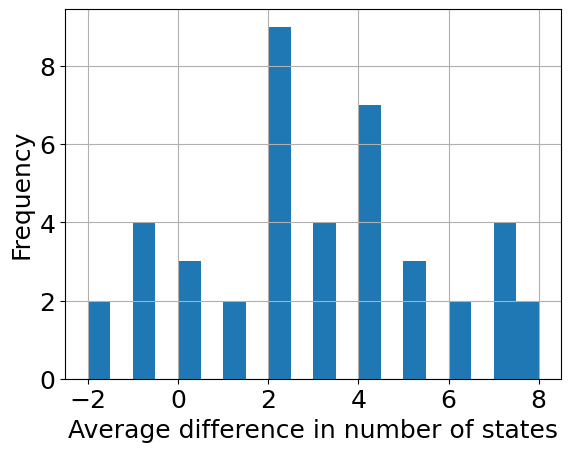

In [38]:
fig, ax = plt.subplots()
ax = dog1_metrics_df['avg_diff_states'].hist(bins=20)
ax.set_xlabel('Average difference in number of states');
ax.set_ylabel('Frequency');

In [30]:
dog1_metrics_df['avg_diff_states'].describe()

count   42.000
mean     2.929
std      2.744
min     -2.000
25%      1.250
50%      3.000
75%      4.750
max      8.000
Name: avg_diff_states, dtype: float64

In [31]:
dog1_metrics_df['early_num_states'].describe()

count   42.000
mean    10.500
std      2.222
min      6.000
25%      9.000
50%     10.000
75%     12.000
max     16.000
Name: early_num_states, dtype: float64

In [32]:
dog1_metrics_df['late_num_states'].describe()

count   42.000
mean     7.571
std      1.977
min      4.000
25%      6.000
50%      7.500
75%      9.000
max     12.000
Name: late_num_states, dtype: float64

### State transitions

In [40]:
dog1_metrics_df['avg_diff_transitions'] = dog1_metrics_df['early_num_transitions'] - dog1_metrics_df['late_num_transitions']

In [42]:
mean_diff = np.mean(dog1_metrics_df['avg_diff_transitions'])
std_diff = np.std(dog1_metrics_df['avg_diff_transitions'], ddof=1)

t_stat, p_val = stats.ttest_rel(dog1_metrics_df['early_num_transitions'], dog1_metrics_df['late_num_transitions'])

deg_of_freedom = len(dog1_metrics_df['early_num_transitions']) - 1

conf_level = 0.95
alpha = 1 - conf_level
crit_value = stats.t.ppf(1 - alpha / 2, deg_of_freedom)
margin_error = crit_value * (std_diff / np.sqrt(len(dog1_metrics_df['avg_diff_transitions'])))
conf_interval = [mean_diff - margin_error, mean_diff + margin_error]

cohen_d = mean_diff / std_diff

print(f"Mean difference: {mean_diff}")
print(f"Standard error of the mean: {std_diff}")
print(f"t-statistic: {t_stat}")
print(f"p-value: {p_val}")
print(f"95% Confidence Interval: {conf_interval}")
print(f"Cohen's d: {cohen_d}")

Mean difference: 11.452380952380953
Standard error of the mean: 9.518153082149816
t-statistic: 7.797721962568239
p-value: 1.2620923134173493e-09
95% Confidence Interval: [np.float64(8.486315651071058), np.float64(14.418446253690847)]
Cohen's d: 1.2032146208972574


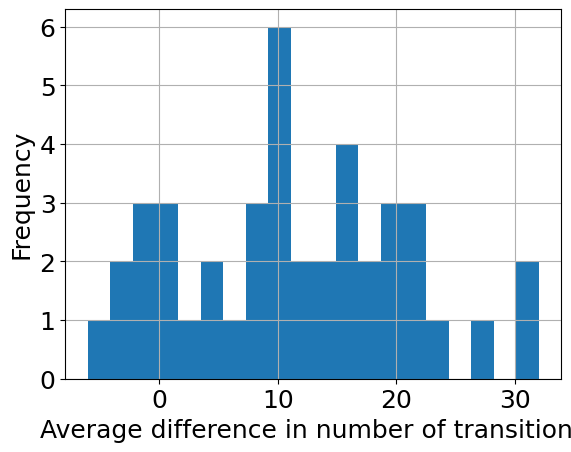

In [45]:
fig, ax = plt.subplots()
ax = dog1_metrics_df['avg_diff_transitions'].hist(bins=20)
ax.set_xlabel('Average difference in number of transitions');
ax.set_ylabel('Frequency');

In [46]:
dog1_metrics_df['avg_diff_transitions'].describe()

count   42.000
mean    11.452
std      9.518
min     -6.000
25%      4.250
50%     11.000
75%     18.000
max     32.000
Name: avg_diff_transitions, dtype: float64

In [48]:
dog1_metrics_df['early_num_transitions'].describe()

count   42.000
mean    33.976
std      8.327
min     21.000
25%     27.250
50%     33.000
75%     40.750
max     51.000
Name: early_num_transitions, dtype: float64

In [49]:
dog1_metrics_df['late_num_transitions'].describe()

count   42.000
mean    22.524
std      7.369
min      8.000
25%     19.000
50%     21.000
75%     27.000
max     38.000
Name: late_num_transitions, dtype: float64

### Average transition count (like the "strength" of the edge)

In [53]:
# We expect to have edges w/ larger transition numbers later vs earlier
dog1_metrics_df['avg_diff_avg_strength'] = dog1_metrics_df['early_avg_transition'] - dog1_metrics_df['late_avg_transition']

In [54]:
mean_diff = np.mean(dog1_metrics_df['avg_diff_avg_strength'])
std_diff = np.std(dog1_metrics_df['avg_diff_avg_strength'], ddof=1)

t_stat, p_val = stats.ttest_rel(dog1_metrics_df['early_avg_transition'], dog1_metrics_df['late_avg_transition'])

deg_of_freedom = len(dog1_metrics_df['early_avg_transition']) - 1

conf_level = 0.95
alpha = 1 - conf_level
crit_value = stats.t.ppf(1 - alpha / 2, deg_of_freedom)
margin_error = crit_value * (std_diff / np.sqrt(len(dog1_metrics_df['avg_diff_avg_strength'])))
conf_interval = [mean_diff - margin_error, mean_diff + margin_error]

cohen_d = mean_diff / std_diff

print(f"Mean difference: {mean_diff}")
print(f"Standard error of the mean: {std_diff}")
print(f"t-statistic: {t_stat}")
print(f"p-value: {p_val}")
print(f"95% Confidence Interval: {conf_interval}")
print(f"Cohen's d: {cohen_d}")

Mean difference: -57.34853351148926
Standard error of the mean: 59.73886414856733
t-statistic: -6.2214268787838805
p-value: 2.0946329041657067e-07
95% Confidence Interval: [np.float64(-75.96447407910098), np.float64(-38.732592943877535)]
Cohen's d: -0.9599870089405542


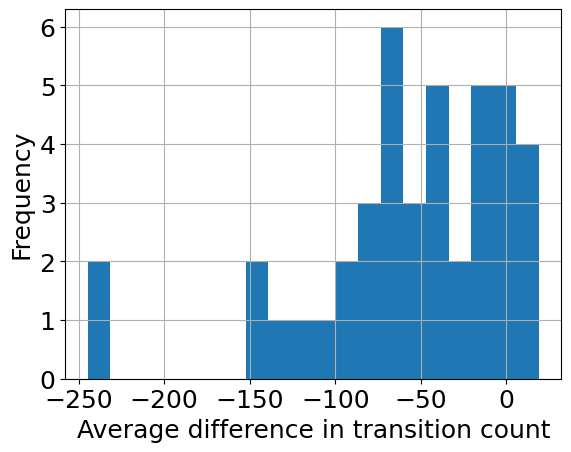

In [56]:
fig, ax = plt.subplots()
ax = dog1_metrics_df['avg_diff_avg_strength'].hist(bins=20)
ax.set_xlabel('Average difference in transition count');
ax.set_ylabel('Frequency');

In [57]:
dog1_metrics_df['avg_diff_avg_strength'].describe()

count     42.000
mean     -57.349
std       59.739
min     -244.565
25%      -80.825
50%      -48.335
75%      -17.741
max       18.943
Name: avg_diff_avg_strength, dtype: float64

In [58]:
dog1_metrics_df['late_avg_transition'].describe()

count    42.000
mean    151.089
std      62.829
min      78.974
25%     111.111
50%     142.857
75%     157.895
max     375.000
Name: late_avg_transition, dtype: float64

In [59]:
dog1_metrics_df['early_avg_transition'].describe()

count    42.000
mean     93.740
std      22.938
min      58.824
25%      73.646
50%      90.924
75%     110.128
max     142.857
Name: early_avg_transition, dtype: float64

## Cognitive graphs for Dog 1

[((2, 1), (2, 1), np.float64(25.0)), ((2, 1), (3, 1), np.float64(1.0)), ((3, 1), (3, 1), np.float64(50.0)), ((3, 1), (3, 2), np.float64(2.0)), ((2, 2), (2, 2), np.float64(558.0)), ((2, 2), (2, 3), np.float64(3.0)), ((2, 2), (3, 2), np.float64(15.0)), ((3, 2), (2, 2), np.float64(16.0)), ((3, 2), (3, 1), np.float64(1.0)), ((3, 2), (3, 2), np.float64(1242.0)), ((3, 2), (3, 3), np.float64(13.0)), ((3, 2), (4, 2), np.float64(2.0)), ((4, 2), (4, 2), np.float64(10.0)), ((4, 2), (4, 3), np.float64(2.0)), ((2, 3), (2, 2), np.float64(2.0)), ((2, 3), (2, 3), np.float64(241.0)), ((2, 3), (3, 3), np.float64(7.0)), ((3, 3), (2, 3), np.float64(6.0)), ((3, 3), (3, 2), np.float64(16.0)), ((3, 3), (3, 3), np.float64(695.0)), ((3, 3), (4, 3), np.float64(1.0)), ((4, 3), (3, 3), np.float64(3.0)), ((4, 3), (4, 3), np.float64(90.0))]
# of non-zero transition probabilities for trial first: 23
# of states visited for trial first: 8
Average non-zero transition probability: 130.47826
{(2, 1): np.float64(25.0), (

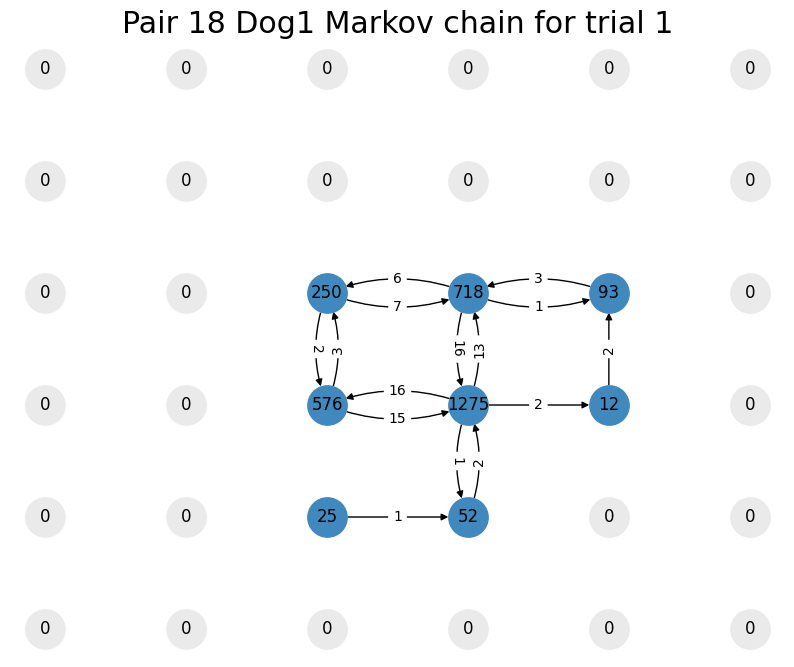

[((2, 1), (2, 1), np.float64(21.0)), ((2, 1), (3, 1), np.float64(1.0)), ((3, 1), (3, 1), np.float64(37.0)), ((3, 1), (3, 2), np.float64(2.0)), ((2, 2), (2, 2), np.float64(757.0)), ((2, 2), (2, 3), np.float64(2.0)), ((2, 2), (3, 2), np.float64(21.0)), ((3, 2), (2, 2), np.float64(21.0)), ((3, 2), (3, 1), np.float64(1.0)), ((3, 2), (3, 2), np.float64(1304.0)), ((3, 2), (3, 3), np.float64(16.0)), ((3, 2), (4, 2), np.float64(1.0)), ((4, 2), (3, 2), np.float64(1.0)), ((4, 2), (4, 2), np.float64(1.0)), ((2, 3), (2, 2), np.float64(2.0)), ((2, 3), (2, 3), np.float64(169.0)), ((2, 3), (3, 3), np.float64(4.0)), ((3, 3), (2, 3), np.float64(4.0)), ((3, 3), (3, 2), np.float64(16.0)), ((3, 3), (3, 3), np.float64(619.0))]
# of non-zero transition probabilities for trial last: 20
# of states visited for trial last: 7
Average non-zero transition probability: 150.00000
{(2, 1): np.float64(21.0), (3, 1): np.float64(39.0), (4, 2): np.float64(2.0), (2, 3): np.float64(175.0), (3, 3): np.float64(639.0), (2, 2

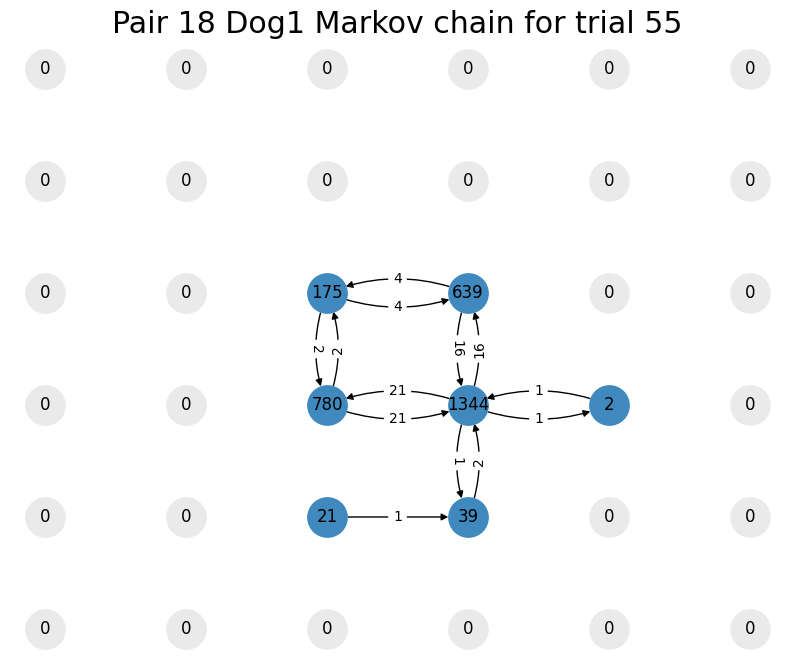

[((2, 1), (2, 1), np.float64(210.0)), ((2, 1), (2, 2), np.float64(3.0)), ((2, 1), (3, 1), np.float64(2.0)), ((3, 1), (2, 1), np.float64(2.0)), ((3, 1), (3, 1), np.float64(71.0)), ((3, 1), (3, 2), np.float64(1.0)), ((1, 2), (1, 2), np.float64(57.0)), ((1, 2), (2, 2), np.float64(2.0)), ((2, 2), (1, 2), np.float64(2.0)), ((2, 2), (2, 1), np.float64(2.0)), ((2, 2), (2, 2), np.float64(1088.0)), ((2, 2), (3, 2), np.float64(17.0)), ((3, 2), (2, 2), np.float64(16.0)), ((3, 2), (3, 1), np.float64(1.0)), ((3, 2), (3, 2), np.float64(1108.0)), ((3, 2), (3, 3), np.float64(3.0)), ((3, 2), (4, 2), np.float64(5.0)), ((4, 2), (3, 2), np.float64(4.0)), ((4, 2), (4, 2), np.float64(136.0)), ((4, 2), (4, 3), np.float64(2.0)), ((3, 3), (3, 2), np.float64(4.0)), ((3, 3), (3, 3), np.float64(220.0)), ((3, 3), (4, 3), np.float64(2.0)), ((4, 3), (3, 3), np.float64(3.0)), ((4, 3), (4, 2), np.float64(1.0)), ((4, 3), (4, 3), np.float64(39.0))]
# of non-zero transition probabilities for trial first: 26
# of states v

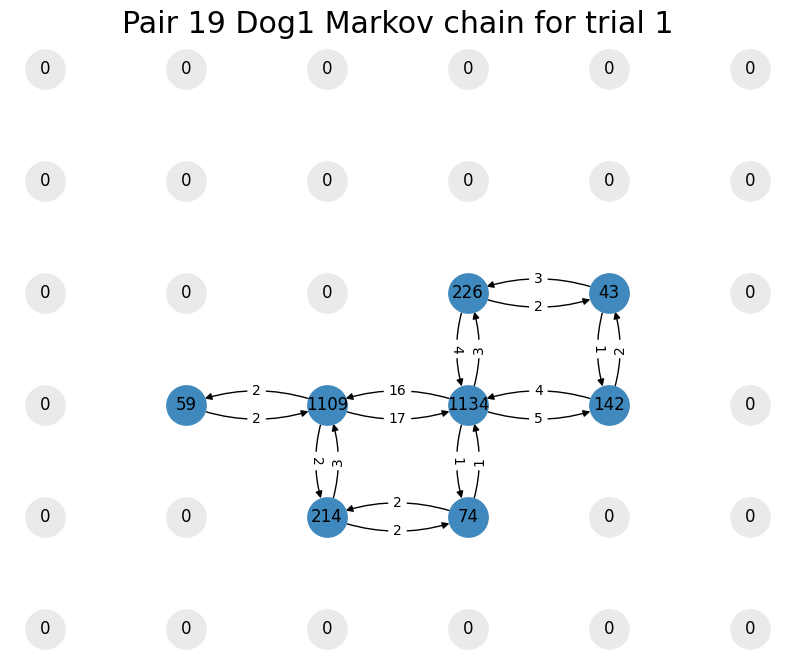

[((2, 1), (2, 1), np.float64(358.0)), ((2, 1), (2, 2), np.float64(7.0)), ((2, 1), (3, 1), np.float64(8.0)), ((3, 1), (2, 1), np.float64(6.0)), ((3, 1), (3, 1), np.float64(198.0)), ((3, 1), (3, 2), np.float64(6.0)), ((1, 2), (1, 2), np.float64(39.0)), ((1, 2), (2, 2), np.float64(1.0)), ((2, 2), (1, 2), np.float64(1.0)), ((2, 2), (2, 1), np.float64(7.0)), ((2, 2), (2, 2), np.float64(796.0)), ((2, 2), (3, 2), np.float64(6.0)), ((3, 2), (2, 1), np.float64(1.0)), ((3, 2), (2, 2), np.float64(7.0)), ((3, 2), (3, 1), np.float64(4.0)), ((3, 2), (3, 2), np.float64(1116.0)), ((3, 2), (3, 3), np.float64(1.0)), ((3, 2), (4, 2), np.float64(6.0)), ((4, 2), (3, 2), np.float64(3.0)), ((4, 2), (4, 2), np.float64(76.0)), ((4, 2), (4, 3), np.float64(5.0)), ((3, 3), (3, 2), np.float64(4.0)), ((3, 3), (3, 3), np.float64(154.0)), ((3, 3), (4, 3), np.float64(4.0)), ((4, 3), (3, 3), np.float64(7.0)), ((4, 3), (4, 2), np.float64(2.0)), ((4, 3), (4, 3), np.float64(177.0))]
# of non-zero transition probabilities 

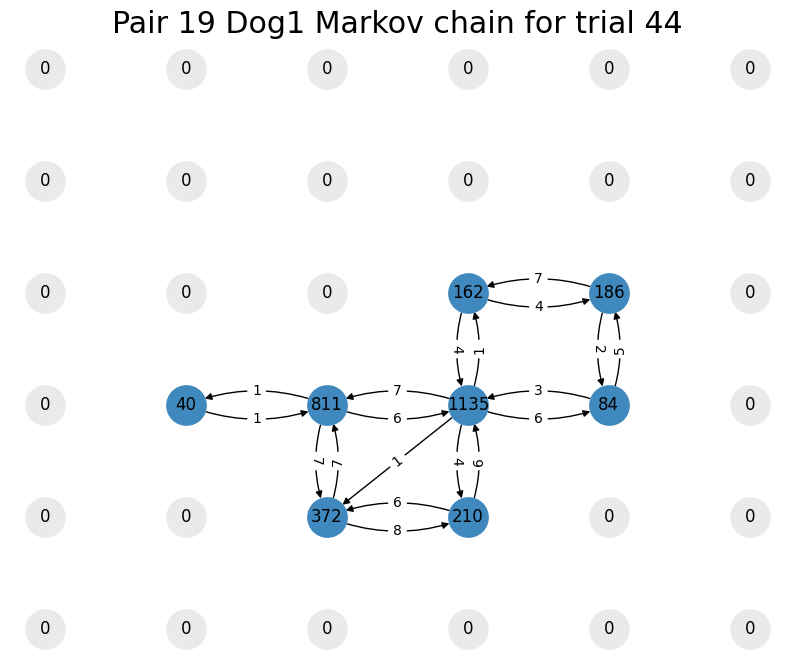

[((2, 1), (2, 1), np.float64(263.0)), ((2, 1), (2, 2), np.float64(6.0)), ((3, 1), (2, 1), np.float64(2.0)), ((3, 1), (3, 1), np.float64(67.0)), ((1, 2), (1, 2), np.float64(45.0)), ((1, 2), (1, 3), np.float64(1.0)), ((1, 2), (2, 2), np.float64(1.0)), ((2, 2), (1, 2), np.float64(2.0)), ((2, 2), (2, 1), np.float64(3.0)), ((2, 2), (2, 2), np.float64(767.0)), ((2, 2), (2, 3), np.float64(2.0)), ((2, 2), (3, 2), np.float64(12.0)), ((3, 2), (2, 2), np.float64(9.0)), ((3, 2), (3, 1), np.float64(3.0)), ((3, 2), (3, 2), np.float64(858.0)), ((3, 2), (3, 3), np.float64(10.0)), ((3, 2), (4, 2), np.float64(2.0)), ((4, 2), (4, 2), np.float64(18.0)), ((4, 2), (4, 3), np.float64(2.0)), ((1, 3), (1, 3), np.float64(15.0)), ((1, 3), (2, 3), np.float64(1.0)), ((2, 3), (2, 2), np.float64(3.0)), ((2, 3), (2, 3), np.float64(172.0)), ((2, 3), (3, 3), np.float64(2.0)), ((3, 3), (2, 3), np.float64(2.0)), ((3, 3), (3, 2), np.float64(12.0)), ((3, 3), (3, 3), np.float64(646.0)), ((3, 3), (3, 4), np.float64(1.0)), ((

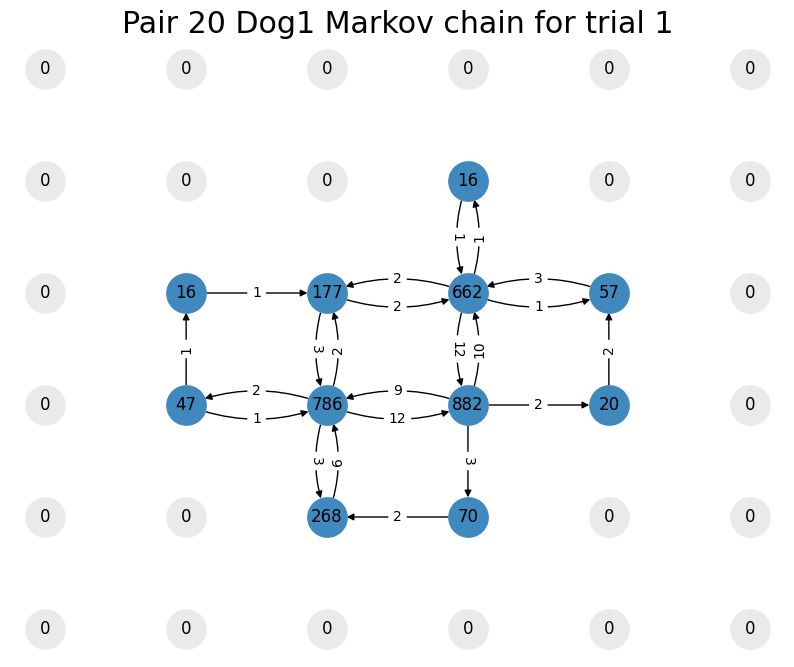

[((2, 1), (2, 1), np.float64(30.0)), ((2, 1), (3, 1), np.float64(1.0)), ((3, 1), (3, 1), np.float64(3.0)), ((3, 1), (3, 2), np.float64(1.0)), ((2, 2), (2, 2), np.float64(1068.0)), ((2, 2), (2, 3), np.float64(4.0)), ((2, 2), (3, 2), np.float64(16.0)), ((3, 2), (2, 2), np.float64(16.0)), ((3, 2), (3, 2), np.float64(1211.0)), ((3, 2), (3, 3), np.float64(8.0)), ((4, 2), (3, 2), np.float64(1.0)), ((4, 2), (4, 2), np.float64(1.0)), ((2, 3), (2, 2), np.float64(4.0)), ((2, 3), (2, 3), np.float64(256.0)), ((2, 3), (3, 3), np.float64(3.0)), ((3, 3), (2, 3), np.float64(3.0)), ((3, 3), (3, 2), np.float64(7.0)), ((3, 3), (3, 3), np.float64(362.0)), ((3, 3), (4, 3), np.float64(1.0)), ((4, 3), (4, 2), np.float64(1.0)), ((4, 3), (4, 3), np.float64(4.0))]
# of non-zero transition probabilities for trial last: 21
# of states visited for trial last: 8
Average non-zero transition probability: 142.90476
{(2, 1): np.float64(30.0), (4, 3): np.float64(5.0), (3, 1): np.float64(4.0), (4, 2): np.float64(2.0), (2

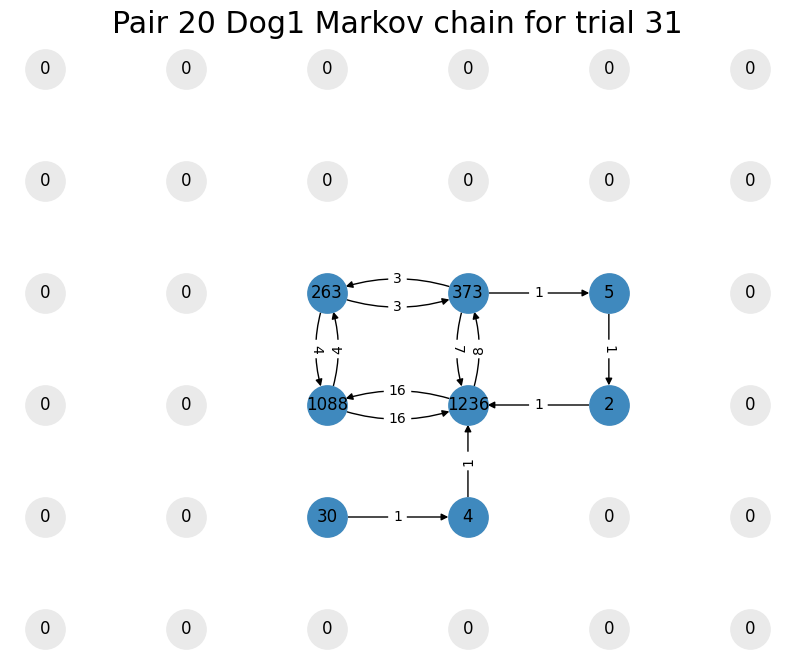

[((2, 1), (2, 1), np.float64(401.0)), ((2, 1), (2, 2), np.float64(13.0)), ((2, 1), (3, 1), np.float64(11.0)), ((2, 1), (3, 2), np.float64(1.0)), ((3, 1), (2, 1), np.float64(11.0)), ((3, 1), (3, 1), np.float64(345.0)), ((3, 1), (3, 2), np.float64(14.0)), ((1, 2), (1, 2), np.float64(169.0)), ((1, 2), (1, 3), np.float64(3.0)), ((1, 2), (2, 2), np.float64(5.0)), ((2, 2), (1, 2), np.float64(5.0)), ((2, 2), (2, 1), np.float64(11.0)), ((2, 2), (2, 2), np.float64(595.0)), ((2, 2), (3, 1), np.float64(2.0)), ((2, 2), (3, 2), np.float64(5.0)), ((3, 2), (2, 1), np.float64(2.0)), ((3, 2), (2, 2), np.float64(6.0)), ((3, 2), (3, 1), np.float64(12.0)), ((3, 2), (3, 2), np.float64(937.0)), ((3, 2), (4, 2), np.float64(10.0)), ((4, 2), (3, 2), np.float64(9.0)), ((4, 2), (4, 2), np.float64(182.0)), ((4, 2), (4, 3), np.float64(5.0)), ((1, 3), (1, 2), np.float64(3.0)), ((1, 3), (1, 3), np.float64(38.0)), ((1, 3), (2, 3), np.float64(1.0)), ((2, 3), (1, 3), np.float64(1.0)), ((2, 3), (2, 3), np.float64(22.0))

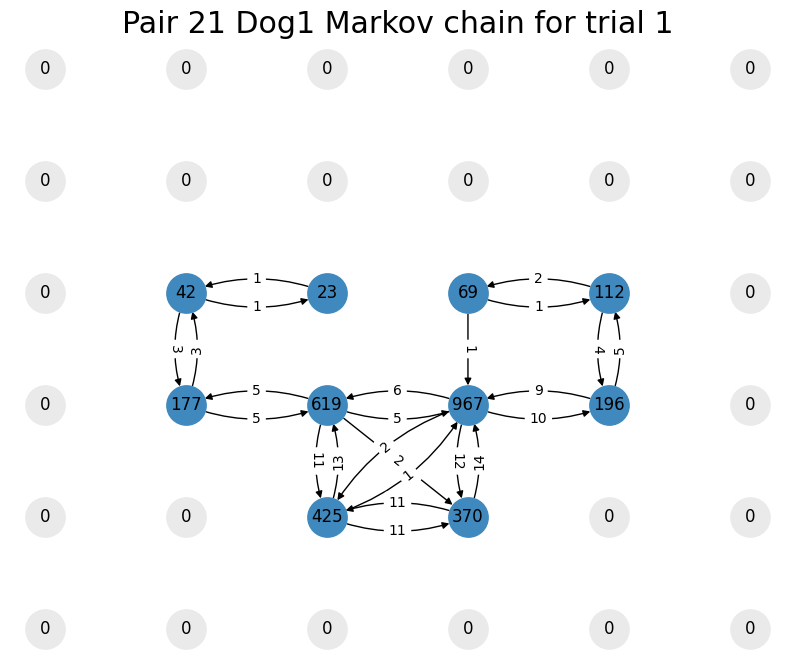

[((2, 1), (2, 1), np.float64(192.0)), ((2, 1), (2, 2), np.float64(31.0)), ((2, 1), (3, 1), np.float64(23.0)), ((2, 1), (3, 2), np.float64(3.0)), ((3, 1), (2, 1), np.float64(26.0)), ((3, 1), (3, 1), np.float64(46.0)), ((3, 1), (3, 2), np.float64(24.0)), ((1, 2), (1, 2), np.float64(62.0)), ((1, 2), (2, 1), np.float64(1.0)), ((1, 2), (2, 2), np.float64(11.0)), ((2, 2), (1, 2), np.float64(12.0)), ((2, 2), (2, 1), np.float64(25.0)), ((2, 2), (2, 2), np.float64(1010.0)), ((2, 2), (3, 1), np.float64(1.0)), ((2, 2), (3, 2), np.float64(30.0)), ((3, 2), (2, 1), np.float64(4.0)), ((3, 2), (2, 2), np.float64(26.0)), ((3, 2), (3, 1), np.float64(26.0)), ((3, 2), (3, 2), np.float64(1261.0)), ((3, 2), (3, 3), np.float64(4.0)), ((3, 2), (4, 2), np.float64(17.0)), ((3, 2), (4, 3), np.float64(1.0)), ((4, 2), (3, 2), np.float64(17.0)), ((4, 2), (4, 2), np.float64(82.0)), ((4, 2), (4, 3), np.float64(3.0)), ((3, 3), (3, 2), np.float64(4.0)), ((3, 3), (3, 3), np.float64(27.0)), ((4, 3), (3, 2), np.float64(1.

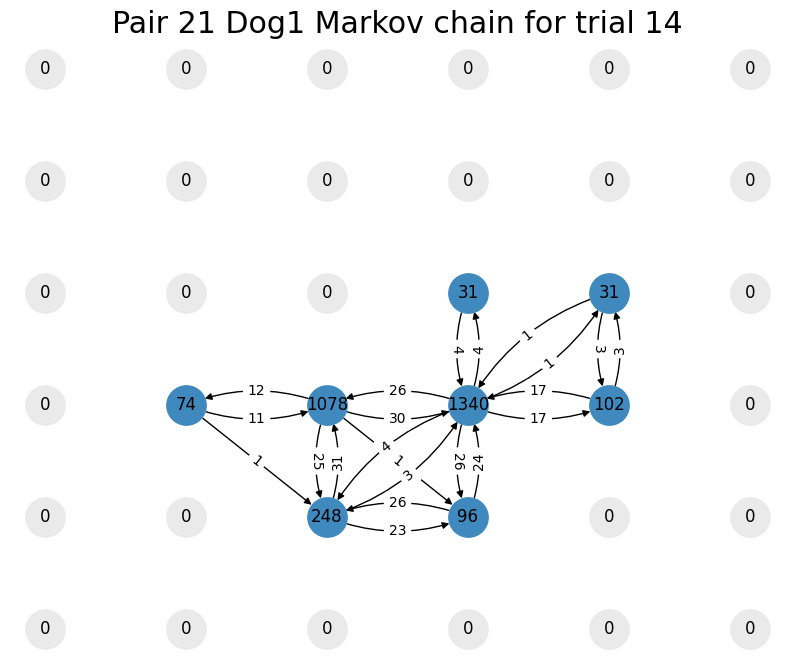

[((2, 1), (2, 1), np.float64(400.0)), ((2, 1), (2, 2), np.float64(8.0)), ((2, 1), (3, 1), np.float64(4.0)), ((2, 1), (3, 2), np.float64(1.0)), ((3, 1), (2, 1), np.float64(3.0)), ((3, 1), (3, 1), np.float64(35.0)), ((3, 1), (3, 2), np.float64(4.0)), ((1, 2), (1, 2), np.float64(14.0)), ((1, 2), (2, 2), np.float64(1.0)), ((2, 2), (1, 2), np.float64(1.0)), ((2, 2), (2, 1), np.float64(8.0)), ((2, 2), (2, 2), np.float64(1058.0)), ((2, 2), (3, 2), np.float64(13.0)), ((3, 2), (2, 1), np.float64(1.0)), ((3, 2), (2, 2), np.float64(13.0)), ((3, 2), (3, 1), np.float64(3.0)), ((3, 2), (3, 2), np.float64(1184.0)), ((3, 2), (3, 3), np.float64(6.0)), ((3, 2), (4, 2), np.float64(1.0)), ((4, 2), (3, 2), np.float64(1.0)), ((4, 2), (4, 2), np.float64(16.0)), ((3, 3), (3, 2), np.float64(6.0)), ((3, 3), (3, 3), np.float64(215.0)), ((3, 3), (4, 3), np.float64(1.0)), ((4, 3), (3, 3), np.float64(1.0)), ((4, 3), (4, 3), np.float64(2.0))]
# of non-zero transition probabilities for trial first: 26
# of states vis

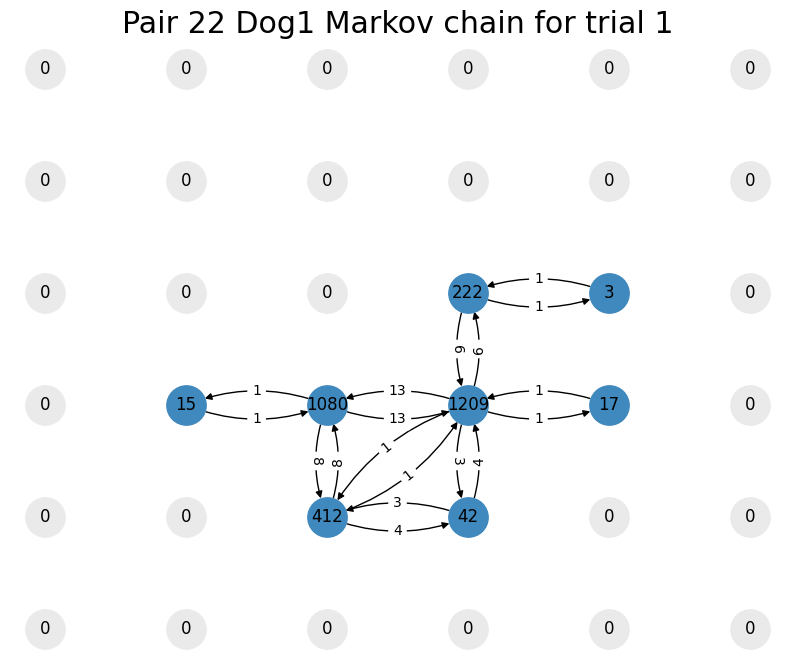

[((2, 1), (2, 1), np.float64(27.0)), ((2, 1), (3, 1), np.float64(1.0)), ((3, 1), (3, 1), np.float64(47.0)), ((3, 1), (3, 2), np.float64(3.0)), ((1, 2), (1, 2), np.float64(9.0)), ((1, 2), (2, 2), np.float64(1.0)), ((2, 2), (1, 2), np.float64(1.0)), ((2, 2), (2, 2), np.float64(1077.0)), ((2, 2), (3, 2), np.float64(23.0)), ((3, 2), (2, 2), np.float64(23.0)), ((3, 2), (3, 1), np.float64(2.0)), ((3, 2), (3, 2), np.float64(1369.0)), ((3, 2), (3, 3), np.float64(11.0)), ((3, 3), (3, 2), np.float64(11.0)), ((3, 3), (3, 3), np.float64(395.0))]
# of non-zero transition probabilities for trial last: 15
# of states visited for trial last: 6
Average non-zero transition probability: 200.00000
{(1, 2): np.float64(10.0), (2, 1): np.float64(27.0), (3, 1): np.float64(50.0), (3, 3): np.float64(406.0), (2, 2): np.float64(1101.0), (3, 2): np.float64(1406.0)}


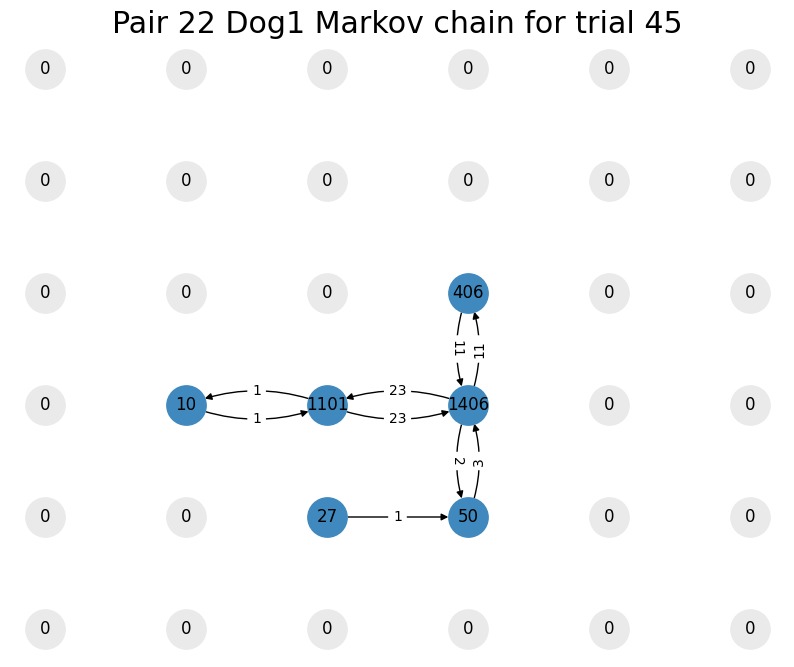

[((1, 1), (1, 1), np.float64(8.0)), ((1, 1), (1, 2), np.float64(3.0)), ((2, 1), (1, 1), np.float64(3.0)), ((2, 1), (2, 1), np.float64(386.0)), ((2, 1), (2, 2), np.float64(12.0)), ((2, 1), (3, 1), np.float64(7.0)), ((3, 1), (2, 1), np.float64(7.0)), ((3, 1), (3, 1), np.float64(196.0)), ((3, 1), (3, 2), np.float64(3.0)), ((3, 1), (4, 1), np.float64(1.0)), ((4, 1), (4, 1), np.float64(3.0)), ((4, 1), (4, 2), np.float64(1.0)), ((1, 2), (1, 2), np.float64(308.0)), ((1, 2), (1, 3), np.float64(4.0)), ((1, 2), (2, 1), np.float64(1.0)), ((1, 2), (2, 2), np.float64(9.0)), ((2, 2), (1, 2), np.float64(5.0)), ((2, 2), (2, 1), np.float64(12.0)), ((2, 2), (2, 2), np.float64(850.0)), ((2, 2), (2, 3), np.float64(2.0)), ((2, 2), (3, 2), np.float64(8.0)), ((3, 2), (2, 1), np.float64(1.0)), ((3, 2), (2, 2), np.float64(5.0)), ((3, 2), (3, 1), np.float64(4.0)), ((3, 2), (3, 2), np.float64(520.0)), ((3, 2), (4, 2), np.float64(6.0)), ((3, 2), (4, 3), np.float64(1.0)), ((4, 2), (3, 2), np.float64(5.0)), ((4, 2)

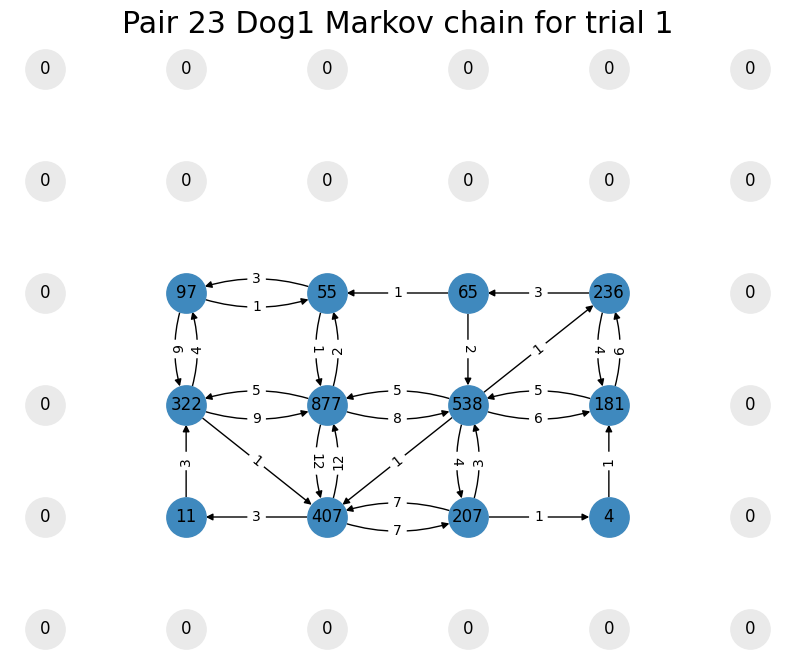

[((2, 1), (2, 1), np.float64(90.0)), ((2, 1), (2, 2), np.float64(1.0)), ((2, 1), (3, 1), np.float64(1.0)), ((2, 1), (3, 2), np.float64(1.0)), ((3, 1), (3, 1), np.float64(5.0)), ((3, 1), (3, 2), np.float64(1.0)), ((1, 2), (1, 2), np.float64(64.0)), ((1, 2), (1, 3), np.float64(1.0)), ((1, 2), (2, 2), np.float64(2.0)), ((2, 2), (1, 2), np.float64(2.0)), ((2, 2), (2, 1), np.float64(1.0)), ((2, 2), (2, 2), np.float64(1065.0)), ((2, 2), (2, 3), np.float64(9.0)), ((2, 2), (3, 2), np.float64(21.0)), ((3, 2), (2, 1), np.float64(1.0)), ((3, 2), (2, 2), np.float64(22.0)), ((3, 2), (3, 2), np.float64(1117.0)), ((3, 2), (3, 3), np.float64(13.0)), ((3, 2), (4, 2), np.float64(4.0)), ((4, 2), (3, 2), np.float64(3.0)), ((4, 2), (4, 2), np.float64(55.0)), ((4, 2), (4, 3), np.float64(2.0)), ((1, 3), (1, 2), np.float64(1.0)), ((1, 3), (1, 3), np.float64(19.0)), ((2, 3), (2, 2), np.float64(9.0)), ((2, 3), (2, 3), np.float64(163.0)), ((3, 3), (3, 2), np.float64(14.0)), ((3, 3), (3, 3), np.float64(272.0)), (

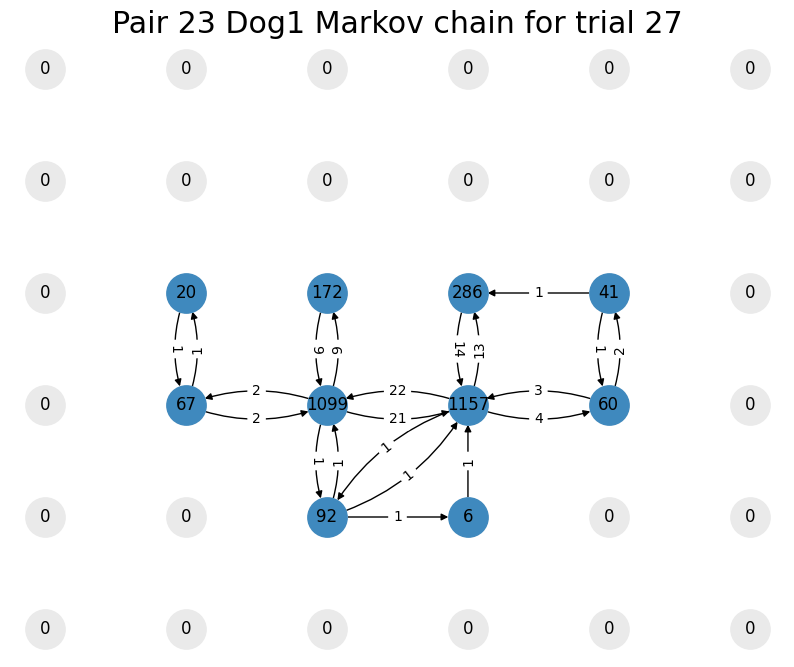

[((2, 1), (2, 1), np.float64(25.0)), ((2, 1), (3, 1), np.float64(2.0)), ((3, 1), (2, 1), np.float64(1.0)), ((3, 1), (3, 1), np.float64(4.0)), ((3, 1), (3, 2), np.float64(1.0)), ((2, 2), (2, 2), np.float64(1028.0)), ((2, 2), (2, 3), np.float64(11.0)), ((2, 2), (3, 2), np.float64(26.0)), ((3, 2), (2, 2), np.float64(24.0)), ((3, 2), (3, 2), np.float64(1044.0)), ((3, 2), (3, 3), np.float64(17.0)), ((3, 2), (4, 2), np.float64(1.0)), ((4, 2), (4, 2), np.float64(20.0)), ((4, 2), (4, 3), np.float64(1.0)), ((2, 3), (2, 2), np.float64(14.0)), ((2, 3), (2, 3), np.float64(427.0)), ((2, 3), (3, 3), np.float64(3.0)), ((3, 3), (2, 3), np.float64(6.0)), ((3, 3), (3, 2), np.float64(15.0)), ((3, 3), (3, 3), np.float64(327.0)), ((4, 3), (3, 3), np.float64(1.0)), ((4, 3), (4, 3), np.float64(3.0))]
# of non-zero transition probabilities for trial first: 22
# of states visited for trial first: 8
Average non-zero transition probability: 136.40909
{(2, 1): np.float64(26.0), (4, 3): np.float64(4.0), (3, 1): np

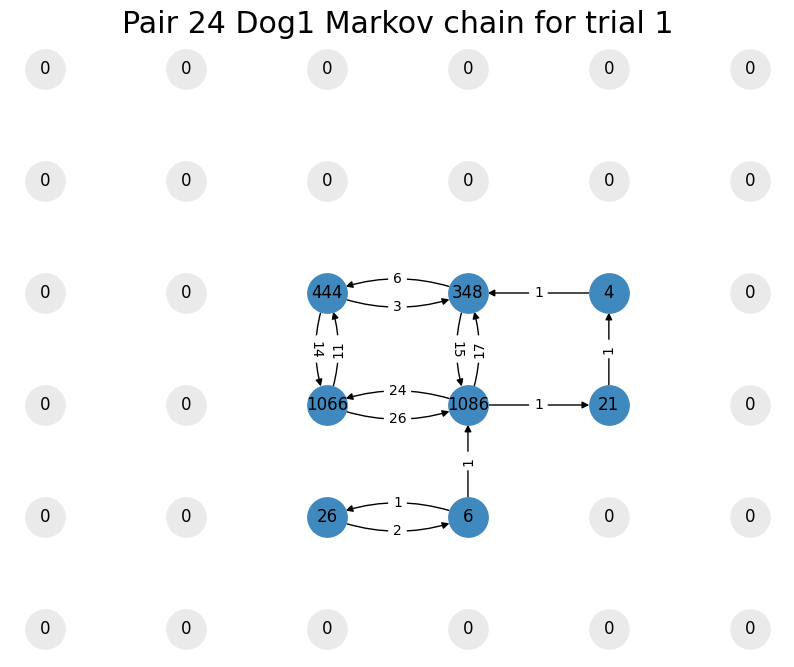

[((2, 1), (2, 1), np.float64(21.0)), ((2, 1), (3, 1), np.float64(1.0)), ((3, 1), (3, 1), np.float64(4.0)), ((3, 1), (3, 2), np.float64(1.0)), ((2, 2), (2, 2), np.float64(794.0)), ((2, 2), (2, 3), np.float64(2.0)), ((2, 2), (3, 2), np.float64(26.0)), ((3, 2), (2, 2), np.float64(27.0)), ((3, 2), (3, 2), np.float64(1211.0)), ((3, 2), (3, 3), np.float64(28.0)), ((4, 2), (3, 2), np.float64(1.0)), ((4, 2), (4, 2), np.float64(7.0)), ((2, 3), (2, 2), np.float64(2.0)), ((2, 3), (2, 3), np.float64(78.0)), ((2, 3), (3, 3), np.float64(4.0)), ((3, 3), (2, 3), np.float64(4.0)), ((3, 3), (3, 2), np.float64(27.0)), ((3, 3), (3, 3), np.float64(686.0)), ((3, 3), (4, 3), np.float64(2.0)), ((4, 3), (3, 3), np.float64(1.0)), ((4, 3), (4, 2), np.float64(1.0)), ((4, 3), (4, 3), np.float64(73.0))]
# of non-zero transition probabilities for trial last: 22
# of states visited for trial last: 8
Average non-zero transition probability: 136.40909
{(2, 1): np.float64(21.0), (4, 3): np.float64(75.0), (3, 1): np.floa

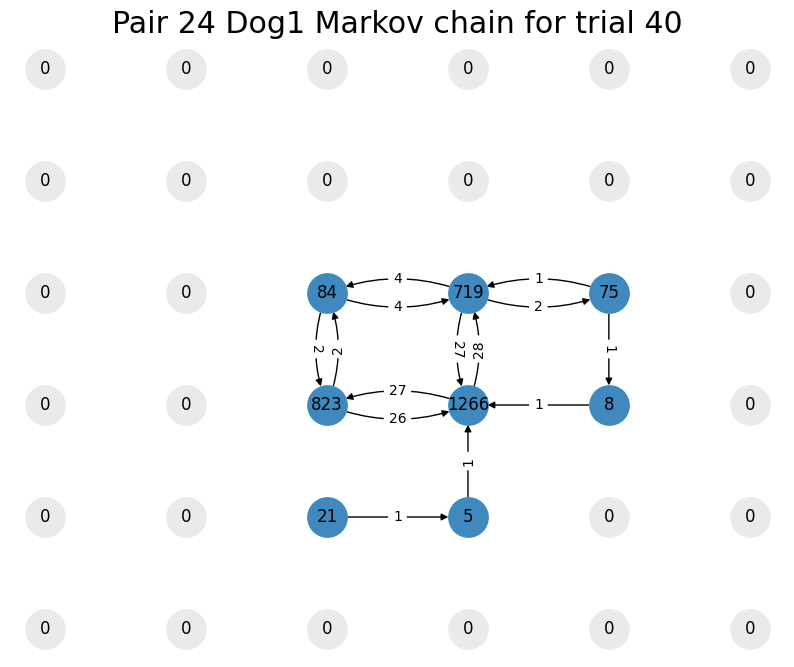

[((1, 1), (1, 1), np.float64(120.0)), ((1, 1), (1, 2), np.float64(2.0)), ((1, 1), (2, 1), np.float64(4.0)), ((2, 1), (1, 1), np.float64(5.0)), ((2, 1), (2, 1), np.float64(602.0)), ((2, 1), (3, 1), np.float64(9.0)), ((3, 1), (2, 1), np.float64(8.0)), ((3, 1), (3, 1), np.float64(418.0)), ((3, 1), (3, 2), np.float64(11.0)), ((3, 1), (4, 1), np.float64(2.0)), ((3, 1), (4, 2), np.float64(2.0)), ((4, 1), (3, 1), np.float64(1.0)), ((4, 1), (4, 1), np.float64(81.0)), ((4, 1), (4, 2), np.float64(2.0)), ((5, 1), (4, 1), np.float64(1.0)), ((5, 1), (5, 1), np.float64(6.0)), ((0, 2), (0, 2), np.float64(10.0)), ((0, 2), (0, 3), np.float64(1.0)), ((1, 2), (0, 2), np.float64(1.0)), ((1, 2), (1, 1), np.float64(1.0)), ((1, 2), (1, 2), np.float64(56.0)), ((1, 2), (2, 2), np.float64(1.0)), ((2, 2), (2, 1), np.float64(2.0)), ((2, 2), (2, 2), np.float64(197.0)), ((2, 2), (3, 2), np.float64(3.0)), ((3, 2), (2, 2), np.float64(4.0)), ((3, 2), (3, 1), np.float64(13.0)), ((3, 2), (3, 2), np.float64(659.0)), ((3,

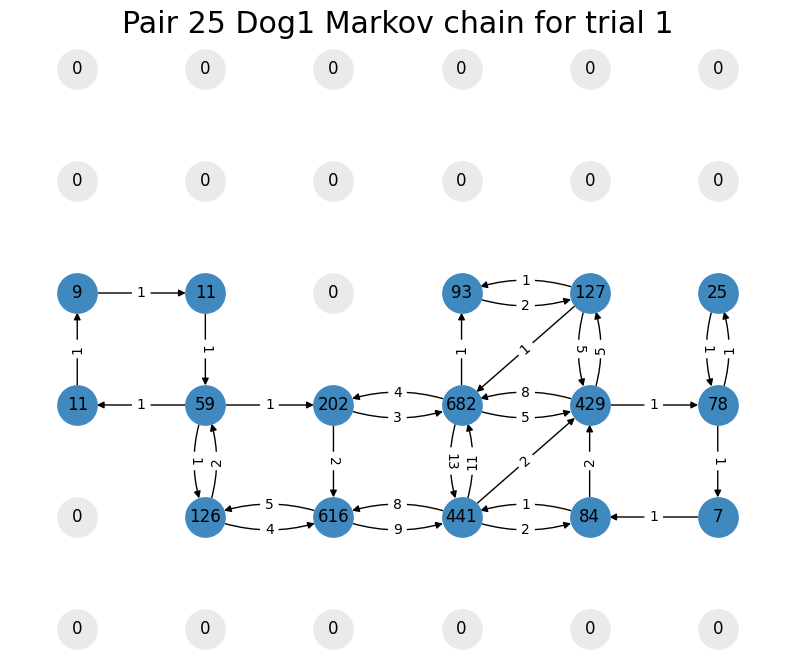

[((2, 1), (2, 1), np.float64(38.0)), ((2, 1), (2, 2), np.float64(2.0)), ((2, 1), (3, 1), np.float64(1.0)), ((3, 1), (2, 1), np.float64(1.0)), ((3, 1), (3, 1), np.float64(40.0)), ((3, 1), (3, 2), np.float64(2.0)), ((1, 2), (1, 2), np.float64(4.0)), ((1, 2), (1, 3), np.float64(1.0)), ((2, 2), (1, 2), np.float64(1.0)), ((2, 2), (2, 1), np.float64(1.0)), ((2, 2), (2, 2), np.float64(1016.0)), ((2, 2), (3, 2), np.float64(34.0)), ((3, 2), (2, 2), np.float64(34.0)), ((3, 2), (3, 1), np.float64(2.0)), ((3, 2), (3, 2), np.float64(1792.0)), ((3, 2), (3, 3), np.float64(1.0)), ((1, 3), (2, 3), np.float64(1.0)), ((2, 3), (2, 2), np.float64(1.0)), ((2, 3), (2, 3), np.float64(11.0)), ((3, 3), (3, 2), np.float64(1.0)), ((3, 3), (3, 3), np.float64(16.0))]
# of non-zero transition probabilities for trial last: 21
# of states visited for trial last: 8
Average non-zero transition probability: 142.85714
{(1, 2): np.float64(5.0), (2, 1): np.float64(40.0), (3, 1): np.float64(43.0), (2, 3): np.float64(12.0), (

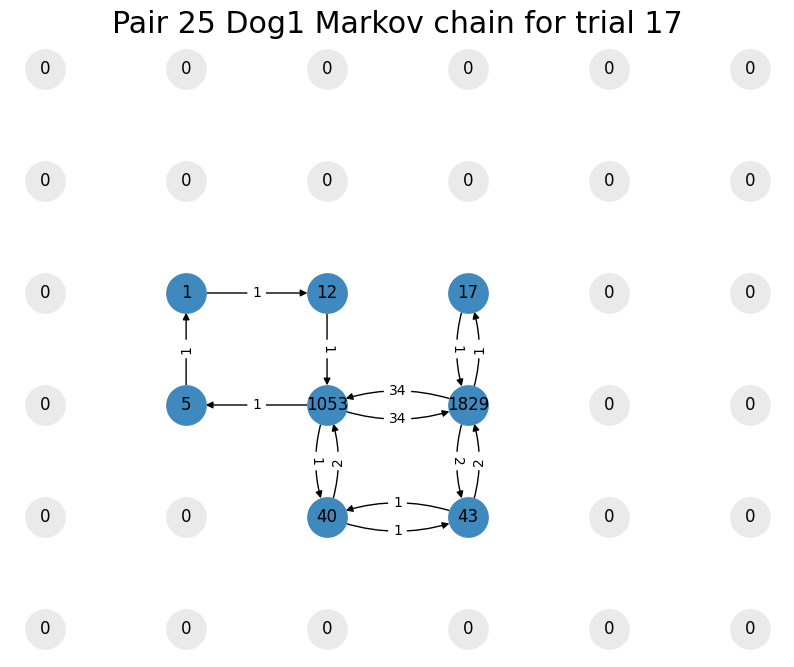

[((2, 1), (2, 1), np.float64(104.0)), ((2, 1), (2, 2), np.float64(1.0)), ((2, 1), (3, 1), np.float64(2.0)), ((3, 1), (2, 1), np.float64(1.0)), ((3, 1), (3, 1), np.float64(12.0)), ((3, 1), (3, 2), np.float64(2.0)), ((1, 2), (1, 2), np.float64(61.0)), ((1, 2), (1, 3), np.float64(2.0)), ((1, 2), (2, 2), np.float64(2.0)), ((2, 2), (1, 2), np.float64(2.0)), ((2, 2), (2, 1), np.float64(1.0)), ((2, 2), (2, 2), np.float64(1057.0)), ((2, 2), (3, 2), np.float64(11.0)), ((3, 2), (2, 2), np.float64(11.0)), ((3, 2), (3, 1), np.float64(1.0)), ((3, 2), (3, 2), np.float64(1283.0)), ((3, 2), (3, 3), np.float64(4.0)), ((3, 2), (4, 2), np.float64(4.0)), ((4, 2), (3, 2), np.float64(4.0)), ((4, 2), (4, 2), np.float64(100.0)), ((4, 2), (4, 3), np.float64(2.0)), ((1, 3), (1, 2), np.float64(2.0)), ((1, 3), (1, 3), np.float64(81.0)), ((3, 3), (3, 2), np.float64(4.0)), ((3, 3), (3, 3), np.float64(101.0)), ((4, 3), (4, 2), np.float64(2.0)), ((4, 3), (4, 3), np.float64(143.0))]
# of non-zero transition probabilit

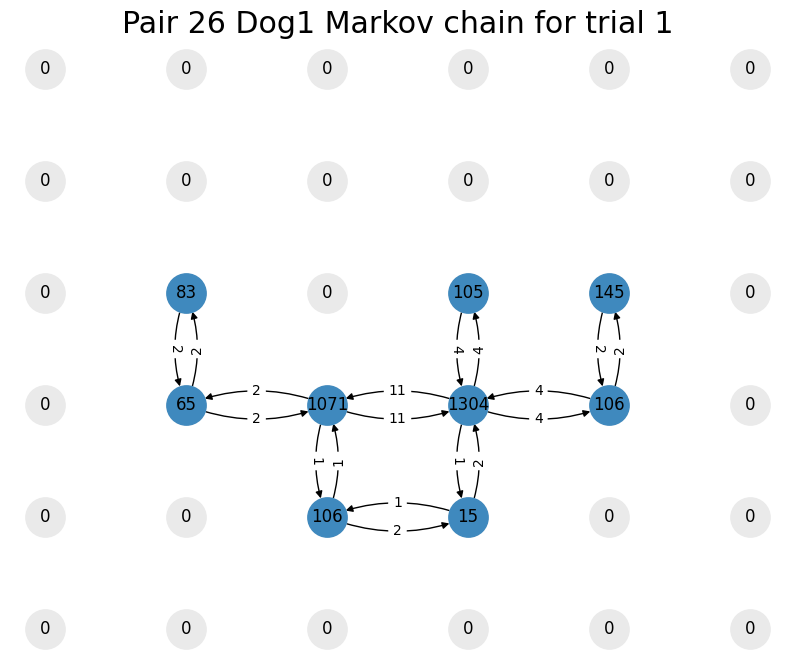

[((2, 1), (2, 1), np.float64(46.0)), ((2, 1), (2, 2), np.float64(1.0)), ((2, 1), (3, 1), np.float64(1.0)), ((3, 1), (3, 1), np.float64(5.0)), ((3, 1), (3, 2), np.float64(1.0)), ((2, 2), (2, 1), np.float64(1.0)), ((2, 2), (2, 2), np.float64(1364.0)), ((2, 2), (2, 3), np.float64(6.0)), ((2, 2), (3, 2), np.float64(25.0)), ((3, 2), (2, 2), np.float64(25.0)), ((3, 2), (3, 2), np.float64(1243.0)), ((3, 2), (3, 3), np.float64(6.0)), ((3, 2), (4, 2), np.float64(2.0)), ((4, 2), (3, 2), np.float64(2.0)), ((4, 2), (4, 2), np.float64(18.0)), ((2, 3), (2, 2), np.float64(6.0)), ((2, 3), (2, 3), np.float64(172.0)), ((3, 3), (3, 2), np.float64(5.0)), ((3, 3), (3, 3), np.float64(71.0))]
# of non-zero transition probabilities for trial last: 19
# of states visited for trial last: 7
Average non-zero transition probability: 157.89474
{(2, 1): np.float64(47.0), (3, 1): np.float64(6.0), (4, 2): np.float64(20.0), (2, 3): np.float64(178.0), (3, 3): np.float64(77.0), (2, 2): np.float64(1396.0), (3, 2): np.floa

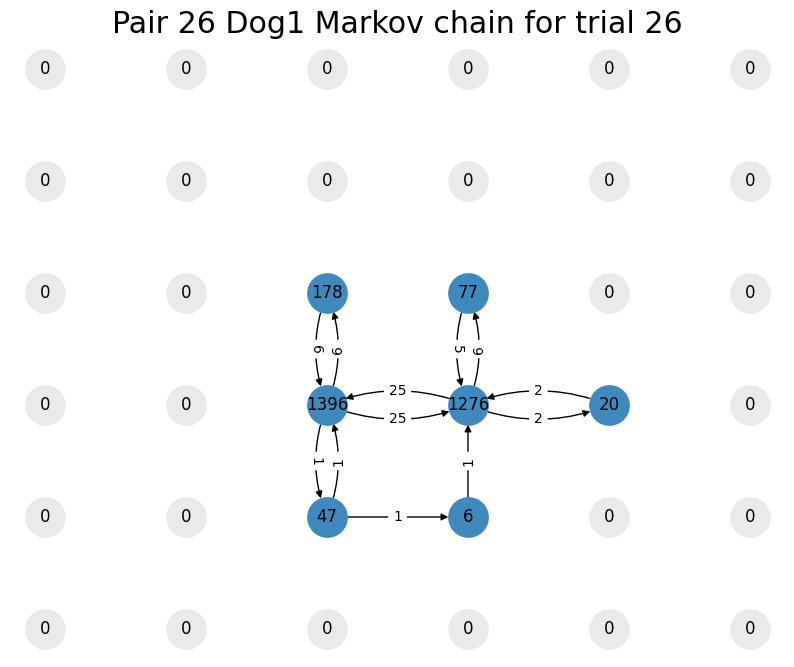

[((2, 1), (2, 1), np.float64(656.0)), ((2, 1), (2, 2), np.float64(9.0)), ((2, 1), (3, 1), np.float64(9.0)), ((3, 1), (2, 1), np.float64(7.0)), ((3, 1), (3, 1), np.float64(405.0)), ((3, 1), (3, 2), np.float64(11.0)), ((3, 1), (4, 1), np.float64(1.0)), ((4, 1), (4, 1), np.float64(26.0)), ((4, 1), (4, 2), np.float64(1.0)), ((1, 2), (1, 2), np.float64(23.0)), ((1, 2), (1, 3), np.float64(1.0)), ((1, 2), (2, 2), np.float64(1.0)), ((2, 2), (1, 2), np.float64(1.0)), ((2, 2), (2, 1), np.float64(9.0)), ((2, 2), (2, 2), np.float64(488.0)), ((2, 2), (3, 2), np.float64(4.0)), ((3, 2), (2, 1), np.float64(1.0)), ((3, 2), (2, 2), np.float64(4.0)), ((3, 2), (3, 1), np.float64(10.0)), ((3, 2), (3, 2), np.float64(616.0)), ((3, 2), (4, 2), np.float64(10.0)), ((4, 2), (3, 2), np.float64(11.0)), ((4, 2), (4, 2), np.float64(635.0)), ((4, 2), (4, 3), np.float64(2.0)), ((1, 3), (1, 2), np.float64(1.0)), ((1, 3), (1, 3), np.float64(13.0)), ((4, 3), (4, 2), np.float64(2.0)), ((4, 3), (4, 3), np.float64(44.0))]
#

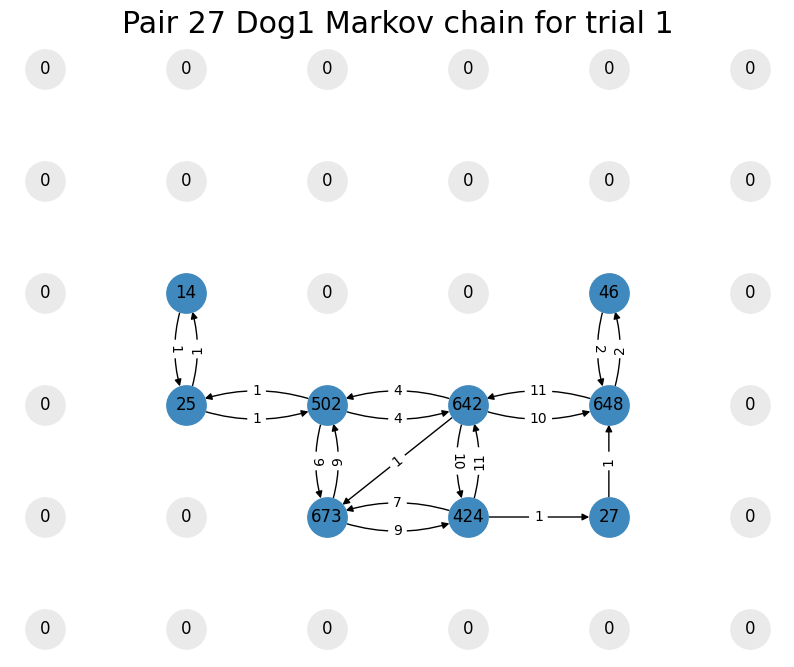

[((2, 1), (2, 1), np.float64(224.0)), ((2, 1), (2, 2), np.float64(4.0)), ((2, 1), (3, 1), np.float64(5.0)), ((3, 1), (2, 1), np.float64(4.0)), ((3, 1), (3, 1), np.float64(123.0)), ((3, 1), (3, 2), np.float64(3.0)), ((2, 2), (2, 1), np.float64(3.0)), ((2, 2), (2, 2), np.float64(860.0)), ((2, 2), (3, 2), np.float64(16.0)), ((3, 2), (2, 1), np.float64(1.0)), ((3, 2), (2, 2), np.float64(15.0)), ((3, 2), (3, 1), np.float64(2.0)), ((3, 2), (3, 2), np.float64(945.0)), ((3, 2), (3, 3), np.float64(7.0)), ((3, 2), (4, 2), np.float64(3.0)), ((4, 2), (3, 2), np.float64(2.0)), ((4, 2), (4, 2), np.float64(54.0)), ((4, 2), (4, 3), np.float64(3.0)), ((2, 3), (2, 3), np.float64(68.0)), ((2, 3), (2, 4), np.float64(1.0)), ((2, 3), (3, 3), np.float64(1.0)), ((3, 3), (2, 3), np.float64(2.0)), ((3, 3), (3, 2), np.float64(7.0)), ((3, 3), (3, 3), np.float64(460.0)), ((3, 3), (3, 4), np.float64(1.0)), ((3, 3), (4, 3), np.float64(4.0)), ((4, 3), (3, 2), np.float64(1.0)), ((4, 3), (3, 3), np.float64(4.0)), ((4, 

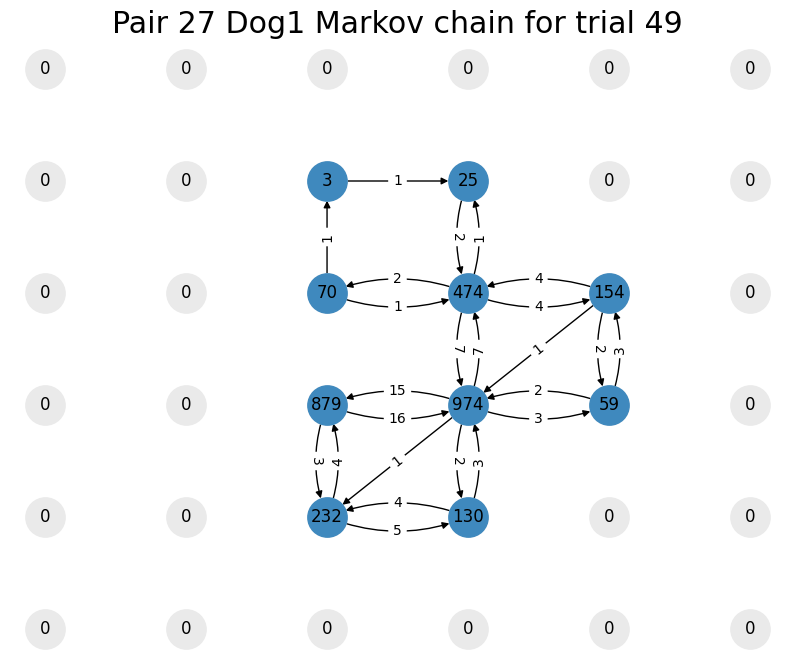

[((2, 1), (2, 1), np.float64(8.0)), ((2, 1), (2, 2), np.float64(1.0)), ((2, 1), (3, 1), np.float64(1.0)), ((3, 1), (2, 1), np.float64(1.0)), ((3, 1), (3, 1), np.float64(135.0)), ((3, 1), (3, 2), np.float64(1.0)), ((1, 2), (1, 2), np.float64(58.0)), ((1, 2), (2, 2), np.float64(3.0)), ((2, 2), (1, 2), np.float64(3.0)), ((2, 2), (2, 2), np.float64(1852.0)), ((2, 2), (2, 3), np.float64(1.0)), ((2, 2), (3, 2), np.float64(9.0)), ((3, 2), (2, 2), np.float64(9.0)), ((3, 2), (3, 1), np.float64(1.0)), ((3, 2), (3, 2), np.float64(722.0)), ((3, 2), (3, 3), np.float64(1.0)), ((3, 2), (4, 2), np.float64(2.0)), ((4, 2), (3, 2), np.float64(1.0)), ((4, 2), (4, 2), np.float64(79.0)), ((4, 2), (4, 3), np.float64(1.0)), ((2, 3), (2, 2), np.float64(1.0)), ((2, 3), (2, 3), np.float64(12.0)), ((3, 3), (3, 2), np.float64(2.0)), ((3, 3), (3, 3), np.float64(46.0)), ((4, 3), (3, 3), np.float64(1.0)), ((4, 3), (4, 3), np.float64(49.0))]
# of non-zero transition probabilities for trial first: 26
# of states visite

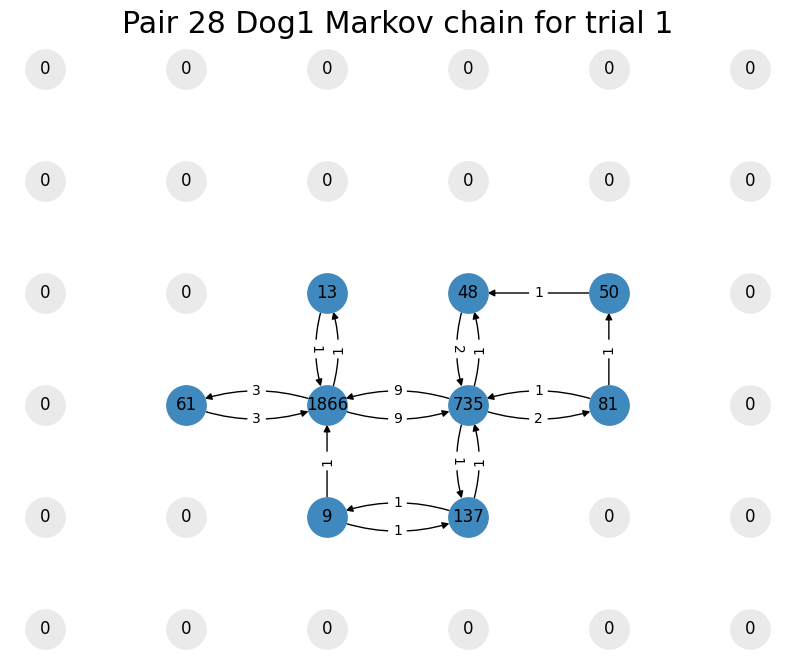

[((2, 1), (2, 1), np.float64(127.0)), ((2, 1), (2, 2), np.float64(1.0)), ((2, 1), (3, 1), np.float64(1.0)), ((3, 1), (3, 1), np.float64(6.0)), ((3, 1), (3, 2), np.float64(1.0)), ((2, 2), (2, 1), np.float64(1.0)), ((2, 2), (2, 2), np.float64(1690.0)), ((2, 2), (3, 2), np.float64(16.0)), ((3, 2), (2, 2), np.float64(16.0)), ((3, 2), (3, 2), np.float64(1063.0)), ((3, 2), (4, 2), np.float64(2.0)), ((4, 2), (3, 2), np.float64(2.0)), ((4, 2), (4, 2), np.float64(15.0)), ((4, 2), (4, 3), np.float64(1.0)), ((3, 3), (3, 3), np.float64(9.0)), ((3, 3), (4, 3), np.float64(1.0)), ((4, 3), (3, 3), np.float64(1.0)), ((4, 3), (4, 2), np.float64(1.0)), ((4, 3), (4, 3), np.float64(46.0))]
# of non-zero transition probabilities for trial last: 19
# of states visited for trial last: 7
Average non-zero transition probability: 157.89474
{(2, 1): np.float64(128.0), (4, 3): np.float64(48.0), (3, 1): np.float64(7.0), (4, 2): np.float64(18.0), (3, 3): np.float64(10.0), (2, 2): np.float64(1707.0), (3, 2): np.float

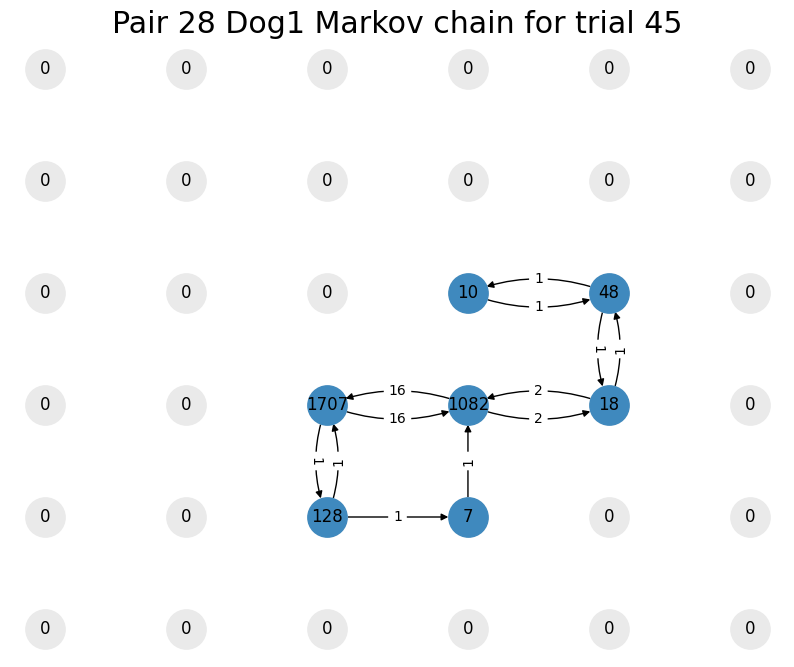

[((1, 1), (1, 1), np.float64(3.0)), ((1, 1), (1, 2), np.float64(1.0)), ((2, 1), (1, 1), np.float64(1.0)), ((2, 1), (1, 2), np.float64(1.0)), ((2, 1), (2, 1), np.float64(430.0)), ((2, 1), (2, 2), np.float64(25.0)), ((2, 1), (3, 1), np.float64(27.0)), ((2, 1), (3, 2), np.float64(1.0)), ((3, 1), (2, 1), np.float64(24.0)), ((3, 1), (2, 2), np.float64(1.0)), ((3, 1), (3, 1), np.float64(378.0)), ((3, 1), (3, 2), np.float64(26.0)), ((3, 1), (4, 1), np.float64(2.0)), ((3, 1), (4, 2), np.float64(1.0)), ((4, 1), (3, 1), np.float64(4.0)), ((4, 1), (4, 1), np.float64(16.0)), ((4, 1), (4, 2), np.float64(2.0)), ((1, 2), (1, 2), np.float64(248.0)), ((1, 2), (1, 3), np.float64(4.0)), ((1, 2), (2, 1), np.float64(1.0)), ((1, 2), (2, 2), np.float64(18.0)), ((2, 2), (1, 2), np.float64(17.0)), ((2, 2), (2, 1), np.float64(27.0)), ((2, 2), (2, 2), np.float64(497.0)), ((2, 2), (3, 2), np.float64(7.0)), ((3, 2), (2, 1), np.float64(3.0)), ((3, 2), (2, 2), np.float64(7.0)), ((3, 2), (3, 1), np.float64(22.0)), ((

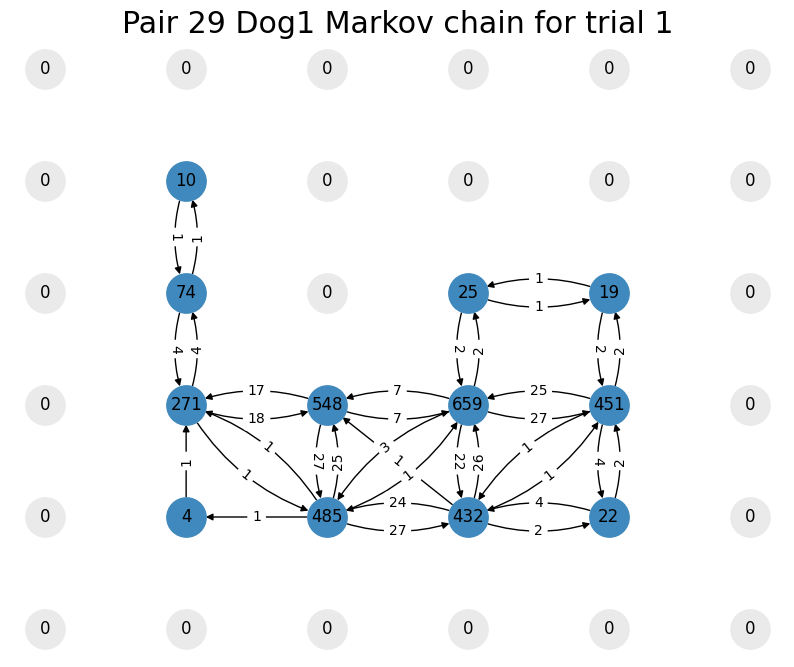

[((2, 1), (2, 1), np.float64(319.0)), ((2, 1), (2, 2), np.float64(33.0)), ((2, 1), (3, 1), np.float64(32.0)), ((2, 1), (3, 2), np.float64(4.0)), ((3, 1), (2, 1), np.float64(6.0)), ((3, 1), (3, 1), np.float64(100.0)), ((3, 1), (3, 2), np.float64(34.0)), ((1, 2), (1, 2), np.float64(72.0)), ((1, 2), (2, 2), np.float64(6.0)), ((1, 2), (2, 3), np.float64(1.0)), ((2, 2), (1, 2), np.float64(7.0)), ((2, 2), (2, 1), np.float64(50.0)), ((2, 2), (2, 2), np.float64(1010.0)), ((2, 2), (3, 2), np.float64(11.0)), ((3, 2), (2, 1), np.float64(12.0)), ((3, 2), (2, 2), np.float64(29.0)), ((3, 2), (3, 1), np.float64(8.0)), ((3, 2), (3, 2), np.float64(1173.0)), ((3, 2), (4, 2), np.float64(12.0)), ((4, 2), (3, 2), np.float64(12.0)), ((4, 2), (4, 2), np.float64(59.0)), ((2, 3), (2, 2), np.float64(1.0)), ((2, 3), (2, 3), np.float64(10.0))]
# of non-zero transition probabilities for trial last: 23
# of states visited for trial last: 7
Average non-zero transition probability: 130.47826
{(1, 2): np.float64(79.0)

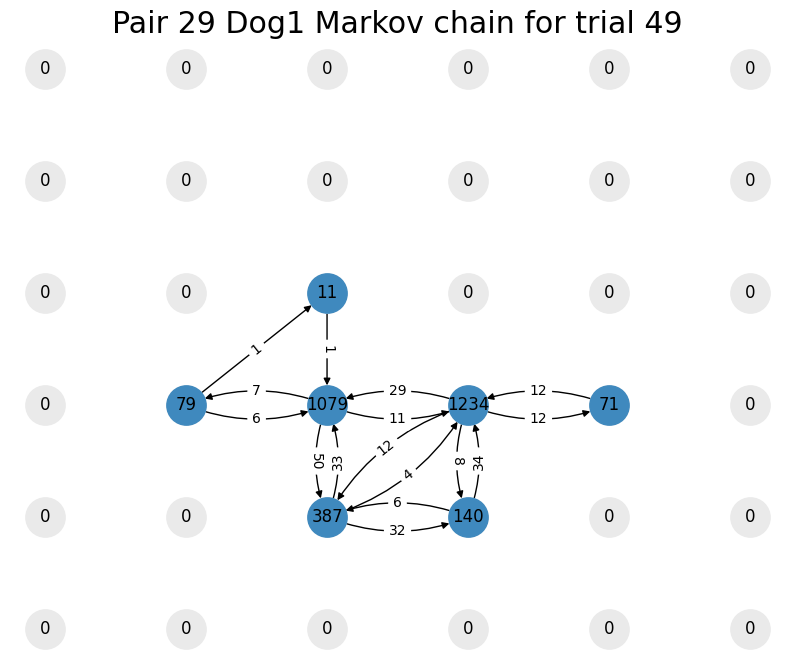

[((2, 1), (2, 1), np.float64(11.0)), ((2, 1), (2, 2), np.float64(1.0)), ((2, 1), (3, 1), np.float64(1.0)), ((3, 1), (3, 1), np.float64(43.0)), ((3, 1), (3, 2), np.float64(1.0)), ((1, 2), (1, 2), np.float64(47.0)), ((1, 2), (2, 2), np.float64(3.0)), ((2, 2), (2, 1), np.float64(1.0)), ((2, 2), (2, 2), np.float64(728.0)), ((2, 2), (2, 3), np.float64(6.0)), ((2, 2), (3, 2), np.float64(13.0)), ((3, 2), (2, 2), np.float64(15.0)), ((3, 2), (3, 2), np.float64(1183.0)), ((3, 2), (3, 3), np.float64(12.0)), ((4, 2), (3, 2), np.float64(2.0)), ((4, 2), (4, 2), np.float64(37.0)), ((1, 3), (1, 2), np.float64(3.0)), ((1, 3), (1, 3), np.float64(135.0)), ((1, 3), (1, 4), np.float64(1.0)), ((1, 3), (2, 3), np.float64(2.0)), ((2, 3), (1, 3), np.float64(5.0)), ((2, 3), (2, 2), np.float64(2.0)), ((2, 3), (2, 3), np.float64(134.0)), ((2, 3), (3, 3), np.float64(1.0)), ((3, 3), (3, 2), np.float64(11.0)), ((3, 3), (3, 3), np.float64(305.0)), ((3, 3), (3, 4), np.float64(2.0)), ((3, 3), (4, 3), np.float64(1.0)), 

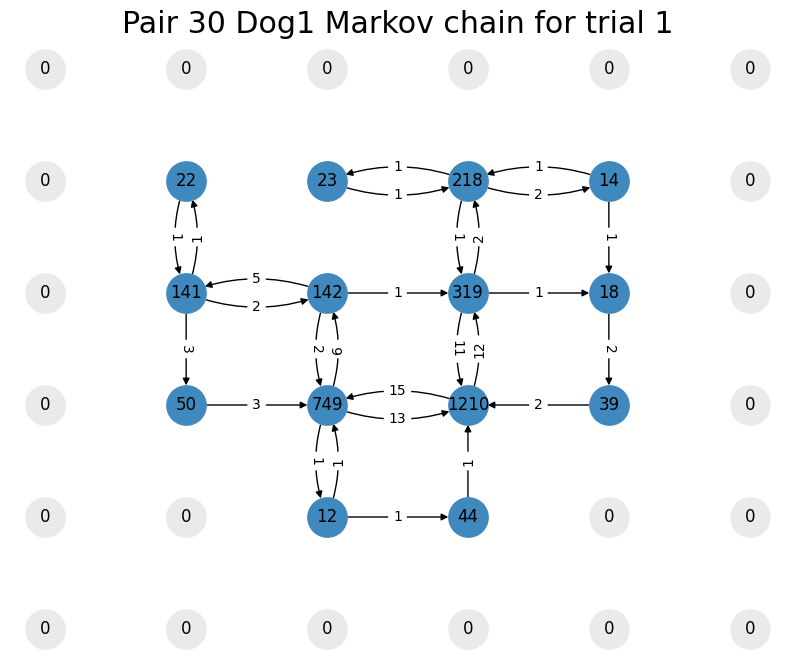

[((2, 1), (2, 1), np.float64(27.0)), ((2, 1), (2, 2), np.float64(1.0)), ((2, 1), (3, 1), np.float64(1.0)), ((3, 1), (3, 1), np.float64(4.0)), ((3, 1), (3, 2), np.float64(1.0)), ((1, 2), (1, 2), np.float64(18.0)), ((1, 2), (2, 2), np.float64(2.0)), ((2, 2), (1, 2), np.float64(2.0)), ((2, 2), (2, 1), np.float64(1.0)), ((2, 2), (2, 2), np.float64(1070.0)), ((2, 2), (2, 3), np.float64(1.0)), ((2, 2), (3, 2), np.float64(21.0)), ((3, 2), (2, 2), np.float64(21.0)), ((3, 2), (3, 2), np.float64(1487.0)), ((3, 2), (3, 3), np.float64(6.0)), ((3, 2), (4, 2), np.float64(2.0)), ((4, 2), (3, 2), np.float64(1.0)), ((4, 2), (4, 2), np.float64(35.0)), ((4, 2), (4, 3), np.float64(2.0)), ((2, 3), (2, 2), np.float64(1.0)), ((2, 3), (2, 3), np.float64(11.0)), ((3, 3), (3, 2), np.float64(7.0)), ((3, 3), (3, 3), np.float64(244.0)), ((3, 3), (4, 3), np.float64(1.0)), ((4, 3), (3, 3), np.float64(2.0)), ((4, 3), (4, 2), np.float64(1.0)), ((4, 3), (4, 3), np.float64(30.0))]
# of non-zero transition probabilities 

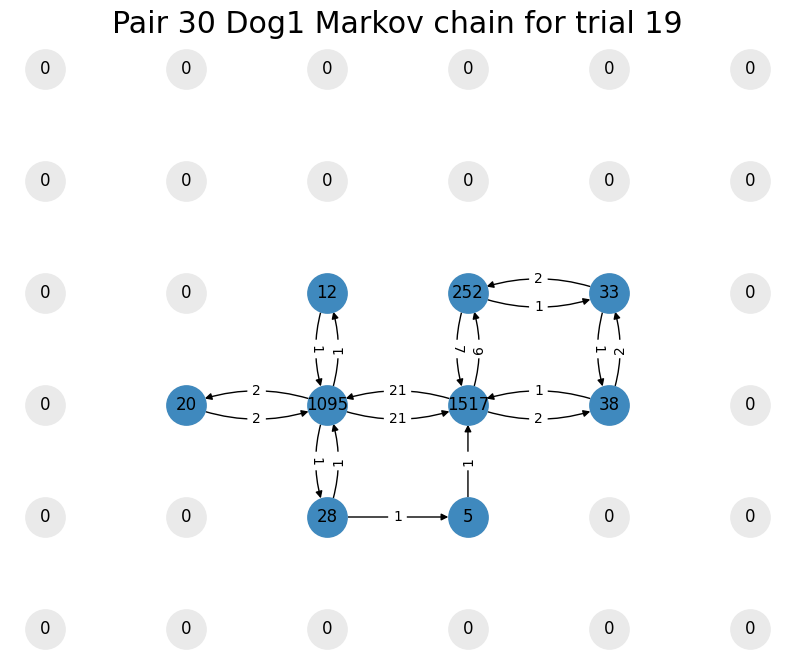

[((1, 1), (1, 1), np.float64(9.0)), ((1, 1), (1, 2), np.float64(1.0)), ((2, 1), (1, 1), np.float64(1.0)), ((2, 1), (2, 1), np.float64(215.0)), ((2, 1), (2, 2), np.float64(4.0)), ((2, 1), (3, 1), np.float64(3.0)), ((3, 1), (2, 1), np.float64(2.0)), ((3, 1), (3, 1), np.float64(70.0)), ((3, 1), (3, 2), np.float64(3.0)), ((1, 2), (1, 2), np.float64(178.0)), ((1, 2), (1, 3), np.float64(1.0)), ((1, 2), (2, 2), np.float64(3.0)), ((2, 2), (1, 2), np.float64(3.0)), ((2, 2), (2, 1), np.float64(2.0)), ((2, 2), (2, 2), np.float64(922.0)), ((2, 2), (2, 3), np.float64(3.0)), ((2, 2), (3, 2), np.float64(16.0)), ((3, 2), (2, 1), np.float64(3.0)), ((3, 2), (2, 2), np.float64(14.0)), ((3, 2), (3, 1), np.float64(2.0)), ((3, 2), (3, 2), np.float64(981.0)), ((3, 2), (3, 3), np.float64(6.0)), ((3, 2), (4, 2), np.float64(4.0)), ((4, 2), (3, 2), np.float64(3.0)), ((4, 2), (4, 2), np.float64(82.0)), ((4, 2), (4, 3), np.float64(2.0)), ((1, 3), (1, 3), np.float64(15.0)), ((1, 3), (2, 3), np.float64(1.0)), ((2, 3

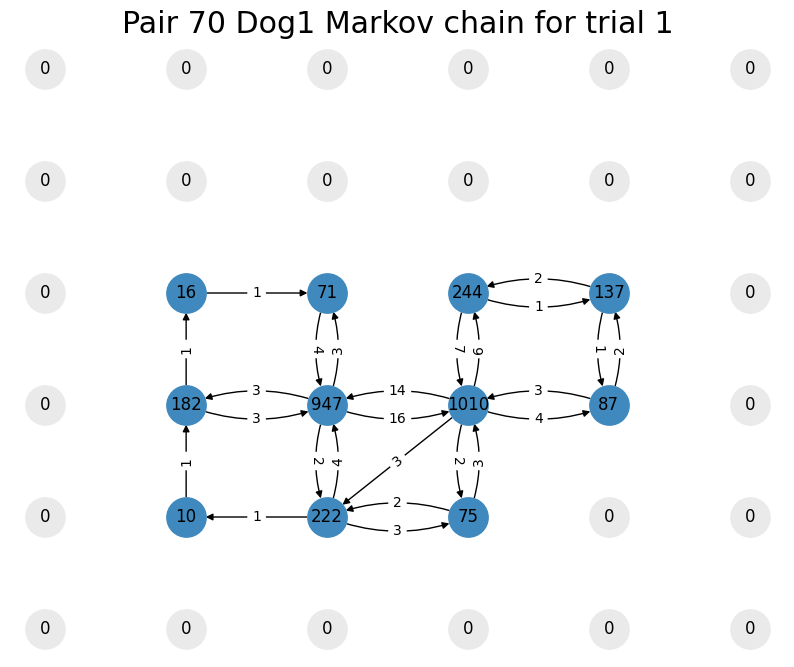

[((2, 1), (2, 1), np.float64(76.0)), ((2, 1), (2, 2), np.float64(1.0)), ((2, 1), (3, 1), np.float64(1.0)), ((3, 1), (2, 1), np.float64(1.0)), ((3, 1), (3, 1), np.float64(45.0)), ((3, 1), (3, 2), np.float64(1.0)), ((1, 2), (1, 2), np.float64(13.0)), ((1, 2), (2, 2), np.float64(1.0)), ((2, 2), (1, 2), np.float64(1.0)), ((2, 2), (2, 2), np.float64(1397.0)), ((2, 2), (2, 3), np.float64(5.0)), ((2, 2), (3, 2), np.float64(20.0)), ((3, 2), (2, 2), np.float64(19.0)), ((3, 2), (3, 1), np.float64(1.0)), ((3, 2), (3, 2), np.float64(948.0)), ((3, 2), (3, 3), np.float64(8.0)), ((3, 2), (4, 2), np.float64(1.0)), ((4, 2), (4, 2), np.float64(9.0)), ((4, 2), (4, 3), np.float64(1.0)), ((2, 3), (2, 2), np.float64(5.0)), ((2, 3), (2, 3), np.float64(130.0)), ((3, 3), (3, 2), np.float64(9.0)), ((3, 3), (3, 3), np.float64(245.0)), ((4, 3), (3, 3), np.float64(1.0)), ((4, 3), (4, 3), np.float64(61.0))]
# of non-zero transition probabilities for trial last: 25
# of states visited for trial last: 9
Average non-z

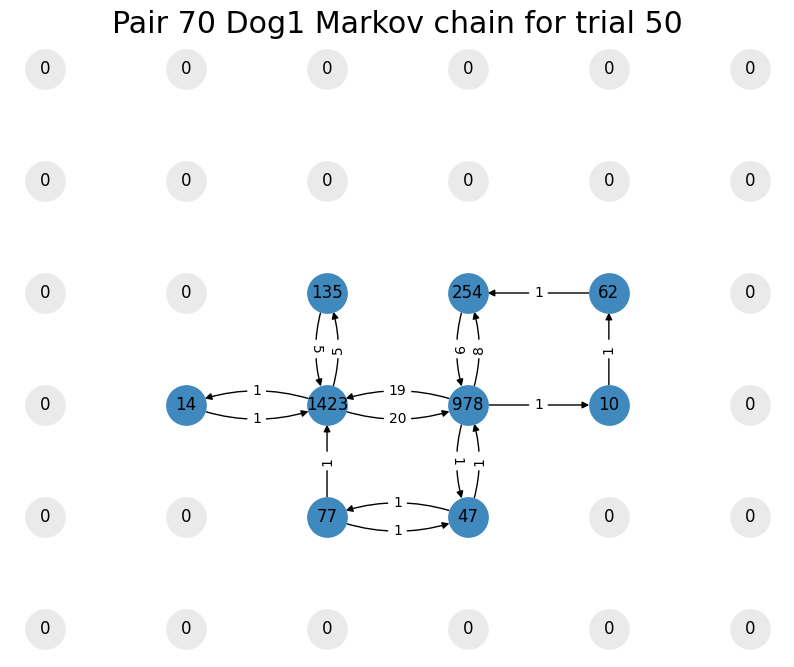

[((2, 1), (2, 1), np.float64(319.0)), ((2, 1), (2, 2), np.float64(5.0)), ((2, 1), (3, 1), np.float64(3.0)), ((3, 1), (2, 1), np.float64(4.0)), ((3, 1), (3, 1), np.float64(215.0)), ((3, 1), (3, 2), np.float64(3.0)), ((1, 2), (1, 2), np.float64(265.0)), ((1, 2), (1, 3), np.float64(2.0)), ((1, 2), (2, 2), np.float64(2.0)), ((2, 2), (1, 2), np.float64(3.0)), ((2, 2), (2, 1), np.float64(3.0)), ((2, 2), (2, 2), np.float64(529.0)), ((2, 2), (2, 3), np.float64(1.0)), ((2, 2), (3, 2), np.float64(7.0)), ((3, 2), (2, 2), np.float64(5.0)), ((3, 2), (3, 1), np.float64(5.0)), ((3, 2), (3, 2), np.float64(597.0)), ((3, 2), (3, 3), np.float64(4.0)), ((3, 2), (4, 2), np.float64(4.0)), ((4, 2), (3, 2), np.float64(2.0)), ((4, 2), (4, 2), np.float64(86.0)), ((4, 2), (4, 3), np.float64(3.0)), ((1, 3), (1, 2), np.float64(1.0)), ((1, 3), (1, 3), np.float64(28.0)), ((1, 3), (2, 3), np.float64(2.0)), ((2, 3), (1, 3), np.float64(1.0)), ((2, 3), (2, 2), np.float64(2.0)), ((2, 3), (2, 3), np.float64(103.0)), ((3, 

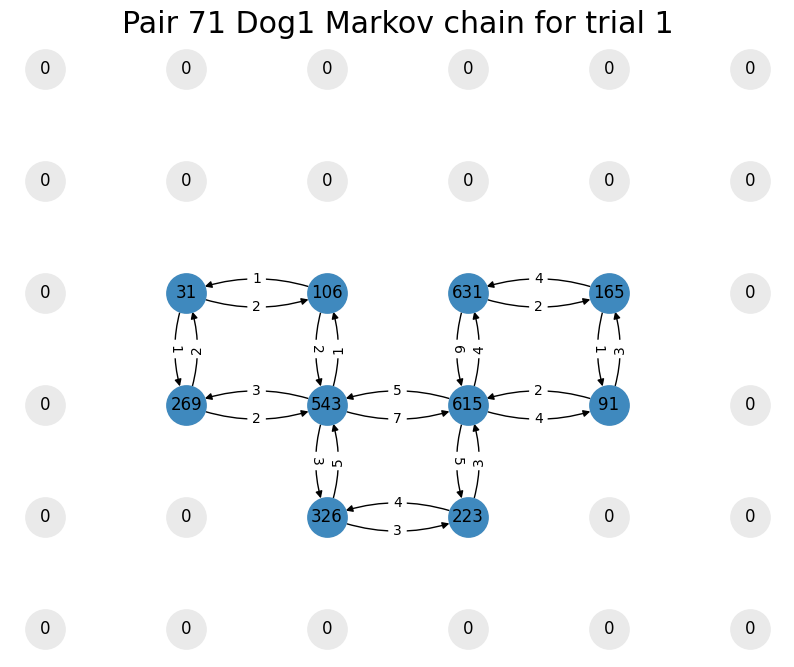

[((0, 1), (0, 1), np.float64(34.0)), ((0, 1), (1, 1), np.float64(2.0)), ((1, 1), (0, 1), np.float64(1.0)), ((1, 1), (1, 1), np.float64(95.0)), ((1, 1), (2, 1), np.float64(1.0)), ((2, 1), (2, 1), np.float64(111.0)), ((2, 1), (2, 2), np.float64(4.0)), ((2, 1), (3, 1), np.float64(6.0)), ((3, 1), (2, 1), np.float64(4.0)), ((3, 1), (3, 1), np.float64(174.0)), ((3, 1), (3, 2), np.float64(7.0)), ((0, 2), (0, 1), np.float64(1.0)), ((0, 2), (0, 2), np.float64(5.0)), ((1, 2), (0, 2), np.float64(1.0)), ((1, 2), (1, 2), np.float64(11.0)), ((2, 2), (2, 1), np.float64(4.0)), ((2, 2), (2, 2), np.float64(606.0)), ((2, 2), (2, 3), np.float64(1.0)), ((2, 2), (3, 2), np.float64(4.0)), ((3, 2), (2, 2), np.float64(4.0)), ((3, 2), (3, 1), np.float64(5.0)), ((3, 2), (3, 2), np.float64(1081.0)), ((3, 2), (3, 3), np.float64(7.0)), ((3, 2), (4, 2), np.float64(2.0)), ((4, 2), (3, 2), np.float64(1.0)), ((4, 2), (4, 2), np.float64(78.0)), ((4, 2), (4, 3), np.float64(1.0)), ((2, 3), (1, 2), np.float64(1.0)), ((2, 3

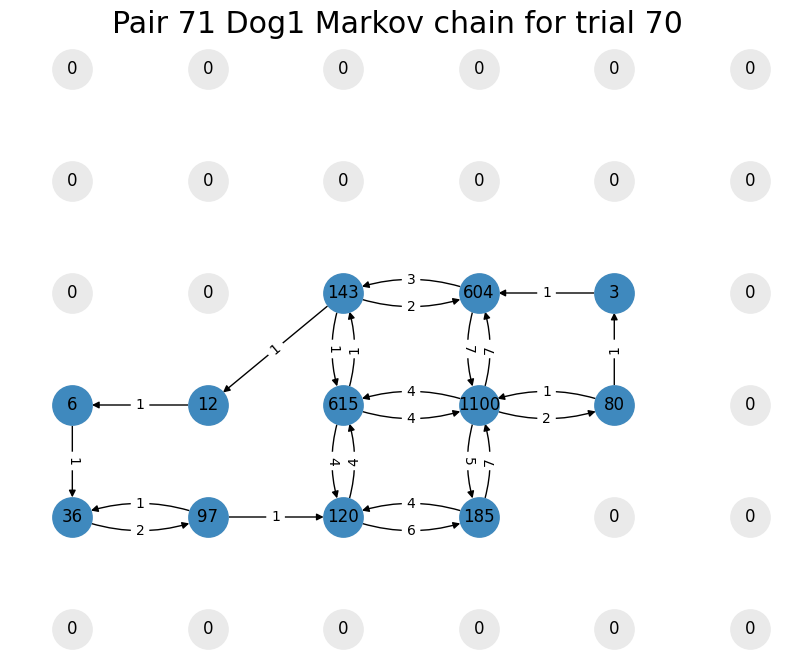

[((1, 1), (1, 2), np.float64(1.0)), ((2, 1), (1, 1), np.float64(1.0)), ((2, 1), (2, 1), np.float64(191.0)), ((2, 1), (2, 2), np.float64(3.0)), ((2, 1), (3, 1), np.float64(2.0)), ((3, 1), (2, 1), np.float64(2.0)), ((3, 1), (2, 2), np.float64(1.0)), ((3, 1), (3, 1), np.float64(56.0)), ((3, 1), (3, 2), np.float64(1.0)), ((1, 2), (1, 2), np.float64(484.0)), ((1, 2), (2, 2), np.float64(5.0)), ((2, 2), (1, 2), np.float64(4.0)), ((2, 2), (2, 1), np.float64(3.0)), ((2, 2), (2, 2), np.float64(1076.0)), ((2, 2), (3, 2), np.float64(11.0)), ((3, 2), (2, 2), np.float64(10.0)), ((3, 2), (3, 1), np.float64(2.0)), ((3, 2), (3, 2), np.float64(857.0)), ((3, 2), (3, 3), np.float64(1.0)), ((3, 2), (4, 2), np.float64(4.0)), ((4, 2), (3, 2), np.float64(4.0)), ((4, 2), (4, 2), np.float64(137.0)), ((4, 2), (4, 3), np.float64(1.0)), ((3, 3), (3, 2), np.float64(1.0)), ((3, 3), (3, 3), np.float64(18.0)), ((3, 3), (4, 3), np.float64(1.0)), ((4, 3), (3, 3), np.float64(1.0)), ((4, 3), (4, 2), np.float64(1.0)), ((4,

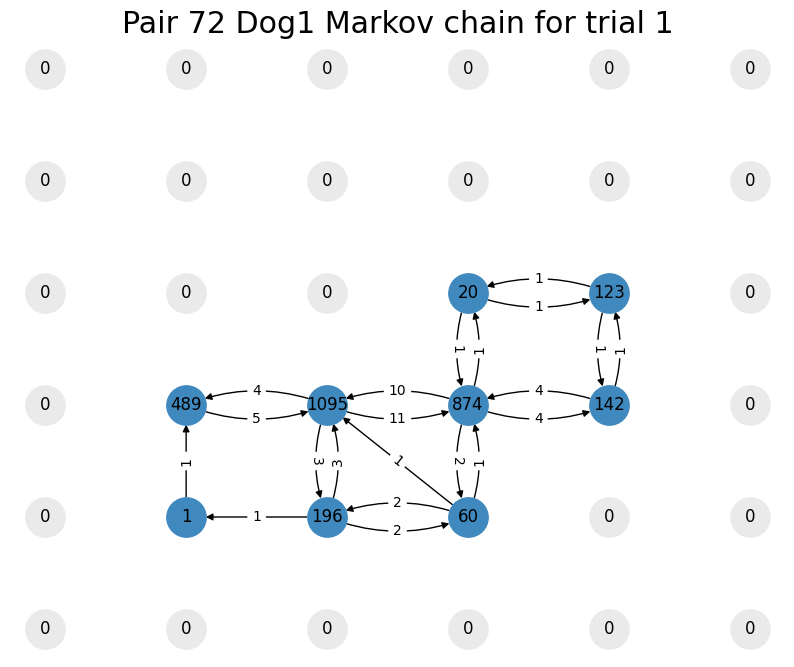

[((2, 1), (2, 1), np.float64(89.0)), ((2, 1), (2, 2), np.float64(1.0)), ((2, 1), (3, 1), np.float64(2.0)), ((3, 1), (3, 1), np.float64(15.0)), ((3, 1), (3, 2), np.float64(2.0)), ((1, 2), (1, 2), np.float64(38.0)), ((1, 2), (1, 3), np.float64(2.0)), ((1, 2), (2, 2), np.float64(1.0)), ((2, 2), (1, 2), np.float64(2.0)), ((2, 2), (2, 1), np.float64(2.0)), ((2, 2), (2, 2), np.float64(1264.0)), ((2, 2), (2, 3), np.float64(2.0)), ((2, 2), (3, 2), np.float64(15.0)), ((3, 2), (2, 2), np.float64(17.0)), ((3, 2), (3, 2), np.float64(1378.0)), ((3, 2), (3, 3), np.float64(2.0)), ((3, 2), (4, 2), np.float64(1.0)), ((4, 2), (3, 2), np.float64(1.0)), ((4, 2), (4, 2), np.float64(18.0)), ((4, 2), (4, 3), np.float64(1.0)), ((1, 3), (1, 2), np.float64(1.0)), ((1, 3), (1, 3), np.float64(44.0)), ((1, 3), (2, 3), np.float64(1.0)), ((2, 3), (2, 2), np.float64(3.0)), ((2, 3), (2, 3), np.float64(43.0)), ((3, 3), (3, 2), np.float64(2.0)), ((3, 3), (3, 3), np.float64(16.0)), ((4, 3), (4, 2), np.float64(1.0)), ((4,

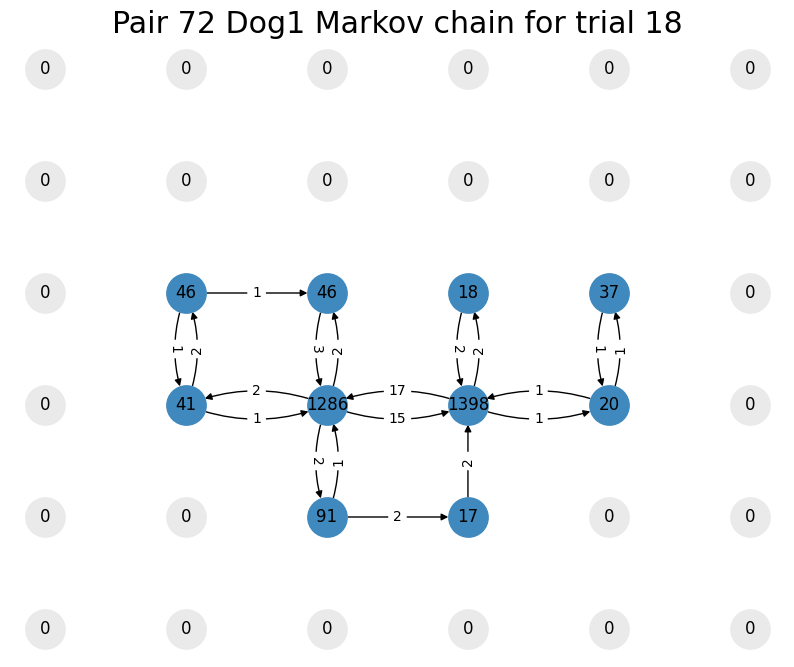

[((2, 1), (2, 1), np.float64(18.0)), ((2, 1), (2, 2), np.float64(4.0)), ((2, 1), (3, 1), np.float64(1.0)), ((3, 1), (2, 1), np.float64(1.0)), ((3, 1), (3, 1), np.float64(82.0)), ((3, 1), (3, 2), np.float64(1.0)), ((1, 2), (1, 2), np.float64(66.0)), ((1, 2), (1, 3), np.float64(2.0)), ((1, 2), (2, 2), np.float64(4.0)), ((1, 2), (2, 3), np.float64(1.0)), ((2, 2), (1, 2), np.float64(6.0)), ((2, 2), (2, 1), np.float64(3.0)), ((2, 2), (2, 2), np.float64(1207.0)), ((2, 2), (2, 3), np.float64(4.0)), ((2, 2), (3, 2), np.float64(16.0)), ((3, 2), (2, 2), np.float64(16.0)), ((3, 2), (3, 1), np.float64(1.0)), ((3, 2), (3, 2), np.float64(1171.0)), ((3, 2), (3, 3), np.float64(3.0)), ((3, 2), (4, 2), np.float64(4.0)), ((4, 2), (3, 2), np.float64(3.0)), ((4, 2), (4, 2), np.float64(48.0)), ((4, 2), (4, 3), np.float64(3.0)), ((1, 3), (1, 2), np.float64(1.0)), ((1, 3), (1, 3), np.float64(12.0)), ((1, 3), (2, 3), np.float64(2.0)), ((2, 3), (1, 3), np.float64(1.0)), ((2, 3), (2, 2), np.float64(5.0)), ((2, 3

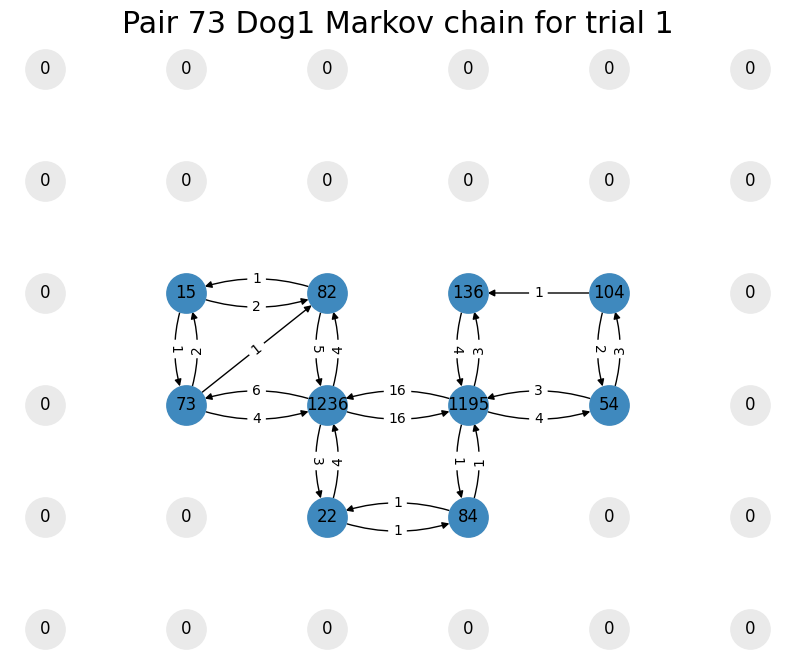

[((2, 1), (2, 1), np.float64(38.0)), ((2, 1), (2, 2), np.float64(1.0)), ((2, 1), (3, 1), np.float64(2.0)), ((3, 1), (2, 1), np.float64(1.0)), ((3, 1), (3, 1), np.float64(23.0)), ((3, 1), (3, 2), np.float64(2.0)), ((2, 2), (2, 1), np.float64(1.0)), ((2, 2), (2, 2), np.float64(1394.0)), ((2, 2), (2, 3), np.float64(3.0)), ((2, 2), (3, 2), np.float64(40.0)), ((3, 2), (2, 2), np.float64(40.0)), ((3, 2), (3, 1), np.float64(1.0)), ((3, 2), (3, 2), np.float64(1380.0)), ((3, 2), (3, 3), np.float64(6.0)), ((2, 3), (2, 2), np.float64(3.0)), ((2, 3), (2, 3), np.float64(12.0)), ((3, 3), (3, 2), np.float64(6.0)), ((3, 3), (3, 3), np.float64(47.0))]
# of non-zero transition probabilities for trial last: 18
# of states visited for trial last: 6
Average non-zero transition probability: 166.66667
{(2, 1): np.float64(40.0), (3, 1): np.float64(26.0), (2, 3): np.float64(15.0), (3, 3): np.float64(53.0), (2, 2): np.float64(1438.0), (3, 2): np.float64(1428.0)}


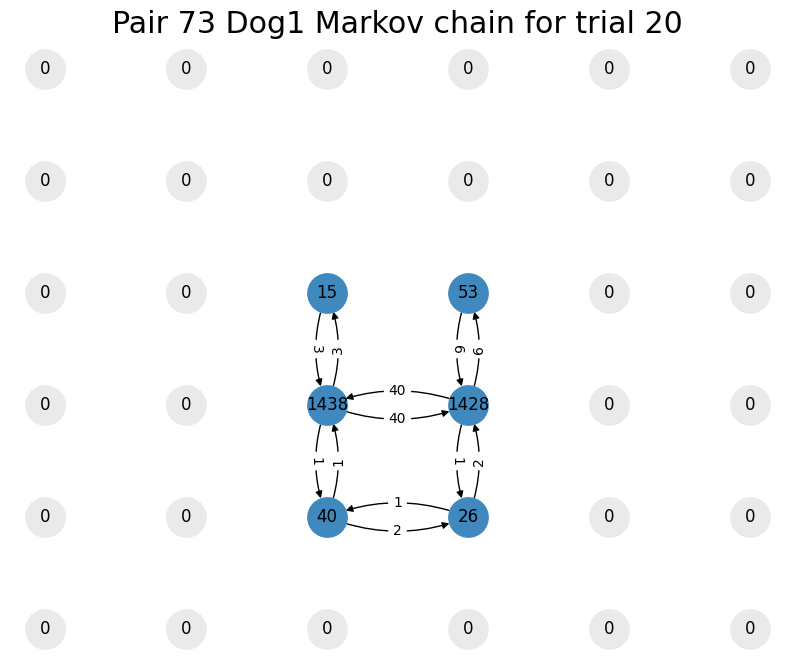

[((1, 1), (1, 2), np.float64(1.0)), ((2, 1), (1, 1), np.float64(1.0)), ((2, 1), (2, 1), np.float64(364.0)), ((2, 1), (2, 2), np.float64(4.0)), ((2, 1), (3, 1), np.float64(6.0)), ((3, 1), (2, 1), np.float64(6.0)), ((3, 1), (3, 1), np.float64(329.0)), ((3, 1), (3, 2), np.float64(5.0)), ((1, 2), (1, 2), np.float64(130.0)), ((1, 2), (1, 3), np.float64(1.0)), ((1, 2), (2, 2), np.float64(3.0)), ((2, 2), (1, 2), np.float64(2.0)), ((2, 2), (2, 1), np.float64(6.0)), ((2, 2), (2, 2), np.float64(794.0)), ((2, 2), (3, 2), np.float64(8.0)), ((3, 2), (2, 2), np.float64(9.0)), ((3, 2), (3, 1), np.float64(4.0)), ((3, 2), (3, 2), np.float64(1057.0)), ((3, 2), (3, 3), np.float64(1.0)), ((3, 2), (4, 2), np.float64(3.0)), ((4, 2), (3, 2), np.float64(2.0)), ((4, 2), (4, 2), np.float64(119.0)), ((4, 2), (4, 3), np.float64(2.0)), ((1, 3), (1, 2), np.float64(1.0)), ((1, 3), (1, 3), np.float64(23.0)), ((1, 3), (2, 3), np.float64(1.0)), ((2, 3), (1, 3), np.float64(1.0)), ((2, 3), (2, 3), np.float64(16.0)), ((3,

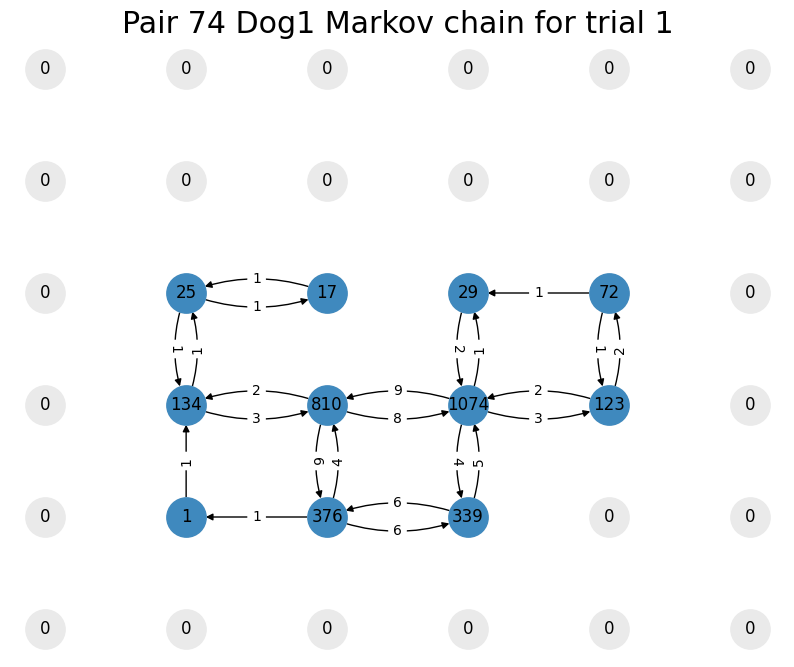

[((2, 1), (2, 1), np.float64(405.0)), ((2, 1), (2, 2), np.float64(7.0)), ((2, 1), (3, 1), np.float64(10.0)), ((3, 1), (2, 1), np.float64(7.0)), ((3, 1), (3, 1), np.float64(313.0)), ((3, 1), (3, 2), np.float64(10.0)), ((2, 2), (2, 1), np.float64(8.0)), ((2, 2), (2, 2), np.float64(750.0)), ((2, 2), (3, 2), np.float64(8.0)), ((3, 2), (2, 1), np.float64(1.0)), ((3, 2), (2, 2), np.float64(9.0)), ((3, 2), (3, 1), np.float64(7.0)), ((3, 2), (3, 2), np.float64(1465.0))]
# of non-zero transition probabilities for trial last: 13
# of states visited for trial last: 4
Average non-zero transition probability: 230.76923
{(3, 1): np.float64(330.0), (3, 2): np.float64(1483.0), (2, 1): np.float64(421.0), (2, 2): np.float64(766.0)}


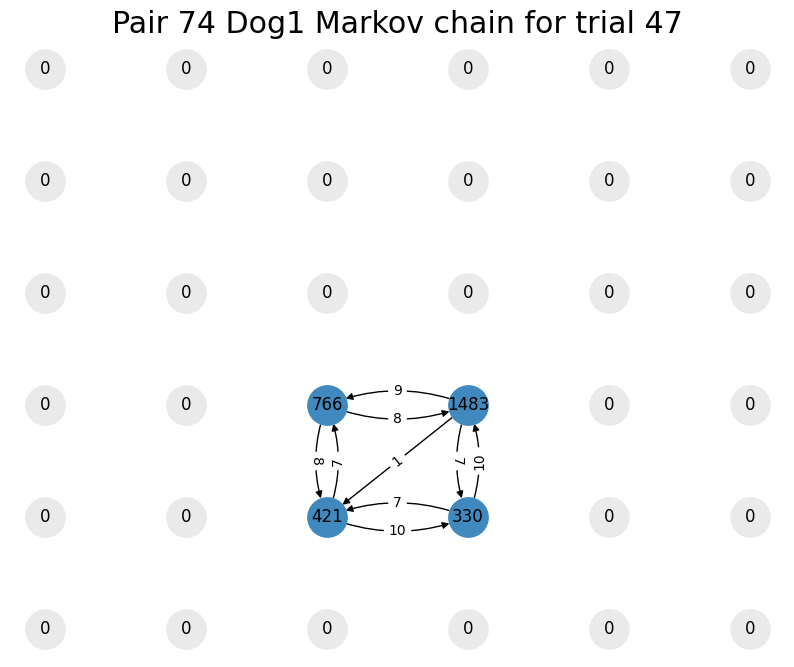

[((2, 1), (2, 1), np.float64(126.0)), ((2, 1), (2, 2), np.float64(3.0)), ((2, 1), (3, 1), np.float64(2.0)), ((3, 1), (2, 1), np.float64(1.0)), ((3, 1), (3, 1), np.float64(17.0)), ((3, 1), (3, 2), np.float64(2.0)), ((1, 2), (1, 2), np.float64(124.0)), ((1, 2), (1, 3), np.float64(1.0)), ((1, 2), (2, 2), np.float64(3.0)), ((1, 2), (2, 3), np.float64(1.0)), ((2, 2), (1, 2), np.float64(5.0)), ((2, 2), (2, 1), np.float64(3.0)), ((2, 2), (2, 2), np.float64(903.0)), ((2, 2), (3, 2), np.float64(9.0)), ((3, 2), (2, 2), np.float64(10.0)), ((3, 2), (3, 1), np.float64(1.0)), ((3, 2), (3, 2), np.float64(1183.0)), ((3, 2), (3, 3), np.float64(4.0)), ((3, 2), (4, 2), np.float64(3.0)), ((4, 2), (4, 2), np.float64(8.0)), ((4, 2), (4, 3), np.float64(3.0)), ((1, 3), (1, 3), np.float64(13.0)), ((1, 3), (2, 3), np.float64(1.0)), ((2, 3), (2, 2), np.float64(2.0)), ((2, 3), (2, 3), np.float64(82.0)), ((3, 3), (3, 2), np.float64(6.0)), ((3, 3), (3, 3), np.float64(340.0)), ((3, 3), (4, 3), np.float64(3.0)), ((4,

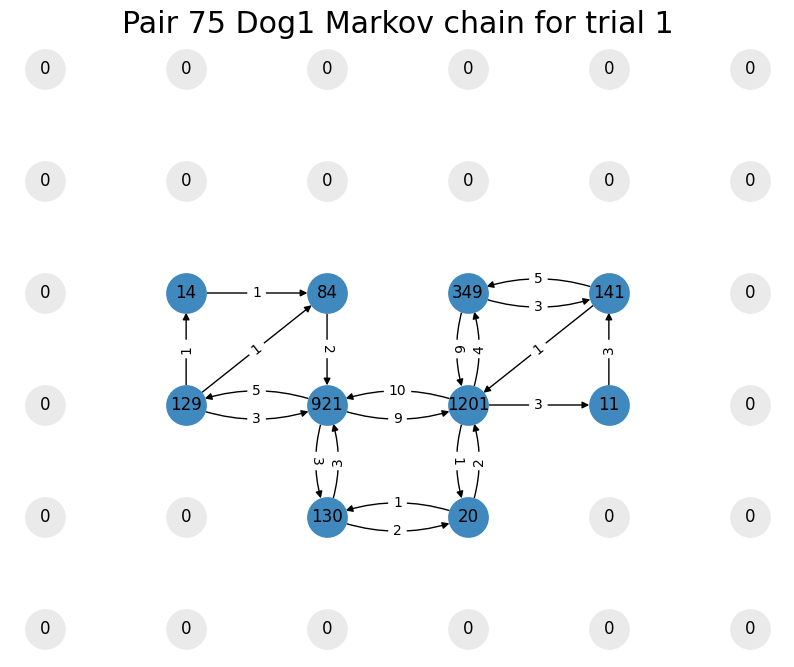

[((2, 1), (2, 1), np.float64(121.0)), ((2, 1), (2, 2), np.float64(6.0)), ((2, 1), (3, 1), np.float64(1.0)), ((3, 1), (3, 1), np.float64(27.0)), ((3, 1), (3, 2), np.float64(2.0)), ((2, 2), (2, 1), np.float64(6.0)), ((2, 2), (2, 2), np.float64(809.0)), ((2, 2), (3, 2), np.float64(21.0)), ((3, 2), (2, 2), np.float64(21.0)), ((3, 2), (3, 1), np.float64(1.0)), ((3, 2), (3, 2), np.float64(1399.0)), ((3, 2), (3, 3), np.float64(10.0)), ((3, 2), (4, 2), np.float64(6.0)), ((4, 2), (3, 2), np.float64(6.0)), ((4, 2), (4, 2), np.float64(154.0)), ((4, 2), (4, 3), np.float64(3.0)), ((4, 2), (5, 2), np.float64(1.0)), ((5, 2), (5, 2), np.float64(5.0)), ((5, 2), (5, 3), np.float64(1.0)), ((3, 3), (3, 2), np.float64(10.0)), ((3, 3), (3, 3), np.float64(240.0)), ((4, 3), (4, 2), np.float64(4.0)), ((4, 3), (4, 3), np.float64(103.0)), ((4, 3), (5, 3), np.float64(1.0)), ((5, 3), (4, 3), np.float64(2.0)), ((5, 3), (5, 3), np.float64(41.0))]
# of non-zero transition probabilities for trial last: 26
# of states 

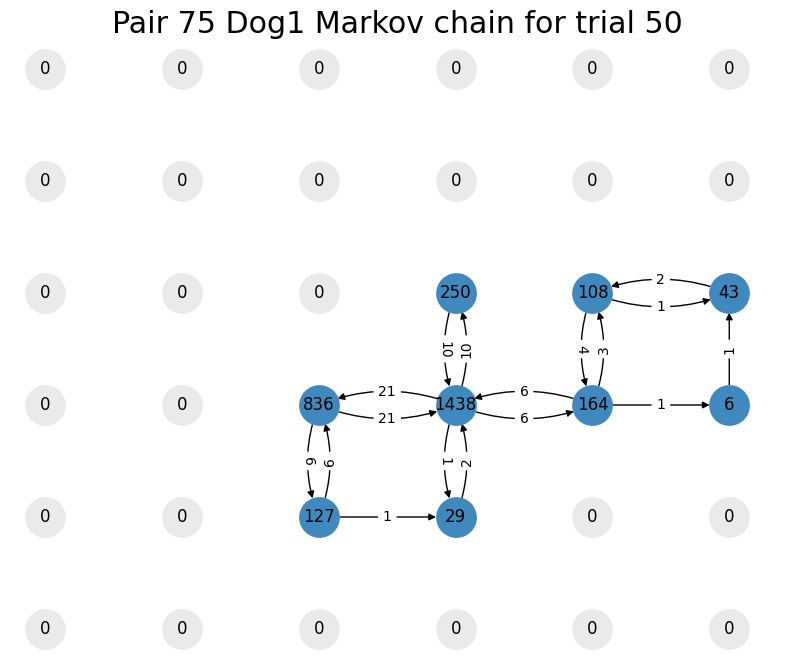

[((2, 1), (2, 1), np.float64(103.0)), ((2, 1), (3, 1), np.float64(1.0)), ((2, 1), (3, 2), np.float64(1.0)), ((3, 1), (3, 1), np.float64(11.0)), ((3, 1), (3, 2), np.float64(2.0)), ((1, 2), (1, 2), np.float64(114.0)), ((1, 2), (1, 3), np.float64(7.0)), ((1, 2), (2, 2), np.float64(4.0)), ((2, 2), (1, 2), np.float64(7.0)), ((2, 2), (2, 1), np.float64(1.0)), ((2, 2), (2, 2), np.float64(1070.0)), ((2, 2), (2, 3), np.float64(7.0)), ((2, 2), (3, 2), np.float64(18.0)), ((3, 2), (2, 2), np.float64(19.0)), ((3, 2), (3, 1), np.float64(1.0)), ((3, 2), (3, 2), np.float64(897.0)), ((3, 2), (3, 3), np.float64(11.0)), ((3, 2), (4, 2), np.float64(4.0)), ((3, 2), (4, 3), np.float64(2.0)), ((4, 2), (3, 2), np.float64(4.0)), ((4, 2), (4, 2), np.float64(39.0)), ((4, 2), (4, 3), np.float64(1.0)), ((1, 3), (1, 2), np.float64(4.0)), ((1, 3), (1, 3), np.float64(207.0)), ((1, 3), (1, 4), np.float64(1.0)), ((1, 3), (2, 2), np.float64(1.0)), ((1, 3), (2, 3), np.float64(2.0)), ((2, 3), (1, 3), np.float64(1.0)), ((2

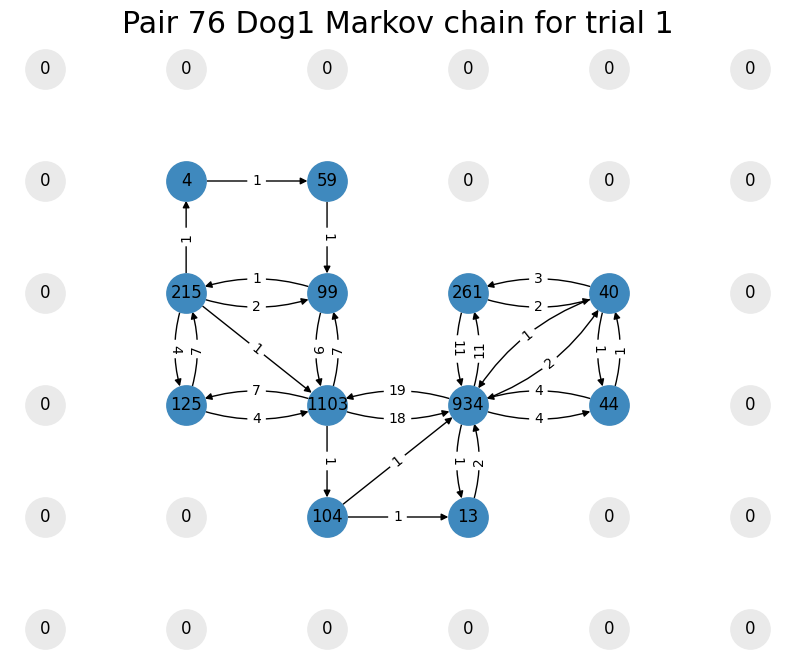

[((2, 1), (2, 1), np.float64(42.0)), ((2, 1), (2, 2), np.float64(1.0)), ((1, 2), (1, 2), np.float64(25.0)), ((1, 2), (1, 3), np.float64(3.0)), ((1, 2), (2, 2), np.float64(4.0)), ((2, 2), (1, 2), np.float64(3.0)), ((2, 2), (2, 2), np.float64(1103.0)), ((2, 2), (2, 3), np.float64(24.0)), ((2, 2), (3, 2), np.float64(27.0)), ((3, 2), (2, 2), np.float64(26.0)), ((3, 2), (3, 2), np.float64(912.0)), ((3, 2), (3, 3), np.float64(24.0)), ((3, 2), (4, 2), np.float64(1.0)), ((4, 2), (3, 2), np.float64(1.0)), ((4, 2), (4, 2), np.float64(3.0)), ((4, 2), (4, 3), np.float64(1.0)), ((1, 3), (1, 2), np.float64(4.0)), ((1, 3), (1, 3), np.float64(56.0)), ((2, 3), (1, 3), np.float64(1.0)), ((2, 3), (2, 2), np.float64(23.0)), ((2, 3), (2, 3), np.float64(313.0)), ((3, 3), (3, 2), np.float64(23.0)), ((3, 3), (3, 3), np.float64(324.0)), ((3, 3), (4, 3), np.float64(3.0)), ((4, 3), (3, 2), np.float64(1.0)), ((4, 3), (3, 3), np.float64(2.0)), ((4, 3), (4, 2), np.float64(1.0)), ((4, 3), (4, 3), np.float64(49.0))]


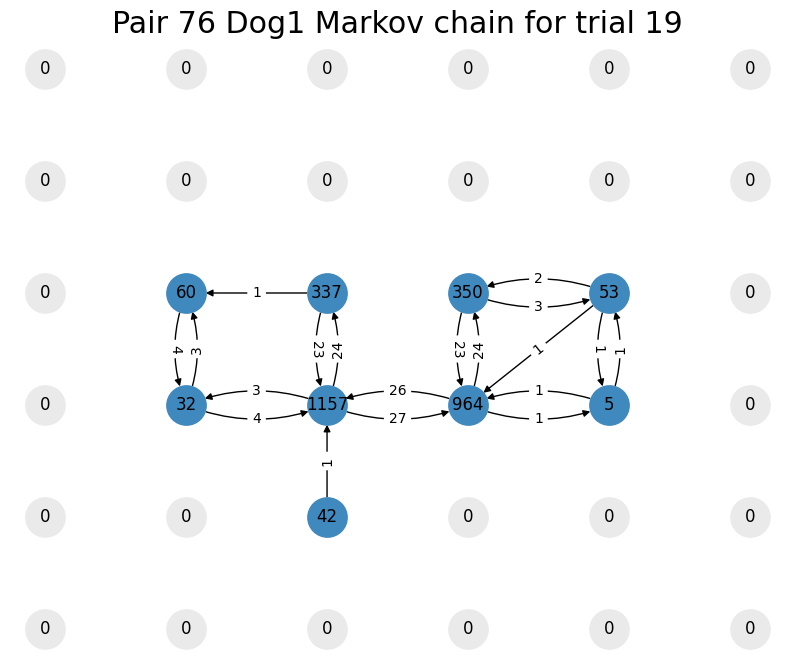

[((2, 1), (2, 1), np.float64(55.0)), ((2, 1), (2, 2), np.float64(2.0)), ((2, 1), (3, 1), np.float64(1.0)), ((3, 1), (3, 1), np.float64(35.0)), ((3, 1), (3, 2), np.float64(3.0)), ((1, 2), (1, 2), np.float64(82.0)), ((1, 2), (1, 3), np.float64(1.0)), ((1, 2), (2, 2), np.float64(1.0)), ((2, 2), (1, 2), np.float64(1.0)), ((2, 2), (2, 1), np.float64(2.0)), ((2, 2), (2, 2), np.float64(1243.0)), ((2, 2), (2, 3), np.float64(4.0)), ((2, 2), (3, 2), np.float64(21.0)), ((3, 2), (2, 2), np.float64(22.0)), ((3, 2), (3, 1), np.float64(2.0)), ((3, 2), (3, 2), np.float64(1160.0)), ((3, 2), (3, 3), np.float64(2.0)), ((3, 2), (4, 2), np.float64(4.0)), ((4, 2), (3, 2), np.float64(2.0)), ((4, 2), (4, 2), np.float64(58.0)), ((4, 2), (4, 3), np.float64(4.0)), ((1, 3), (1, 2), np.float64(1.0)), ((1, 3), (1, 3), np.float64(33.0)), ((2, 3), (2, 2), np.float64(3.0)), ((2, 3), (2, 3), np.float64(54.0)), ((3, 3), (3, 2), np.float64(4.0)), ((3, 3), (3, 3), np.float64(131.0)), ((3, 3), (4, 3), np.float64(1.0)), ((4

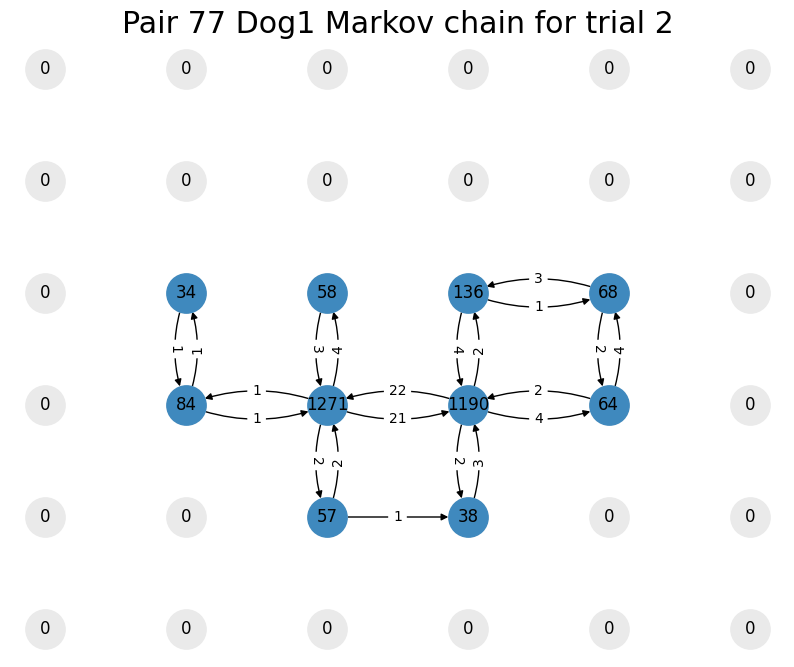

[((2, 1), (2, 1), np.float64(37.0)), ((2, 1), (2, 2), np.float64(1.0)), ((1, 2), (1, 2), np.float64(94.0)), ((1, 2), (1, 3), np.float64(2.0)), ((1, 2), (2, 2), np.float64(4.0)), ((2, 2), (1, 2), np.float64(5.0)), ((2, 2), (2, 2), np.float64(1422.0)), ((2, 2), (2, 3), np.float64(1.0)), ((2, 2), (3, 2), np.float64(41.0)), ((3, 2), (2, 2), np.float64(40.0)), ((3, 2), (3, 2), np.float64(1299.0)), ((3, 2), (4, 2), np.float64(1.0)), ((4, 2), (3, 2), np.float64(1.0)), ((4, 2), (4, 2), np.float64(3.0)), ((1, 3), (1, 2), np.float64(1.0)), ((1, 3), (1, 3), np.float64(25.0)), ((1, 3), (2, 3), np.float64(1.0)), ((2, 3), (2, 2), np.float64(2.0)), ((2, 3), (2, 3), np.float64(20.0))]
# of non-zero transition probabilities for trial last: 19
# of states visited for trial last: 7
Average non-zero transition probability: 157.89474
{(1, 2): np.float64(100.0), (2, 1): np.float64(37.0), (4, 2): np.float64(4.0), (2, 3): np.float64(22.0), (2, 2): np.float64(1469.0), (3, 2): np.float64(1341.0), (1, 3): np.flo

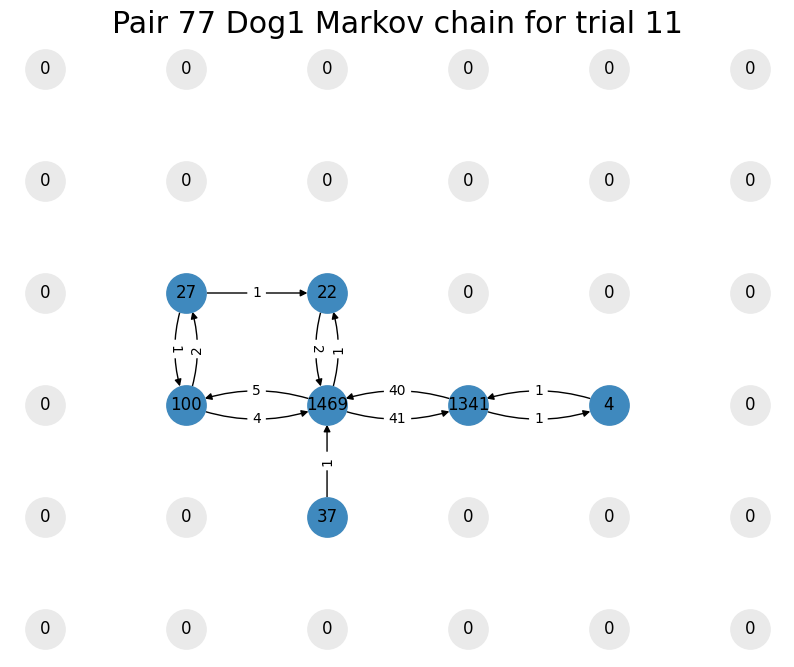

[((1, 1), (1, 1), np.float64(6.0)), ((1, 1), (1, 2), np.float64(1.0)), ((2, 1), (1, 1), np.float64(1.0)), ((2, 1), (2, 1), np.float64(62.0)), ((2, 1), (2, 2), np.float64(2.0)), ((2, 1), (3, 1), np.float64(1.0)), ((3, 1), (2, 1), np.float64(1.0)), ((3, 1), (3, 1), np.float64(135.0)), ((3, 1), (3, 2), np.float64(3.0)), ((1, 2), (1, 2), np.float64(210.0)), ((1, 2), (1, 3), np.float64(3.0)), ((1, 2), (2, 2), np.float64(6.0)), ((2, 2), (1, 2), np.float64(8.0)), ((2, 2), (2, 1), np.float64(2.0)), ((2, 2), (2, 2), np.float64(778.0)), ((2, 2), (2, 3), np.float64(2.0)), ((2, 2), (3, 2), np.float64(14.0)), ((3, 2), (2, 2), np.float64(13.0)), ((3, 2), (3, 1), np.float64(3.0)), ((3, 2), (3, 2), np.float64(837.0)), ((3, 2), (3, 3), np.float64(6.0)), ((3, 2), (4, 2), np.float64(2.0)), ((3, 2), (4, 3), np.float64(1.0)), ((4, 2), (3, 2), np.float64(1.0)), ((4, 2), (4, 2), np.float64(33.0)), ((4, 2), (4, 3), np.float64(2.0)), ((1, 3), (1, 3), np.float64(44.0)), ((1, 3), (2, 3), np.float64(4.0)), ((2, 3

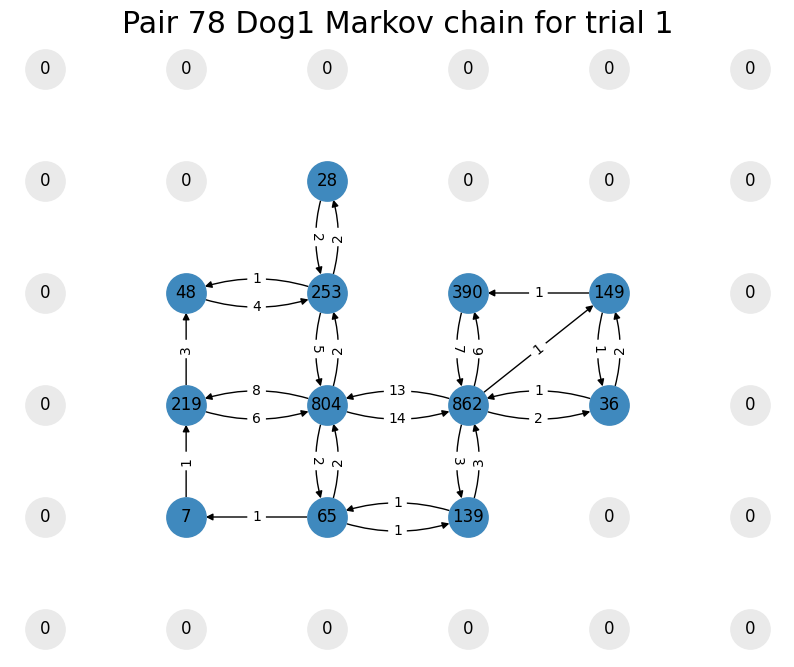

[((2, 1), (2, 1), np.float64(101.0)), ((2, 1), (2, 2), np.float64(2.0)), ((1, 2), (1, 2), np.float64(45.0)), ((1, 2), (1, 3), np.float64(1.0)), ((1, 2), (2, 2), np.float64(4.0)), ((2, 2), (1, 2), np.float64(5.0)), ((2, 2), (2, 2), np.float64(1252.0)), ((2, 2), (2, 3), np.float64(23.0)), ((2, 2), (3, 2), np.float64(57.0)), ((3, 2), (2, 1), np.float64(1.0)), ((3, 2), (2, 2), np.float64(55.0)), ((3, 2), (3, 2), np.float64(1041.0)), ((3, 2), (3, 3), np.float64(29.0)), ((1, 3), (1, 3), np.float64(15.0)), ((1, 3), (2, 2), np.float64(1.0)), ((1, 3), (2, 3), np.float64(1.0)), ((2, 3), (1, 3), np.float64(1.0)), ((2, 3), (2, 2), np.float64(23.0)), ((2, 3), (2, 3), np.float64(123.0)), ((3, 3), (3, 2), np.float64(29.0)), ((3, 3), (3, 3), np.float64(192.0))]
# of non-zero transition probabilities for trial last: 21
# of states visited for trial last: 7
Average non-zero transition probability: 142.90476
{(1, 2): np.float64(50.0), (2, 1): np.float64(102.0), (2, 3): np.float64(147.0), (3, 3): np.float

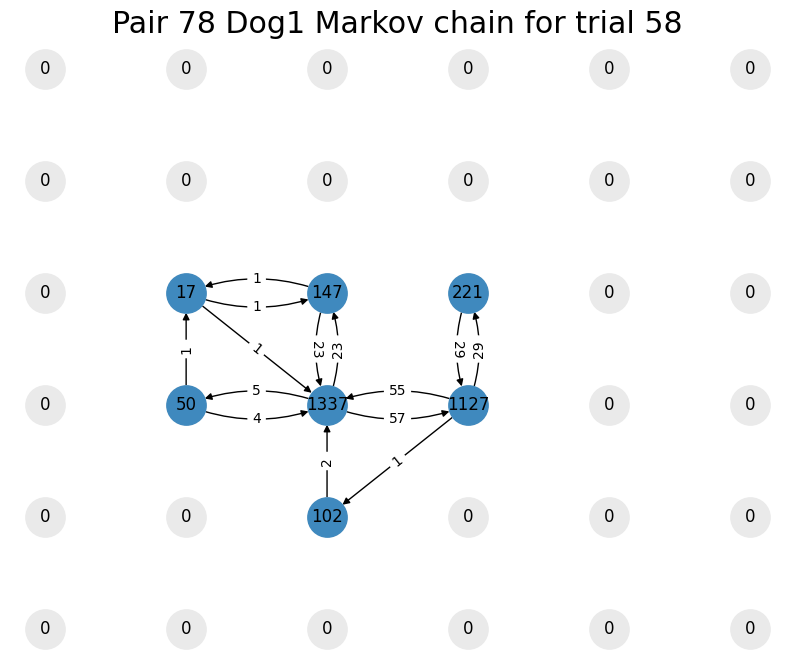

[((2, 1), (2, 1), np.float64(344.0)), ((2, 1), (2, 2), np.float64(8.0)), ((2, 1), (3, 1), np.float64(2.0)), ((3, 1), (2, 1), np.float64(5.0)), ((3, 1), (2, 2), np.float64(1.0)), ((3, 1), (3, 1), np.float64(152.0)), ((3, 1), (3, 2), np.float64(2.0)), ((4, 1), (3, 1), np.float64(1.0)), ((4, 1), (4, 1), np.float64(3.0)), ((1, 2), (1, 2), np.float64(68.0)), ((1, 2), (1, 3), np.float64(4.0)), ((1, 2), (2, 2), np.float64(1.0)), ((2, 2), (1, 2), np.float64(3.0)), ((2, 2), (2, 1), np.float64(3.0)), ((2, 2), (2, 2), np.float64(429.0)), ((2, 2), (2, 3), np.float64(1.0)), ((2, 2), (3, 2), np.float64(5.0)), ((3, 2), (2, 1), np.float64(1.0)), ((3, 2), (3, 1), np.float64(5.0)), ((3, 2), (3, 2), np.float64(639.0)), ((3, 2), (3, 3), np.float64(3.0)), ((3, 2), (4, 2), np.float64(5.0)), ((4, 2), (3, 2), np.float64(3.0)), ((4, 2), (3, 3), np.float64(1.0)), ((4, 2), (4, 1), np.float64(1.0)), ((4, 2), (4, 2), np.float64(82.0)), ((4, 2), (4, 3), np.float64(4.0)), ((4, 2), (5, 2), np.float64(1.0)), ((5, 2), 

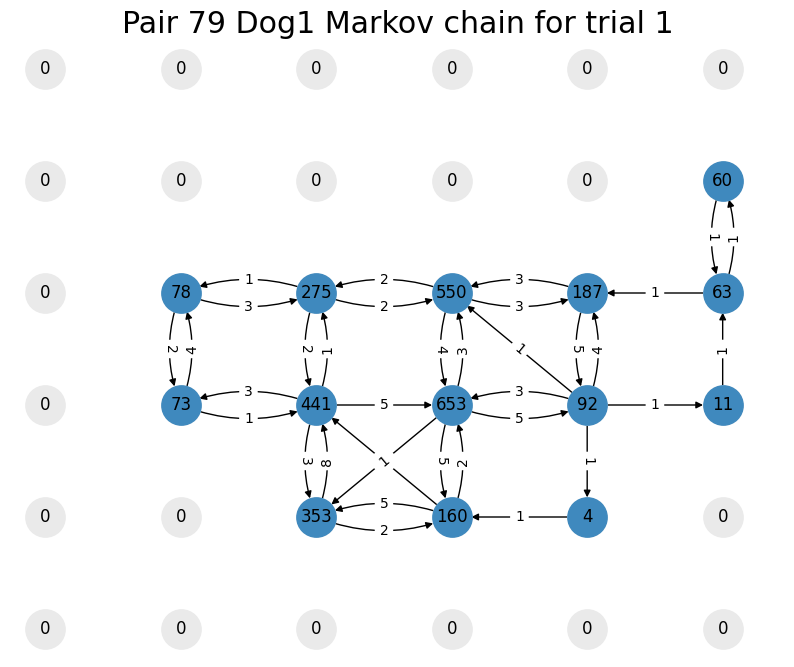

[((2, 1), (2, 1), np.float64(266.0)), ((2, 1), (2, 2), np.float64(17.0)), ((2, 1), (3, 1), np.float64(5.0)), ((3, 1), (2, 1), np.float64(9.0)), ((3, 1), (3, 1), np.float64(46.0)), ((3, 1), (3, 2), np.float64(5.0)), ((1, 2), (1, 2), np.float64(285.0)), ((1, 2), (1, 3), np.float64(4.0)), ((1, 2), (2, 2), np.float64(13.0)), ((2, 2), (1, 2), np.float64(12.0)), ((2, 2), (2, 1), np.float64(9.0)), ((2, 2), (2, 2), np.float64(938.0)), ((2, 2), (2, 3), np.float64(6.0)), ((2, 2), (3, 2), np.float64(14.0)), ((3, 2), (2, 1), np.float64(3.0)), ((3, 2), (2, 2), np.float64(7.0)), ((3, 2), (3, 1), np.float64(9.0)), ((3, 2), (3, 2), np.float64(645.0)), ((3, 2), (3, 3), np.float64(9.0)), ((3, 2), (4, 2), np.float64(2.0)), ((4, 2), (3, 2), np.float64(2.0)), ((4, 2), (4, 2), np.float64(13.0)), ((4, 2), (4, 3), np.float64(1.0)), ((1, 3), (1, 2), np.float64(4.0)), ((1, 3), (1, 3), np.float64(64.0)), ((1, 3), (2, 3), np.float64(2.0)), ((2, 3), (1, 2), np.float64(1.0)), ((2, 3), (1, 3), np.float64(2.0)), ((2,

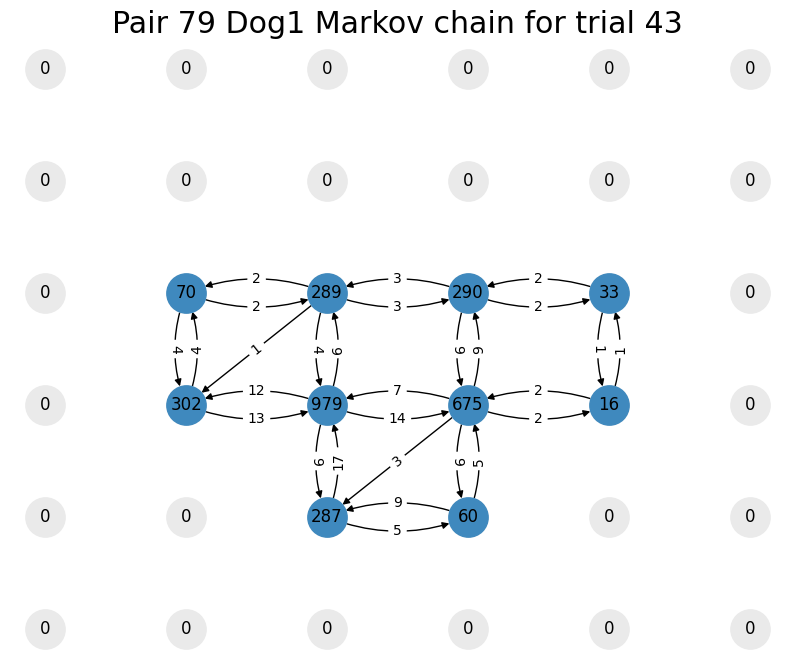

[((1, 1), (1, 1), np.float64(36.0)), ((1, 1), (1, 2), np.float64(2.0)), ((2, 1), (2, 1), np.float64(317.0)), ((2, 1), (2, 2), np.float64(7.0)), ((2, 1), (3, 1), np.float64(5.0)), ((3, 1), (2, 1), np.float64(6.0)), ((3, 1), (3, 1), np.float64(189.0)), ((1, 2), (1, 1), np.float64(2.0)), ((1, 2), (1, 2), np.float64(213.0)), ((1, 2), (1, 3), np.float64(1.0)), ((1, 2), (2, 2), np.float64(5.0)), ((1, 2), (2, 3), np.float64(1.0)), ((2, 2), (1, 2), np.float64(6.0)), ((2, 2), (2, 1), np.float64(5.0)), ((2, 2), (2, 2), np.float64(655.0)), ((2, 2), (2, 3), np.float64(5.0)), ((2, 2), (3, 2), np.float64(5.0)), ((3, 2), (2, 2), np.float64(2.0)), ((3, 2), (3, 1), np.float64(1.0)), ((3, 2), (3, 2), np.float64(304.0)), ((3, 2), (3, 3), np.float64(3.0)), ((3, 2), (4, 2), np.float64(3.0)), ((4, 2), (3, 2), np.float64(1.0)), ((4, 2), (4, 2), np.float64(86.0)), ((4, 2), (4, 3), np.float64(2.0)), ((1, 3), (1, 2), np.float64(1.0)), ((1, 3), (1, 3), np.float64(42.0)), ((1, 3), (2, 3), np.float64(2.0)), ((2, 3

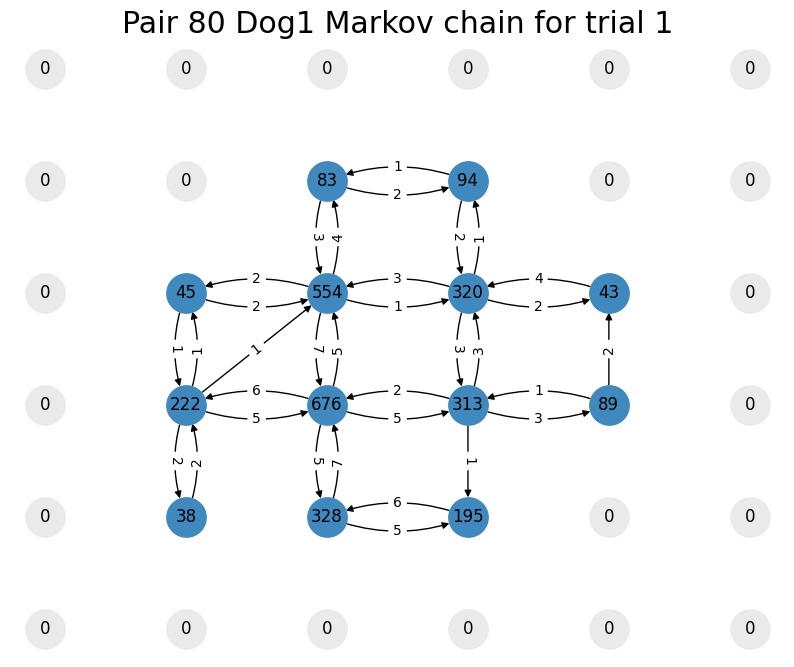

[((2, 1), (2, 1), np.float64(16.0)), ((2, 1), (2, 2), np.float64(1.0)), ((2, 1), (3, 1), np.float64(1.0)), ((3, 1), (2, 1), np.float64(1.0)), ((3, 1), (3, 1), np.float64(18.0)), ((2, 2), (2, 2), np.float64(1377.0)), ((2, 2), (2, 3), np.float64(6.0)), ((2, 2), (3, 2), np.float64(45.0)), ((3, 2), (2, 2), np.float64(44.0)), ((3, 2), (3, 2), np.float64(1106.0)), ((3, 2), (3, 3), np.float64(35.0)), ((2, 3), (2, 2), np.float64(6.0)), ((2, 3), (2, 3), np.float64(45.0)), ((3, 3), (3, 2), np.float64(35.0)), ((3, 3), (3, 3), np.float64(265.0))]
# of non-zero transition probabilities for trial last: 15
# of states visited for trial last: 6
Average non-zero transition probability: 200.06667
{(2, 1): np.float64(17.0), (3, 1): np.float64(19.0), (2, 3): np.float64(51.0), (3, 3): np.float64(300.0), (2, 2): np.float64(1428.0), (3, 2): np.float64(1186.0)}


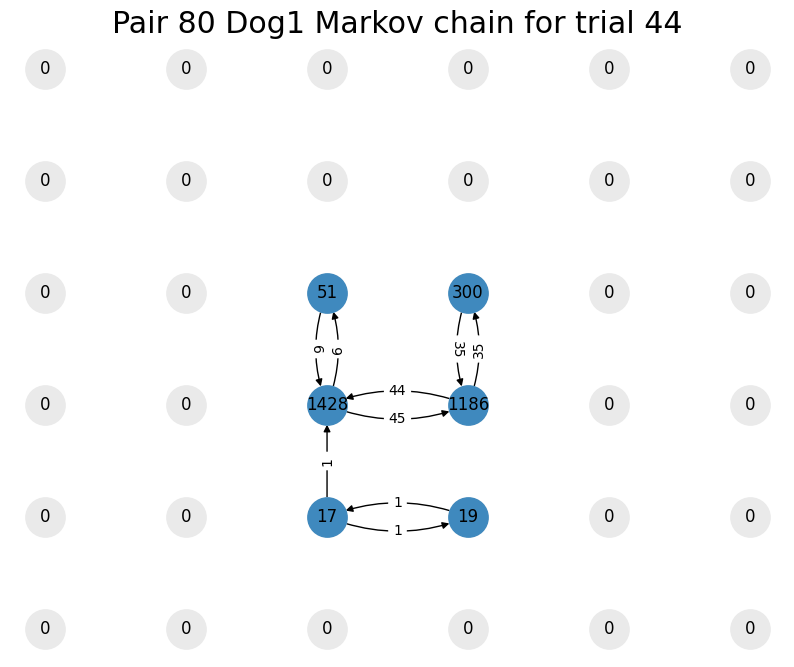

[((1, 1), (1, 1), np.float64(97.0)), ((1, 1), (1, 2), np.float64(2.0)), ((1, 1), (2, 1), np.float64(2.0)), ((2, 1), (1, 1), np.float64(4.0)), ((2, 1), (2, 1), np.float64(569.0)), ((2, 1), (2, 2), np.float64(9.0)), ((2, 1), (3, 1), np.float64(7.0)), ((3, 1), (2, 1), np.float64(10.0)), ((3, 1), (3, 1), np.float64(369.0)), ((3, 1), (3, 2), np.float64(3.0)), ((3, 1), (4, 1), np.float64(1.0)), ((4, 1), (4, 1), np.float64(5.0)), ((4, 1), (4, 2), np.float64(1.0)), ((1, 2), (1, 1), np.float64(1.0)), ((1, 2), (1, 2), np.float64(326.0)), ((1, 2), (2, 2), np.float64(5.0)), ((2, 2), (1, 2), np.float64(4.0)), ((2, 2), (2, 1), np.float64(7.0)), ((2, 2), (2, 2), np.float64(588.0)), ((2, 2), (3, 2), np.float64(5.0)), ((3, 2), (2, 2), np.float64(2.0)), ((3, 2), (3, 1), np.float64(7.0)), ((3, 2), (3, 2), np.float64(543.0)), ((3, 2), (4, 2), np.float64(6.0)), ((4, 2), (3, 2), np.float64(7.0)), ((4, 2), (4, 2), np.float64(311.0)), ((4, 2), (4, 3), np.float64(1.0)), ((4, 2), (5, 2), np.float64(1.0)), ((5, 

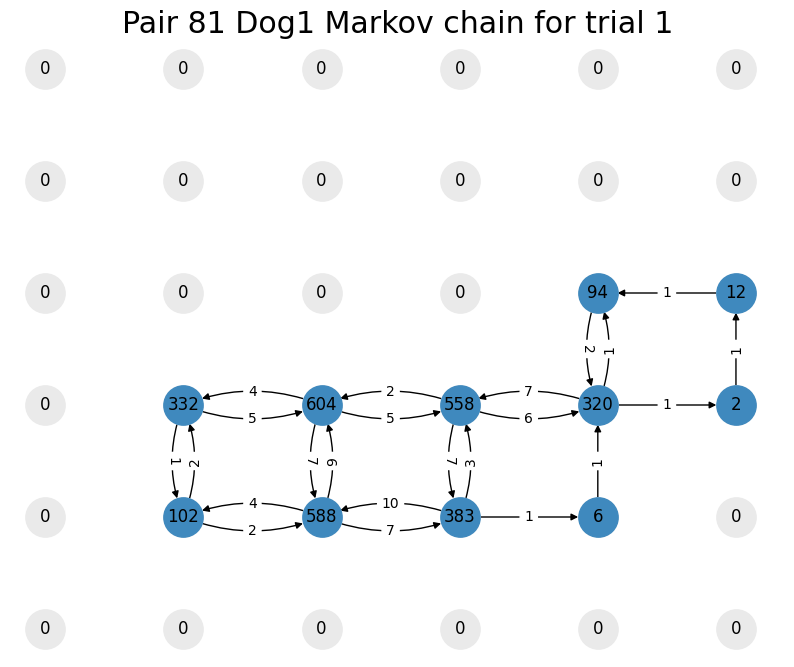

[((1, 1), (1, 1), np.float64(1.0)), ((1, 1), (1, 2), np.float64(1.0)), ((2, 1), (1, 1), np.float64(1.0)), ((2, 1), (2, 1), np.float64(228.0)), ((2, 1), (2, 2), np.float64(5.0)), ((2, 1), (3, 1), np.float64(4.0)), ((2, 1), (3, 2), np.float64(1.0)), ((3, 1), (2, 1), np.float64(4.0)), ((3, 1), (3, 1), np.float64(165.0)), ((3, 1), (3, 2), np.float64(3.0)), ((1, 2), (1, 2), np.float64(149.0)), ((1, 2), (1, 3), np.float64(2.0)), ((1, 2), (2, 2), np.float64(3.0)), ((2, 2), (1, 2), np.float64(3.0)), ((2, 2), (2, 1), np.float64(6.0)), ((2, 2), (2, 2), np.float64(955.0)), ((2, 2), (2, 3), np.float64(1.0)), ((2, 2), (3, 2), np.float64(10.0)), ((3, 2), (2, 2), np.float64(10.0)), ((3, 2), (3, 1), np.float64(3.0)), ((3, 2), (3, 2), np.float64(1127.0)), ((3, 2), (3, 3), np.float64(2.0)), ((3, 2), (4, 2), np.float64(6.0)), ((4, 2), (3, 2), np.float64(5.0)), ((4, 2), (4, 2), np.float64(127.0)), ((4, 2), (4, 3), np.float64(1.0)), ((1, 3), (1, 2), np.float64(1.0)), ((1, 3), (1, 3), np.float64(43.0)), ((1

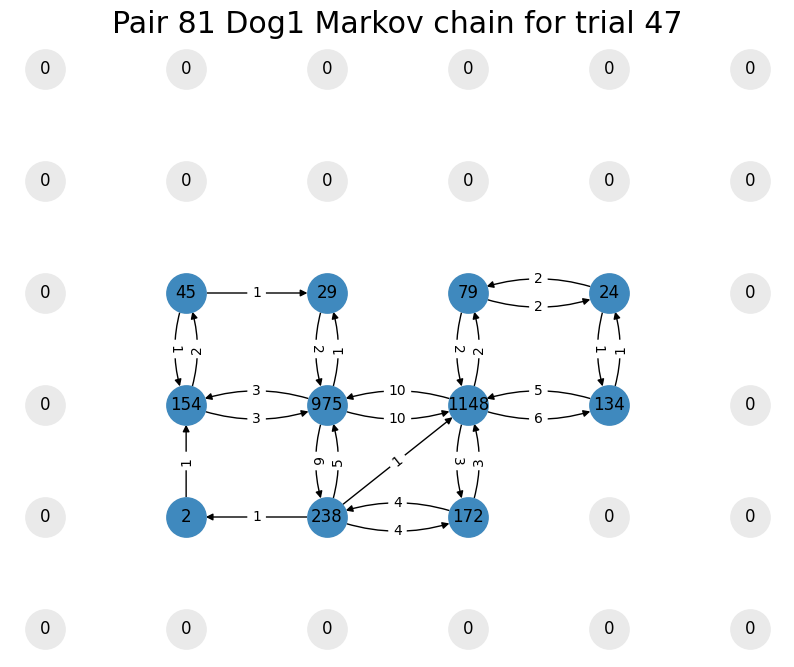

[((1, 1), (1, 1), np.float64(12.0)), ((1, 1), (1, 2), np.float64(2.0)), ((1, 1), (2, 1), np.float64(1.0)), ((2, 1), (1, 1), np.float64(1.0)), ((2, 1), (2, 1), np.float64(338.0)), ((2, 1), (2, 2), np.float64(12.0)), ((2, 1), (3, 1), np.float64(9.0)), ((3, 1), (2, 1), np.float64(8.0)), ((3, 1), (3, 1), np.float64(245.0)), ((3, 1), (3, 2), np.float64(7.0)), ((1, 2), (1, 1), np.float64(2.0)), ((1, 2), (1, 2), np.float64(298.0)), ((1, 2), (1, 3), np.float64(3.0)), ((1, 2), (2, 2), np.float64(6.0)), ((2, 2), (1, 2), np.float64(8.0)), ((2, 2), (2, 1), np.float64(10.0)), ((2, 2), (2, 2), np.float64(787.0)), ((2, 2), (2, 3), np.float64(1.0)), ((2, 2), (3, 2), np.float64(8.0)), ((3, 2), (2, 1), np.float64(2.0)), ((3, 2), (2, 2), np.float64(7.0)), ((3, 2), (3, 1), np.float64(6.0)), ((3, 2), (3, 2), np.float64(1010.0)), ((3, 2), (3, 3), np.float64(2.0)), ((3, 2), (4, 2), np.float64(3.0)), ((4, 2), (3, 2), np.float64(4.0)), ((4, 2), (4, 2), np.float64(52.0)), ((1, 3), (1, 2), np.float64(1.0)), ((1,

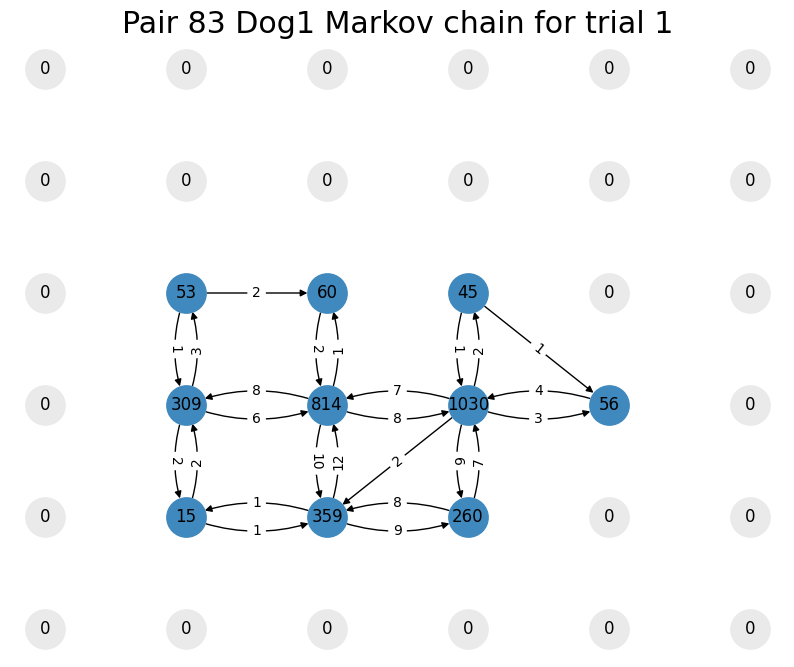

[((2, 1), (2, 1), np.float64(437.0)), ((2, 1), (2, 2), np.float64(20.0)), ((2, 1), (3, 1), np.float64(8.0)), ((2, 1), (3, 2), np.float64(2.0)), ((3, 1), (2, 1), np.float64(8.0)), ((3, 1), (2, 2), np.float64(1.0)), ((3, 1), (3, 1), np.float64(122.0)), ((3, 1), (3, 2), np.float64(13.0)), ((1, 2), (1, 2), np.float64(57.0)), ((1, 2), (2, 2), np.float64(1.0)), ((2, 2), (1, 2), np.float64(1.0)), ((2, 2), (2, 1), np.float64(21.0)), ((2, 2), (2, 2), np.float64(1208.0)), ((2, 2), (2, 3), np.float64(1.0)), ((2, 2), (3, 2), np.float64(13.0)), ((3, 2), (2, 2), np.float64(14.0)), ((3, 2), (3, 1), np.float64(14.0)), ((3, 2), (3, 2), np.float64(1057.0)), ((2, 3), (2, 3), np.float64(2.0))]
# of non-zero transition probabilities for trial last: 19
# of states visited for trial last: 6
Average non-zero transition probability: 157.89474
{(1, 2): np.float64(58.0), (2, 1): np.float64(466.0), (3, 1): np.float64(144.0), (2, 3): np.float64(3.0), (2, 2): np.float64(1244.0), (3, 2): np.float64(1085.0)}


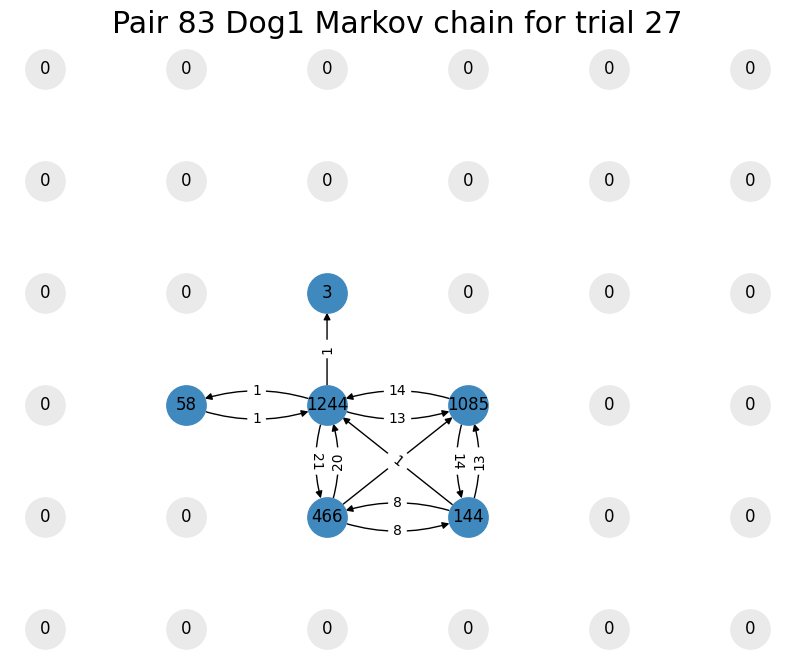

[((1, 1), (1, 1), np.float64(113.0)), ((1, 1), (1, 2), np.float64(4.0)), ((1, 1), (2, 1), np.float64(1.0)), ((2, 1), (1, 1), np.float64(4.0)), ((2, 1), (1, 2), np.float64(1.0)), ((2, 1), (2, 1), np.float64(926.0)), ((2, 1), (2, 2), np.float64(3.0)), ((2, 1), (3, 1), np.float64(8.0)), ((3, 1), (2, 1), np.float64(7.0)), ((3, 1), (3, 1), np.float64(340.0)), ((3, 1), (3, 2), np.float64(5.0)), ((3, 1), (4, 1), np.float64(2.0)), ((4, 1), (4, 1), np.float64(55.0)), ((4, 1), (4, 2), np.float64(2.0)), ((0, 2), (0, 2), np.float64(53.0)), ((0, 2), (0, 3), np.float64(2.0)), ((0, 2), (1, 2), np.float64(1.0)), ((1, 2), (0, 2), np.float64(2.0)), ((1, 2), (1, 1), np.float64(1.0)), ((1, 2), (1, 2), np.float64(321.0)), ((1, 2), (2, 2), np.float64(4.0)), ((2, 2), (2, 1), np.float64(7.0)), ((2, 2), (2, 2), np.float64(272.0)), ((3, 2), (3, 1), np.float64(6.0)), ((3, 2), (3, 2), np.float64(286.0)), ((3, 2), (4, 2), np.float64(2.0)), ((4, 2), (3, 2), np.float64(3.0)), ((4, 2), (4, 2), np.float64(314.0)), ((4

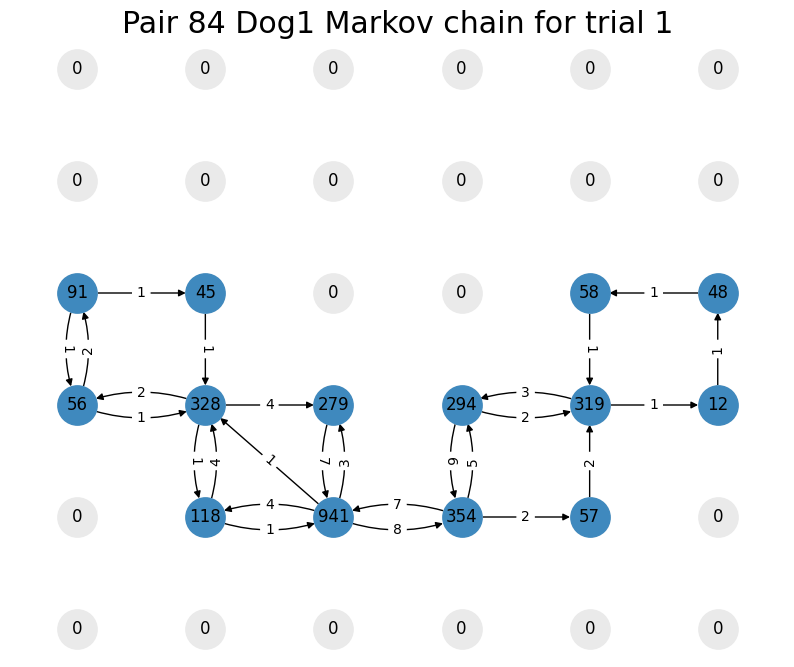

[((2, 1), (2, 1), np.float64(89.0)), ((2, 1), (2, 2), np.float64(5.0)), ((2, 1), (3, 1), np.float64(2.0)), ((3, 1), (2, 1), np.float64(1.0)), ((3, 1), (3, 1), np.float64(8.0)), ((3, 1), (3, 2), np.float64(2.0)), ((1, 2), (1, 2), np.float64(53.0)), ((1, 2), (2, 2), np.float64(3.0)), ((2, 2), (1, 2), np.float64(3.0)), ((2, 2), (2, 1), np.float64(5.0)), ((2, 2), (2, 2), np.float64(1618.0)), ((2, 2), (2, 3), np.float64(2.0)), ((2, 2), (3, 2), np.float64(16.0)), ((3, 2), (2, 2), np.float64(16.0)), ((3, 2), (3, 1), np.float64(1.0)), ((3, 2), (3, 2), np.float64(954.0)), ((3, 2), (3, 3), np.float64(3.0)), ((2, 3), (2, 2), np.float64(2.0)), ((2, 3), (2, 3), np.float64(63.0)), ((3, 3), (3, 2), np.float64(3.0)), ((3, 3), (3, 3), np.float64(151.0))]
# of non-zero transition probabilities for trial last: 21
# of states visited for trial last: 7
Average non-zero transition probability: 142.85714
{(1, 2): np.float64(56.0), (2, 1): np.float64(95.0), (3, 1): np.float64(11.0), (2, 3): np.float64(65.0), 

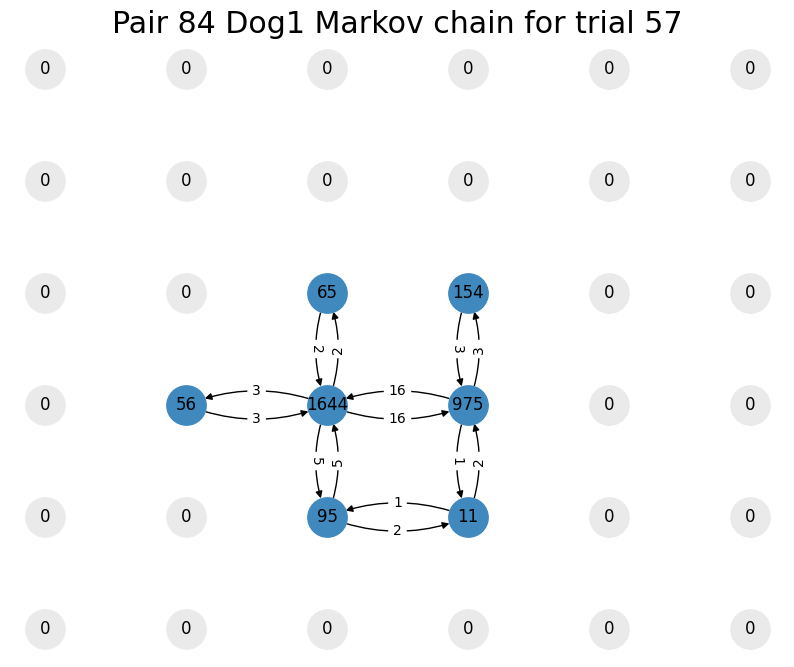

[((2, 1), (2, 1), np.float64(65.0)), ((2, 1), (2, 2), np.float64(3.0)), ((1, 2), (1, 2), np.float64(6.0)), ((1, 2), (2, 2), np.float64(1.0)), ((2, 2), (1, 2), np.float64(1.0)), ((2, 2), (2, 1), np.float64(2.0)), ((2, 2), (2, 2), np.float64(965.0)), ((2, 2), (2, 3), np.float64(2.0)), ((2, 2), (3, 2), np.float64(24.0)), ((3, 2), (2, 2), np.float64(22.0)), ((3, 2), (3, 2), np.float64(761.0)), ((3, 2), (3, 3), np.float64(15.0)), ((3, 2), (4, 2), np.float64(4.0)), ((3, 2), (4, 3), np.float64(1.0)), ((4, 2), (3, 2), np.float64(1.0)), ((4, 2), (4, 2), np.float64(70.0)), ((4, 2), (4, 3), np.float64(3.0)), ((2, 3), (2, 2), np.float64(2.0)), ((2, 3), (2, 3), np.float64(41.0)), ((3, 3), (2, 2), np.float64(1.0)), ((3, 3), (3, 2), np.float64(18.0)), ((3, 3), (3, 3), np.float64(881.0)), ((3, 3), (3, 4), np.float64(1.0)), ((3, 3), (4, 3), np.float64(1.0)), ((4, 3), (3, 3), np.float64(5.0)), ((4, 3), (4, 3), np.float64(94.0)), ((3, 4), (3, 3), np.float64(1.0)), ((3, 4), (3, 4), np.float64(9.0))]
# of 

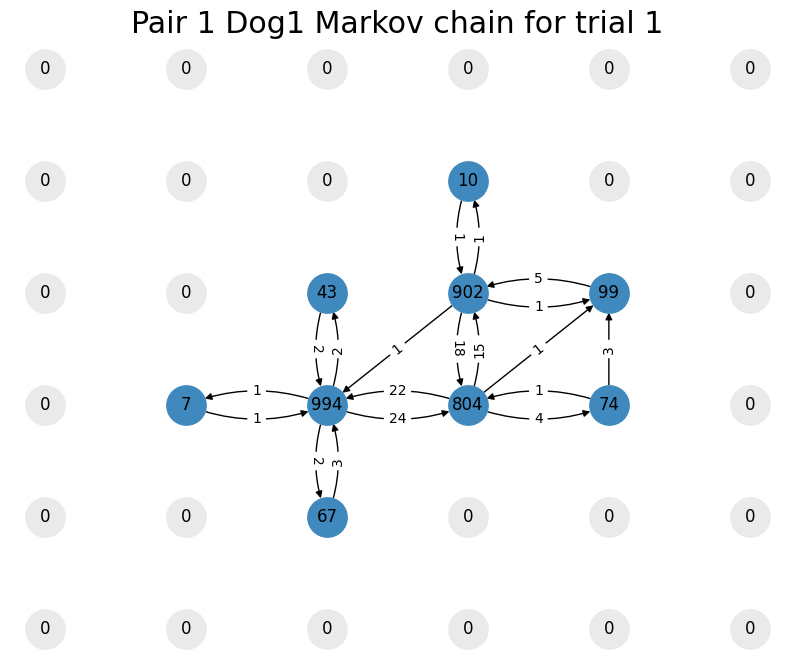

[((2, 1), (2, 1), np.float64(36.0)), ((2, 1), (2, 2), np.float64(1.0)), ((2, 2), (2, 2), np.float64(1275.0)), ((2, 2), (2, 3), np.float64(2.0)), ((2, 2), (3, 2), np.float64(60.0)), ((3, 2), (2, 2), np.float64(59.0)), ((3, 2), (3, 2), np.float64(1202.0)), ((3, 2), (3, 3), np.float64(38.0)), ((2, 3), (2, 2), np.float64(2.0)), ((2, 3), (2, 3), np.float64(6.0)), ((3, 3), (3, 2), np.float64(38.0)), ((3, 3), (3, 3), np.float64(281.0))]
# of non-zero transition probabilities for trial last: 12
# of states visited for trial last: 5
Average non-zero transition probability: 250.00000
{(2, 1): np.float64(36.0), (2, 3): np.float64(8.0), (3, 3): np.float64(319.0), (2, 2): np.float64(1337.0), (3, 2): np.float64(1300.0)}


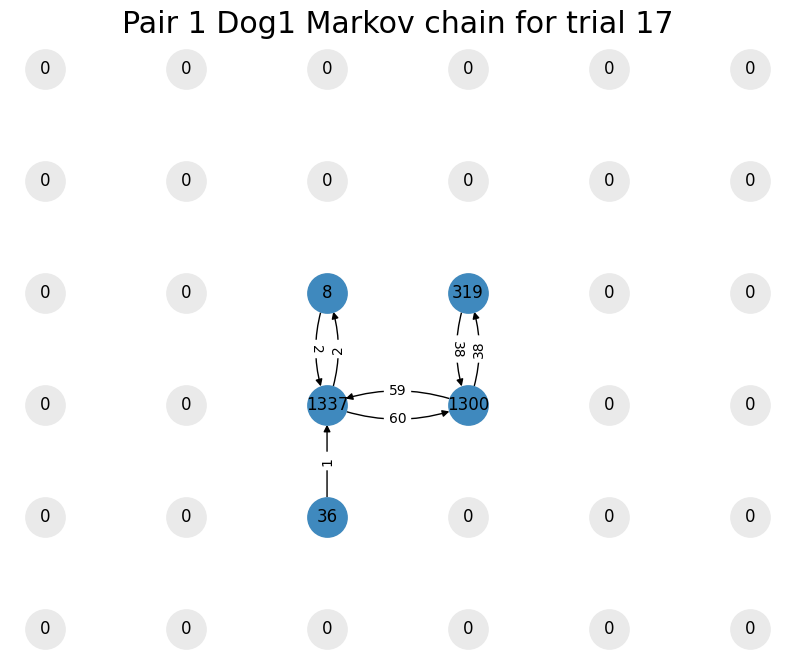

[((2, 1), (2, 1), np.float64(144.0)), ((2, 1), (2, 2), np.float64(5.0)), ((2, 1), (3, 1), np.float64(2.0)), ((3, 1), (2, 1), np.float64(3.0)), ((3, 1), (3, 1), np.float64(84.0)), ((3, 1), (3, 2), np.float64(4.0)), ((2, 2), (2, 1), np.float64(3.0)), ((2, 2), (2, 2), np.float64(631.0)), ((2, 2), (3, 2), np.float64(12.0)), ((3, 2), (2, 2), np.float64(10.0)), ((3, 2), (3, 1), np.float64(5.0)), ((3, 2), (3, 2), np.float64(1292.0)), ((3, 2), (3, 3), np.float64(8.0)), ((3, 2), (4, 2), np.float64(6.0)), ((4, 2), (3, 2), np.float64(3.0)), ((4, 2), (4, 2), np.float64(39.0)), ((4, 2), (4, 3), np.float64(4.0)), ((3, 3), (3, 2), np.float64(11.0)), ((3, 3), (3, 3), np.float64(658.0)), ((3, 3), (4, 3), np.float64(2.0)), ((4, 3), (3, 3), np.float64(5.0)), ((4, 3), (4, 2), np.float64(1.0)), ((4, 3), (4, 3), np.float64(68.0))]
# of non-zero transition probabilities for trial first: 23
# of states visited for trial first: 7
Average non-zero transition probability: 130.43478
{(2, 1): np.float64(150.0), (4

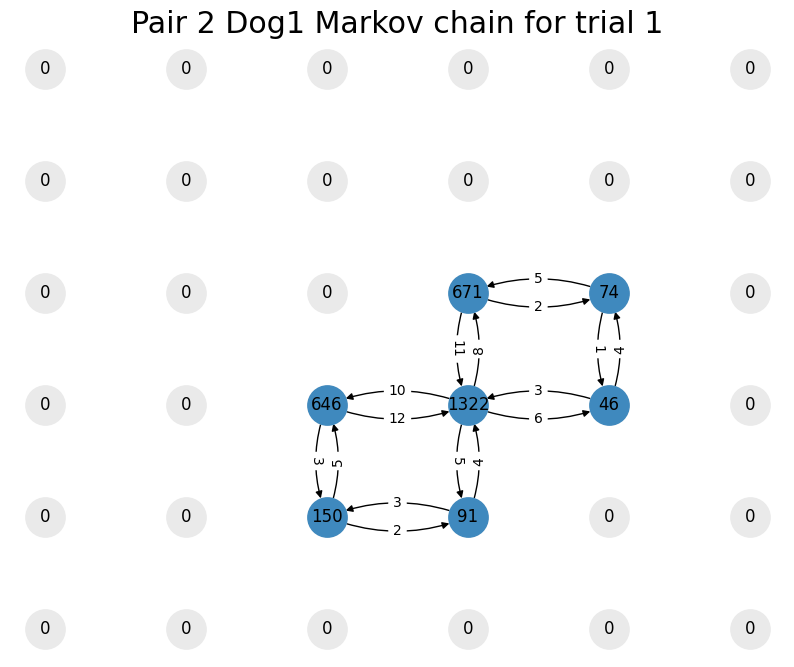

[((2, 1), (2, 1), np.float64(72.0)), ((2, 1), (2, 2), np.float64(3.0)), ((2, 1), (3, 1), np.float64(3.0)), ((2, 1), (3, 2), np.float64(1.0)), ((3, 1), (3, 1), np.float64(1.0)), ((3, 1), (3, 2), np.float64(3.0)), ((2, 2), (2, 1), np.float64(5.0)), ((2, 2), (2, 2), np.float64(1527.0)), ((2, 2), (3, 2), np.float64(48.0)), ((3, 2), (2, 1), np.float64(1.0)), ((3, 2), (2, 2), np.float64(50.0)), ((3, 2), (3, 2), np.float64(1287.0))]
# of non-zero transition probabilities for trial last: 12
# of states visited for trial last: 4
Average non-zero transition probability: 250.08333
{(3, 1): np.float64(4.0), (3, 2): np.float64(1339.0), (2, 1): np.float64(78.0), (2, 2): np.float64(1580.0)}


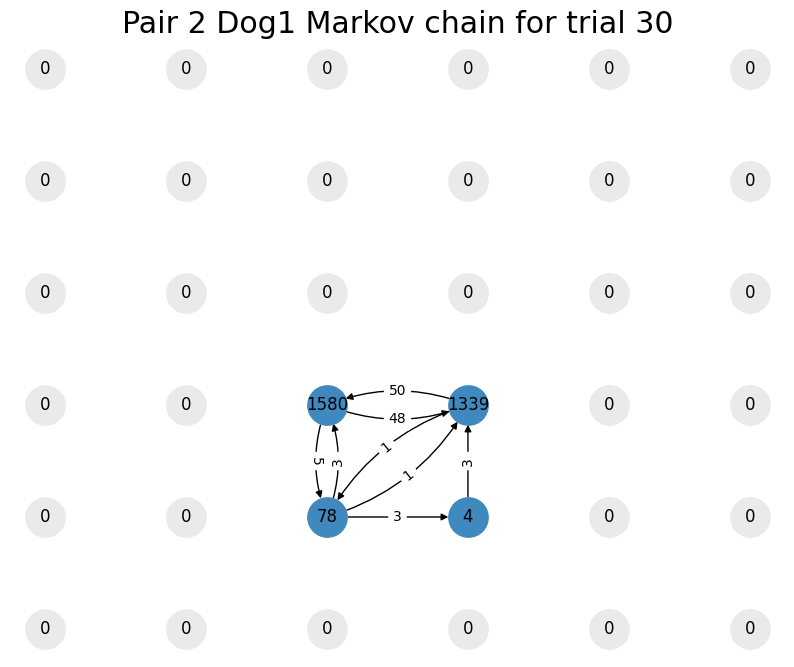

[((2, 1), (2, 1), np.float64(27.0)), ((2, 1), (2, 2), np.float64(1.0)), ((2, 1), (3, 1), np.float64(1.0)), ((3, 1), (2, 1), np.float64(2.0)), ((3, 1), (3, 1), np.float64(25.0)), ((3, 1), (3, 2), np.float64(1.0)), ((2, 2), (2, 2), np.float64(1665.0)), ((2, 2), (2, 3), np.float64(3.0)), ((2, 2), (3, 2), np.float64(19.0)), ((3, 2), (2, 2), np.float64(19.0)), ((3, 2), (3, 1), np.float64(1.0)), ((3, 2), (3, 2), np.float64(1062.0)), ((3, 2), (4, 2), np.float64(2.0)), ((4, 2), (3, 2), np.float64(2.0)), ((4, 2), (4, 2), np.float64(28.0)), ((4, 2), (4, 3), np.float64(1.0)), ((1, 3), (1, 3), np.float64(15.0)), ((1, 3), (2, 3), np.float64(2.0)), ((2, 3), (1, 3), np.float64(2.0)), ((2, 3), (2, 2), np.float64(3.0)), ((2, 3), (2, 3), np.float64(96.0)), ((4, 3), (4, 2), np.float64(1.0)), ((4, 3), (4, 3), np.float64(22.0))]
# of non-zero transition probabilities for trial first: 23
# of states visited for trial first: 8
Average non-zero transition probability: 130.43478
{(2, 1): np.float64(29.0), (4, 

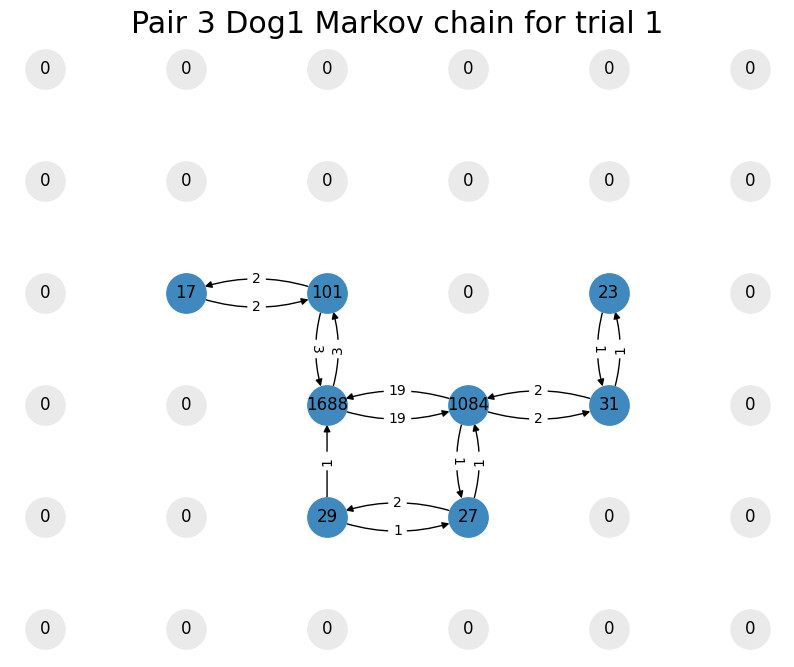

[((2, 1), (2, 1), np.float64(21.0)), ((2, 1), (3, 1), np.float64(1.0)), ((3, 1), (3, 1), np.float64(6.0)), ((3, 1), (3, 2), np.float64(1.0)), ((2, 2), (2, 2), np.float64(1452.0)), ((2, 2), (3, 2), np.float64(56.0)), ((3, 2), (2, 2), np.float64(56.0)), ((3, 2), (3, 2), np.float64(1407.0))]
# of non-zero transition probabilities for trial last: 8
# of states visited for trial last: 4
Average non-zero transition probability: 375.00000
{(3, 1): np.float64(7.0), (3, 2): np.float64(1464.0), (2, 1): np.float64(21.0), (2, 2): np.float64(1508.0)}


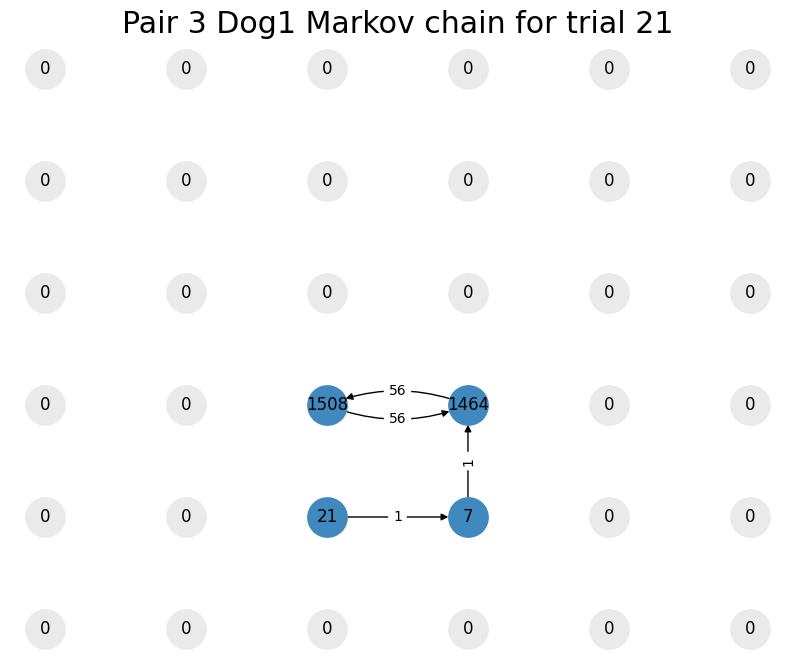

[((1, 1), (1, 1), np.float64(140.0)), ((1, 1), (1, 2), np.float64(3.0)), ((1, 1), (2, 1), np.float64(2.0)), ((2, 1), (1, 1), np.float64(4.0)), ((2, 1), (1, 2), np.float64(1.0)), ((2, 1), (2, 1), np.float64(511.0)), ((2, 1), (2, 2), np.float64(3.0)), ((2, 1), (3, 1), np.float64(6.0)), ((3, 1), (2, 1), np.float64(7.0)), ((3, 1), (3, 1), np.float64(223.0)), ((3, 1), (3, 2), np.float64(4.0)), ((3, 1), (4, 1), np.float64(3.0)), ((4, 1), (3, 1), np.float64(1.0)), ((4, 1), (4, 1), np.float64(52.0)), ((4, 1), (4, 2), np.float64(2.0)), ((4, 1), (5, 1), np.float64(1.0)), ((5, 1), (4, 1), np.float64(1.0)), ((5, 1), (5, 1), np.float64(39.0)), ((5, 1), (5, 2), np.float64(1.0)), ((1, 2), (1, 1), np.float64(1.0)), ((1, 2), (1, 2), np.float64(439.0)), ((1, 2), (1, 3), np.float64(3.0)), ((1, 2), (2, 2), np.float64(7.0)), ((2, 2), (1, 2), np.float64(4.0)), ((2, 2), (2, 1), np.float64(4.0)), ((2, 2), (2, 2), np.float64(496.0)), ((2, 2), (3, 2), np.float64(6.0)), ((3, 2), (2, 2), np.float64(4.0)), ((3, 2)

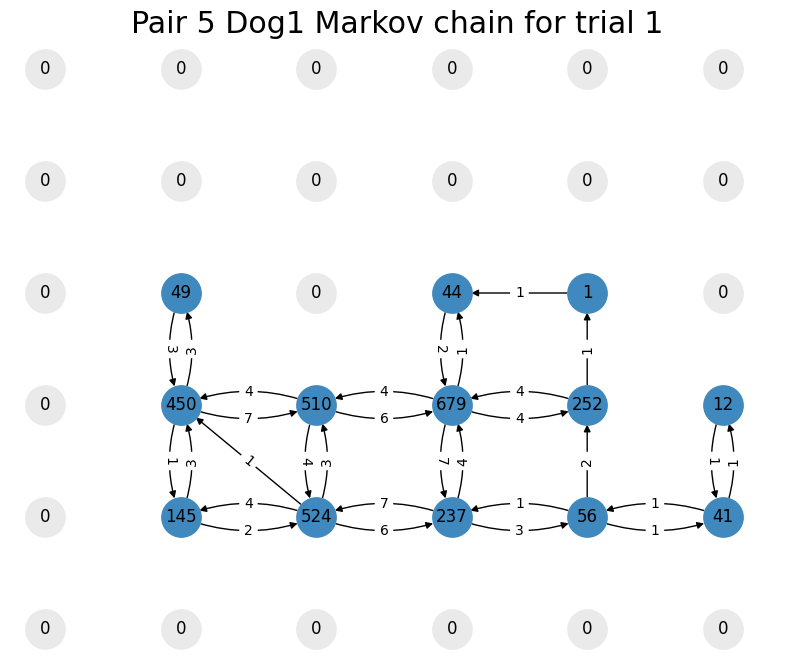

[((2, 1), (2, 1), np.float64(191.0)), ((2, 1), (2, 2), np.float64(34.0)), ((2, 1), (3, 1), np.float64(22.0)), ((2, 1), (3, 2), np.float64(1.0)), ((3, 1), (2, 1), np.float64(28.0)), ((3, 1), (2, 2), np.float64(1.0)), ((3, 1), (3, 1), np.float64(118.0)), ((3, 1), (3, 2), np.float64(23.0)), ((1, 2), (1, 2), np.float64(14.0)), ((1, 2), (2, 2), np.float64(2.0)), ((2, 2), (1, 2), np.float64(2.0)), ((2, 2), (2, 1), np.float64(25.0)), ((2, 2), (2, 2), np.float64(1143.0)), ((2, 2), (3, 2), np.float64(27.0)), ((3, 2), (2, 1), np.float64(3.0)), ((3, 2), (2, 2), np.float64(18.0)), ((3, 2), (3, 1), np.float64(30.0)), ((3, 2), (3, 2), np.float64(1306.0)), ((3, 2), (4, 2), np.float64(1.0)), ((4, 2), (3, 2), np.float64(1.0)), ((4, 2), (4, 2), np.float64(9.0))]
# of non-zero transition probabilities for trial last: 21
# of states visited for trial last: 6
Average non-zero transition probability: 142.80952
{(1, 2): np.float64(16.0), (2, 1): np.float64(247.0), (3, 1): np.float64(170.0), (4, 2): np.float6

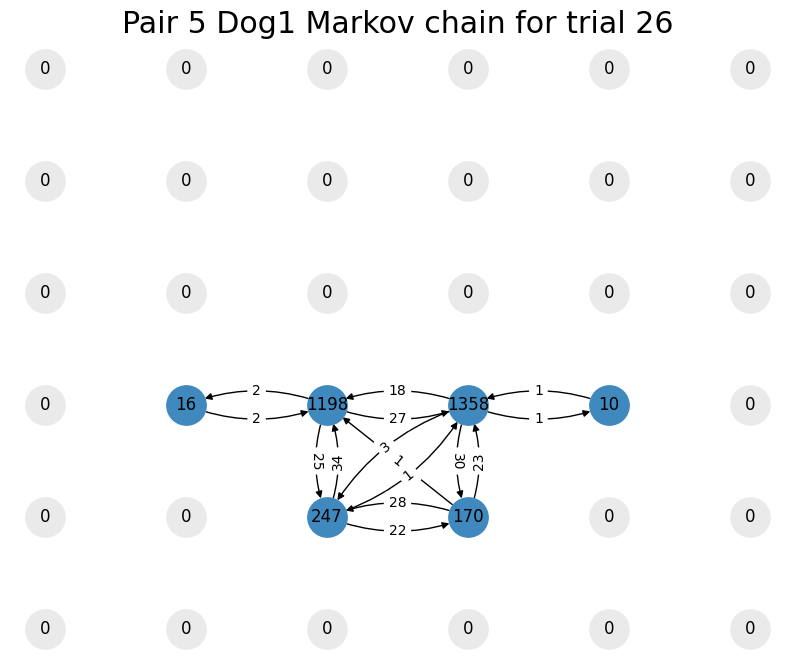

[((2, 1), (2, 1), np.float64(219.0)), ((2, 1), (2, 2), np.float64(2.0)), ((2, 1), (3, 1), np.float64(7.0)), ((2, 1), (3, 2), np.float64(1.0)), ((3, 1), (2, 1), np.float64(3.0)), ((3, 1), (3, 1), np.float64(144.0)), ((3, 1), (3, 2), np.float64(5.0)), ((1, 2), (1, 2), np.float64(118.0)), ((1, 2), (1, 3), np.float64(2.0)), ((1, 2), (2, 2), np.float64(4.0)), ((2, 2), (1, 2), np.float64(5.0)), ((2, 2), (2, 1), np.float64(7.0)), ((2, 2), (2, 2), np.float64(1181.0)), ((2, 2), (3, 2), np.float64(8.0)), ((3, 2), (2, 2), np.float64(13.0)), ((3, 2), (3, 1), np.float64(1.0)), ((3, 2), (3, 2), np.float64(855.0)), ((3, 2), (3, 3), np.float64(3.0)), ((3, 2), (4, 2), np.float64(4.0)), ((4, 2), (3, 2), np.float64(3.0)), ((4, 2), (4, 2), np.float64(116.0)), ((4, 2), (4, 3), np.float64(1.0)), ((1, 3), (1, 2), np.float64(1.0)), ((1, 3), (1, 3), np.float64(68.0)), ((1, 3), (2, 3), np.float64(2.0)), ((2, 3), (1, 3), np.float64(1.0)), ((2, 3), (2, 2), np.float64(1.0)), ((2, 3), (2, 3), np.float64(41.0)), ((3

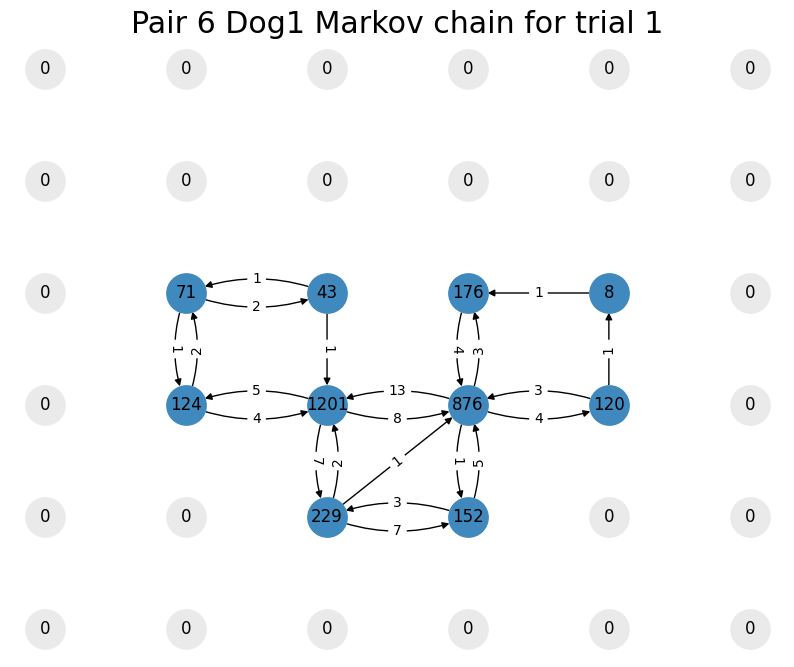

[((2, 1), (2, 1), np.float64(56.0)), ((2, 1), (2, 2), np.float64(1.0)), ((2, 1), (3, 1), np.float64(1.0)), ((3, 1), (3, 1), np.float64(49.0)), ((3, 1), (3, 2), np.float64(2.0)), ((2, 2), (2, 1), np.float64(1.0)), ((2, 2), (2, 2), np.float64(1089.0)), ((2, 2), (2, 3), np.float64(6.0)), ((2, 2), (3, 2), np.float64(19.0)), ((3, 2), (2, 2), np.float64(19.0)), ((3, 2), (3, 1), np.float64(1.0)), ((3, 2), (3, 2), np.float64(1223.0)), ((3, 2), (3, 3), np.float64(11.0)), ((3, 2), (4, 2), np.float64(2.0)), ((4, 2), (4, 2), np.float64(12.0)), ((4, 2), (4, 3), np.float64(2.0)), ((2, 3), (2, 2), np.float64(6.0)), ((2, 3), (2, 3), np.float64(163.0)), ((2, 3), (3, 3), np.float64(1.0)), ((3, 3), (2, 3), np.float64(1.0)), ((3, 3), (3, 2), np.float64(13.0)), ((3, 3), (3, 3), np.float64(289.0)), ((4, 3), (3, 3), np.float64(2.0)), ((4, 3), (4, 3), np.float64(31.0))]
# of non-zero transition probabilities for trial last: 24
# of states visited for trial last: 8
Average non-zero transition probability: 125.

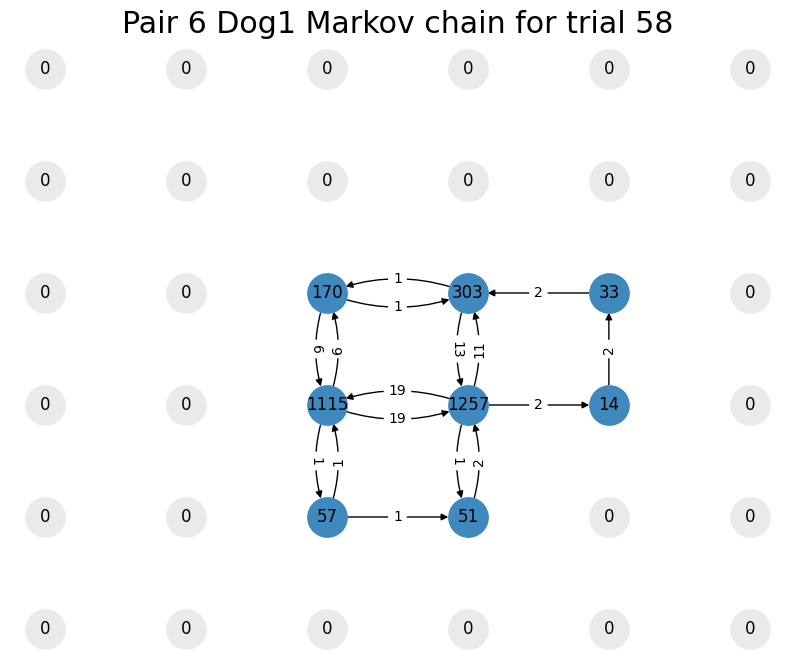

[((1, 1), (1, 1), np.float64(19.0)), ((1, 1), (1, 2), np.float64(1.0)), ((1, 1), (2, 1), np.float64(2.0)), ((2, 1), (1, 1), np.float64(2.0)), ((2, 1), (1, 2), np.float64(1.0)), ((2, 1), (2, 1), np.float64(273.0)), ((2, 1), (2, 2), np.float64(8.0)), ((2, 1), (3, 1), np.float64(8.0)), ((3, 1), (2, 1), np.float64(7.0)), ((3, 1), (3, 1), np.float64(570.0)), ((3, 1), (3, 2), np.float64(6.0)), ((3, 1), (4, 1), np.float64(1.0)), ((4, 1), (4, 1), np.float64(3.0)), ((4, 1), (4, 2), np.float64(1.0)), ((1, 2), (1, 1), np.float64(1.0)), ((1, 2), (1, 2), np.float64(358.0)), ((1, 2), (1, 3), np.float64(4.0)), ((1, 2), (2, 2), np.float64(6.0)), ((2, 2), (1, 2), np.float64(6.0)), ((2, 2), (2, 1), np.float64(9.0)), ((2, 2), (2, 2), np.float64(460.0)), ((2, 2), (3, 2), np.float64(3.0)), ((3, 2), (2, 2), np.float64(3.0)), ((3, 2), (3, 1), np.float64(6.0)), ((3, 2), (3, 2), np.float64(536.0)), ((3, 2), (3, 3), np.float64(2.0)), ((3, 2), (4, 2), np.float64(6.0)), ((4, 2), (3, 2), np.float64(6.0)), ((4, 2),

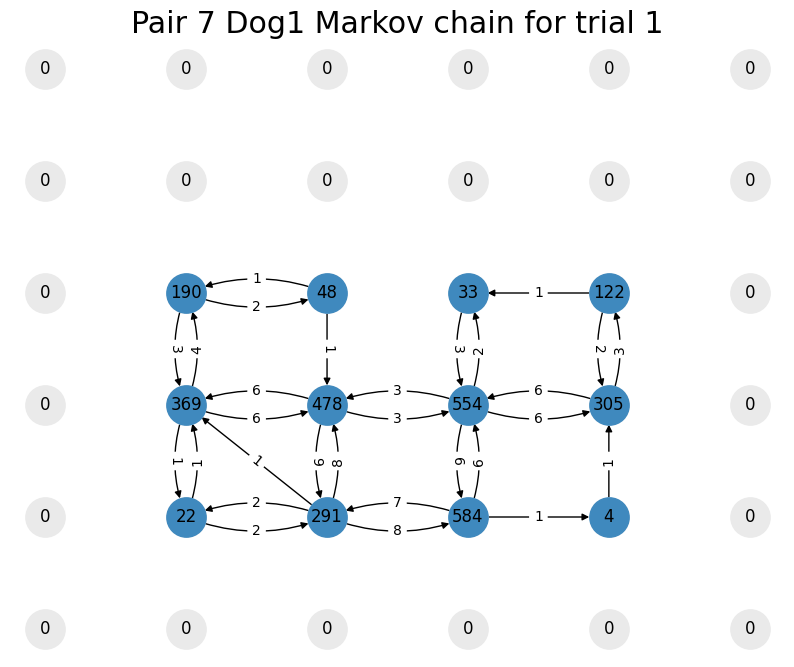

[((2, 1), (2, 1), np.float64(106.0)), ((2, 1), (2, 2), np.float64(5.0)), ((2, 1), (3, 1), np.float64(3.0)), ((3, 1), (2, 1), np.float64(3.0)), ((3, 1), (3, 1), np.float64(126.0)), ((3, 1), (3, 2), np.float64(3.0)), ((3, 1), (4, 1), np.float64(1.0)), ((4, 1), (3, 1), np.float64(1.0)), ((4, 1), (4, 1), np.float64(31.0)), ((1, 2), (1, 2), np.float64(133.0)), ((1, 2), (1, 3), np.float64(2.0)), ((1, 2), (2, 2), np.float64(3.0)), ((1, 2), (2, 3), np.float64(1.0)), ((2, 2), (1, 2), np.float64(5.0)), ((2, 2), (2, 1), np.float64(3.0)), ((2, 2), (2, 2), np.float64(1241.0)), ((2, 2), (3, 1), np.float64(1.0)), ((2, 2), (3, 2), np.float64(27.0)), ((3, 2), (2, 1), np.float64(1.0)), ((3, 2), (2, 2), np.float64(26.0)), ((3, 2), (3, 1), np.float64(2.0)), ((3, 2), (3, 2), np.float64(883.0)), ((3, 2), (4, 2), np.float64(4.0)), ((4, 2), (3, 2), np.float64(4.0)), ((4, 2), (4, 2), np.float64(123.0)), ((4, 2), (4, 3), np.float64(1.0)), ((1, 3), (1, 2), np.float64(1.0)), ((1, 3), (1, 3), np.float64(58.0)), ((

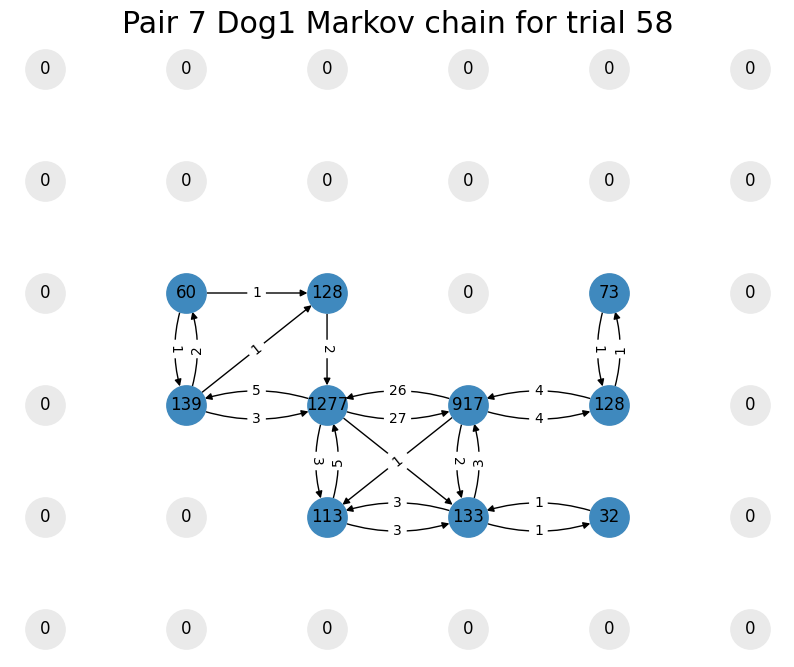

[((2, 1), (2, 1), np.float64(140.0)), ((2, 1), (2, 2), np.float64(2.0)), ((2, 1), (3, 1), np.float64(2.0)), ((3, 1), (2, 1), np.float64(2.0)), ((3, 1), (2, 2), np.float64(1.0)), ((3, 1), (3, 1), np.float64(64.0)), ((3, 1), (3, 2), np.float64(1.0)), ((2, 2), (2, 1), np.float64(1.0)), ((2, 2), (2, 2), np.float64(1105.0)), ((2, 2), (2, 3), np.float64(1.0)), ((2, 2), (3, 2), np.float64(17.0)), ((3, 2), (2, 2), np.float64(16.0)), ((3, 2), (3, 1), np.float64(2.0)), ((3, 2), (3, 2), np.float64(1214.0)), ((3, 2), (3, 3), np.float64(6.0)), ((2, 3), (2, 2), np.float64(1.0)), ((2, 3), (2, 3), np.float64(54.0)), ((2, 3), (3, 3), np.float64(1.0)), ((3, 3), (2, 3), np.float64(1.0)), ((3, 3), (3, 2), np.float64(6.0)), ((3, 3), (3, 3), np.float64(363.0))]
# of non-zero transition probabilities for trial first: 21
# of states visited for trial first: 6
Average non-zero transition probability: 142.85714
{(2, 1): np.float64(143.0), (3, 1): np.float64(68.0), (2, 3): np.float64(56.0), (3, 3): np.float64(37

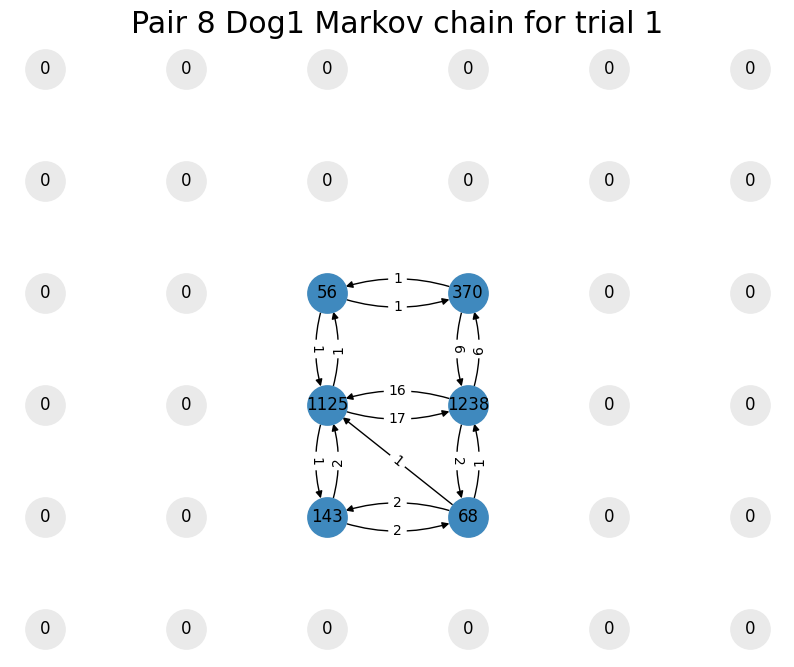

[((2, 1), (2, 1), np.float64(36.0)), ((2, 1), (2, 2), np.float64(5.0)), ((2, 1), (3, 1), np.float64(1.0)), ((3, 1), (2, 1), np.float64(3.0)), ((3, 1), (3, 1), np.float64(10.0)), ((3, 1), (3, 2), np.float64(2.0)), ((2, 2), (2, 1), np.float64(3.0)), ((2, 2), (2, 2), np.float64(1419.0)), ((2, 2), (3, 2), np.float64(41.0)), ((3, 2), (2, 2), np.float64(40.0)), ((3, 2), (3, 1), np.float64(3.0)), ((3, 2), (3, 2), np.float64(1059.0)), ((3, 2), (3, 3), np.float64(32.0)), ((3, 2), (4, 2), np.float64(1.0)), ((4, 2), (4, 2), np.float64(2.0)), ((4, 2), (4, 3), np.float64(1.0)), ((3, 3), (3, 2), np.float64(33.0)), ((3, 3), (3, 3), np.float64(295.0)), ((4, 3), (3, 3), np.float64(1.0)), ((4, 3), (4, 3), np.float64(13.0))]
# of non-zero transition probabilities for trial last: 20
# of states visited for trial last: 7
Average non-zero transition probability: 150.00000
{(2, 1): np.float64(42.0), (4, 3): np.float64(14.0), (3, 1): np.float64(14.0), (4, 2): np.float64(3.0), (3, 3): np.float64(328.0), (2, 2)

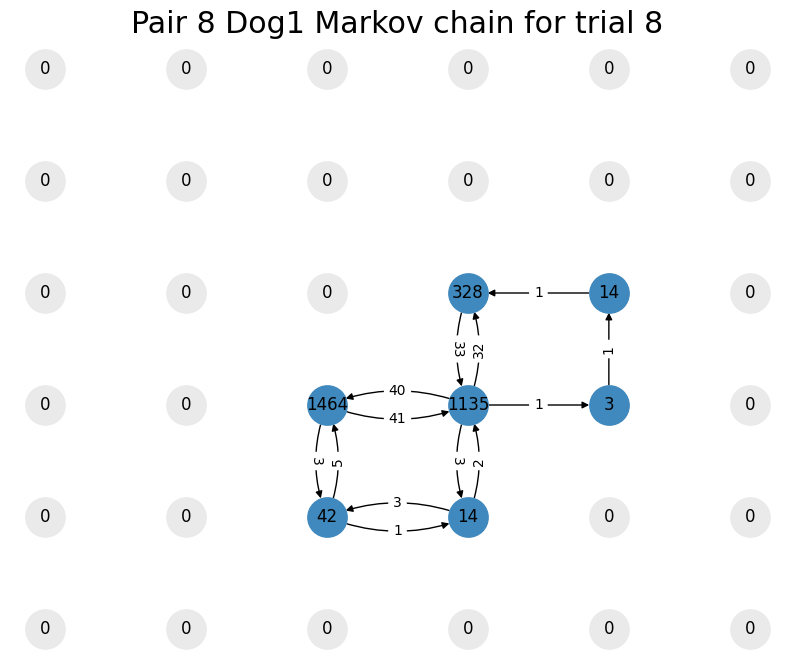

[((2, 1), (2, 1), np.float64(267.0)), ((2, 1), (2, 2), np.float64(7.0)), ((2, 1), (3, 1), np.float64(3.0)), ((2, 1), (3, 2), np.float64(1.0)), ((3, 1), (2, 1), np.float64(8.0)), ((3, 1), (3, 1), np.float64(257.0)), ((3, 1), (3, 2), np.float64(3.0)), ((4, 1), (4, 1), np.float64(20.0)), ((4, 1), (4, 2), np.float64(1.0)), ((1, 2), (1, 2), np.float64(172.0)), ((1, 2), (1, 3), np.float64(2.0)), ((1, 2), (2, 2), np.float64(6.0)), ((2, 2), (1, 2), np.float64(6.0)), ((2, 2), (2, 1), np.float64(2.0)), ((2, 2), (2, 2), np.float64(927.0)), ((2, 2), (3, 2), np.float64(8.0)), ((3, 2), (2, 2), np.float64(3.0)), ((3, 2), (3, 1), np.float64(8.0)), ((3, 2), (3, 2), np.float64(700.0)), ((3, 2), (4, 2), np.float64(7.0)), ((4, 2), (3, 2), np.float64(6.0)), ((4, 2), (4, 1), np.float64(1.0)), ((4, 2), (4, 2), np.float64(306.0)), ((4, 2), (4, 3), np.float64(4.0)), ((1, 3), (1, 2), np.float64(2.0)), ((1, 3), (1, 3), np.float64(102.0)), ((3, 3), (3, 3), np.float64(5.0)), ((3, 3), (4, 3), np.float64(1.0)), ((4,

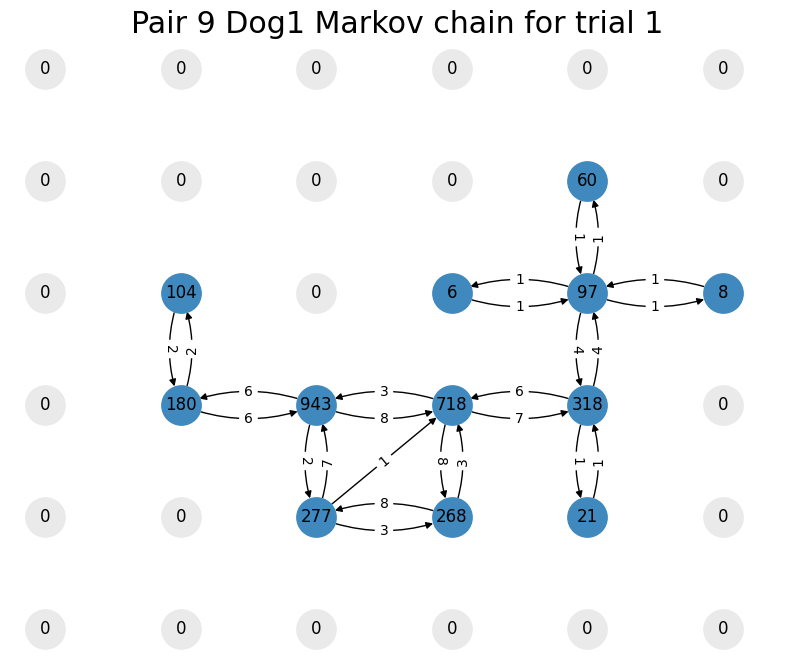

[((2, 1), (2, 1), np.float64(92.0)), ((2, 1), (2, 2), np.float64(1.0)), ((1, 2), (1, 2), np.float64(8.0)), ((1, 2), (2, 2), np.float64(1.0)), ((2, 2), (1, 2), np.float64(1.0)), ((2, 2), (2, 2), np.float64(1332.0)), ((2, 2), (2, 3), np.float64(4.0)), ((2, 2), (3, 2), np.float64(45.0)), ((3, 2), (2, 2), np.float64(45.0)), ((3, 2), (3, 2), np.float64(1249.0)), ((3, 2), (3, 3), np.float64(13.0)), ((2, 3), (2, 2), np.float64(4.0)), ((2, 3), (2, 3), np.float64(46.0)), ((2, 3), (3, 3), np.float64(1.0)), ((3, 3), (2, 3), np.float64(1.0)), ((3, 3), (3, 2), np.float64(13.0)), ((3, 3), (3, 3), np.float64(144.0))]
# of non-zero transition probabilities for trial last: 17
# of states visited for trial last: 6
Average non-zero transition probability: 176.47059
{(1, 2): np.float64(9.0), (2, 1): np.float64(92.0), (2, 3): np.float64(51.0), (3, 3): np.float64(158.0), (2, 2): np.float64(1383.0), (3, 2): np.float64(1307.0)}


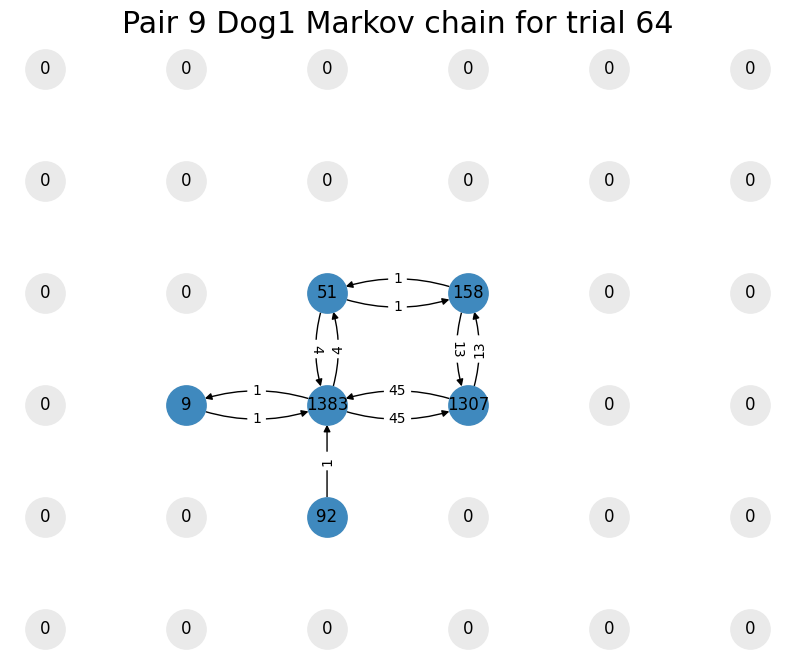

[((2, 1), (2, 1), np.float64(50.0)), ((2, 1), (2, 2), np.float64(3.0)), ((2, 1), (3, 1), np.float64(1.0)), ((3, 1), (2, 1), np.float64(1.0)), ((3, 1), (2, 2), np.float64(1.0)), ((3, 1), (3, 1), np.float64(23.0)), ((3, 1), (3, 2), np.float64(1.0)), ((1, 2), (1, 2), np.float64(31.0)), ((1, 2), (2, 2), np.float64(2.0)), ((2, 2), (1, 2), np.float64(2.0)), ((2, 2), (2, 1), np.float64(2.0)), ((2, 2), (2, 2), np.float64(1167.0)), ((2, 2), (3, 2), np.float64(16.0)), ((3, 2), (2, 2), np.float64(14.0)), ((3, 2), (3, 1), np.float64(2.0)), ((3, 2), (3, 2), np.float64(1103.0)), ((3, 2), (3, 3), np.float64(10.0)), ((3, 2), (4, 2), np.float64(2.0)), ((4, 2), (3, 2), np.float64(1.0)), ((4, 2), (4, 2), np.float64(31.0)), ((4, 2), (4, 3), np.float64(1.0)), ((3, 3), (3, 2), np.float64(10.0)), ((3, 3), (3, 3), np.float64(422.0)), ((3, 3), (4, 3), np.float64(3.0)), ((4, 3), (3, 3), np.float64(4.0)), ((4, 3), (4, 3), np.float64(98.0))]
# of non-zero transition probabilities for trial first: 26
# of states v

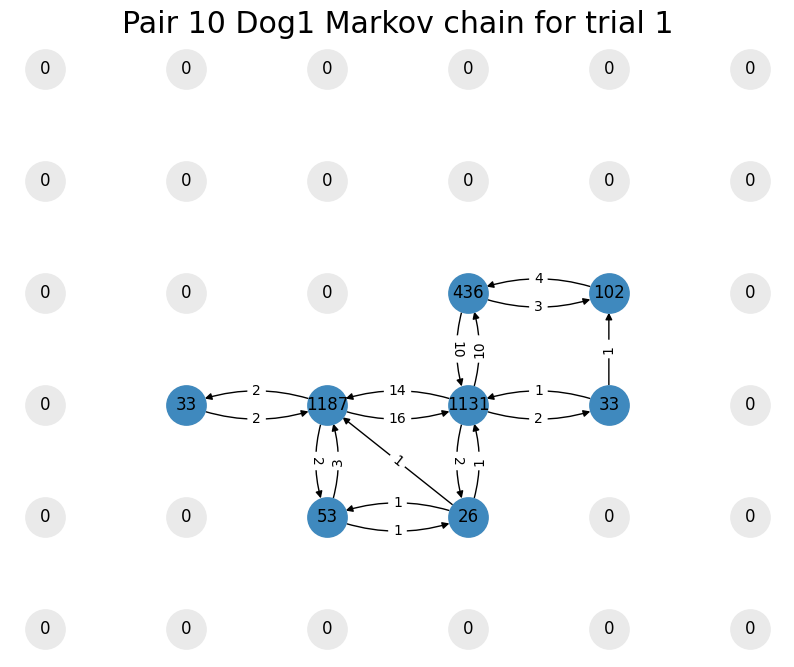

[((1, 1), (1, 1), np.float64(18.0)), ((1, 1), (1, 2), np.float64(1.0)), ((2, 1), (1, 1), np.float64(1.0)), ((2, 1), (2, 1), np.float64(111.0)), ((2, 1), (2, 2), np.float64(2.0)), ((2, 1), (3, 1), np.float64(4.0)), ((2, 1), (3, 2), np.float64(1.0)), ((3, 1), (2, 1), np.float64(1.0)), ((3, 1), (3, 1), np.float64(21.0)), ((3, 1), (3, 2), np.float64(3.0)), ((1, 2), (1, 2), np.float64(83.0)), ((1, 2), (1, 3), np.float64(3.0)), ((1, 2), (2, 2), np.float64(1.0)), ((2, 2), (1, 2), np.float64(3.0)), ((2, 2), (2, 1), np.float64(6.0)), ((2, 2), (2, 2), np.float64(1005.0)), ((2, 2), (2, 3), np.float64(6.0)), ((2, 2), (3, 2), np.float64(12.0)), ((3, 2), (2, 2), np.float64(15.0)), ((3, 2), (3, 2), np.float64(994.0)), ((3, 2), (3, 3), np.float64(7.0)), ((1, 3), (1, 3), np.float64(11.0)), ((1, 3), (2, 3), np.float64(3.0)), ((2, 3), (2, 2), np.float64(10.0)), ((2, 3), (2, 3), np.float64(361.0)), ((2, 3), (3, 3), np.float64(1.0)), ((3, 3), (2, 3), np.float64(2.0)), ((3, 3), (3, 2), np.float64(6.0)), ((3

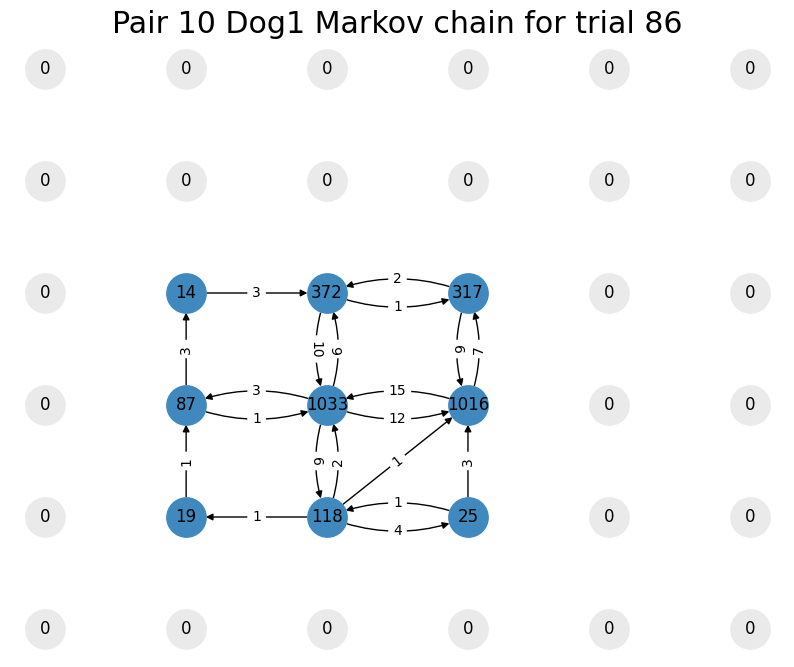

[((1, 1), (1, 1), np.float64(203.0)), ((1, 1), (1, 2), np.float64(2.0)), ((1, 1), (2, 1), np.float64(3.0)), ((2, 1), (1, 1), np.float64(3.0)), ((2, 1), (2, 1), np.float64(484.0)), ((2, 1), (2, 2), np.float64(4.0)), ((2, 1), (3, 1), np.float64(11.0)), ((2, 1), (3, 2), np.float64(1.0)), ((3, 1), (2, 1), np.float64(9.0)), ((3, 1), (3, 1), np.float64(414.0)), ((3, 1), (3, 2), np.float64(5.0)), ((3, 1), (4, 1), np.float64(6.0)), ((4, 1), (3, 1), np.float64(3.0)), ((4, 1), (4, 1), np.float64(139.0)), ((4, 1), (4, 2), np.float64(5.0)), ((1, 2), (1, 1), np.float64(2.0)), ((1, 2), (1, 2), np.float64(165.0)), ((1, 2), (1, 3), np.float64(1.0)), ((1, 2), (2, 2), np.float64(3.0)), ((2, 2), (1, 2), np.float64(3.0)), ((2, 2), (2, 1), np.float64(4.0)), ((2, 2), (2, 2), np.float64(246.0)), ((2, 2), (3, 2), np.float64(1.0)), ((3, 2), (2, 1), np.float64(2.0)), ((3, 2), (2, 2), np.float64(2.0)), ((3, 2), (3, 1), np.float64(5.0)), ((3, 2), (3, 2), np.float64(454.0)), ((3, 2), (3, 3), np.float64(2.0)), ((3,

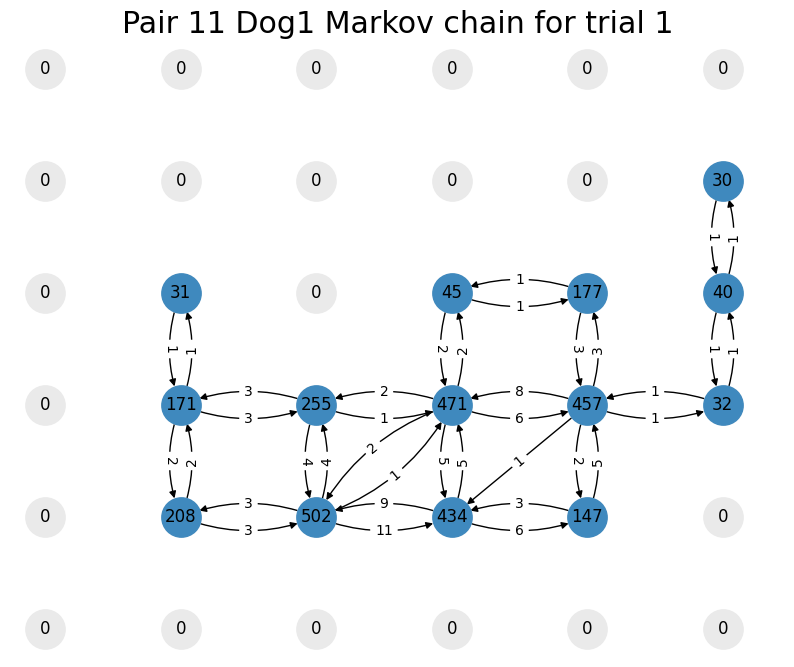

[((2, 1), (2, 1), np.float64(461.0)), ((2, 1), (2, 2), np.float64(27.0)), ((2, 1), (3, 1), np.float64(29.0)), ((3, 1), (2, 1), np.float64(23.0)), ((3, 1), (3, 1), np.float64(268.0)), ((3, 1), (3, 2), np.float64(30.0)), ((1, 2), (1, 2), np.float64(24.0)), ((1, 2), (2, 2), np.float64(2.0)), ((2, 2), (1, 2), np.float64(2.0)), ((2, 2), (2, 1), np.float64(30.0)), ((2, 2), (2, 2), np.float64(977.0)), ((2, 2), (3, 2), np.float64(4.0)), ((3, 2), (2, 1), np.float64(2.0)), ((3, 2), (2, 2), np.float64(7.0)), ((3, 2), (3, 1), np.float64(24.0)), ((3, 2), (3, 2), np.float64(1004.0)), ((3, 2), (4, 2), np.float64(5.0)), ((4, 2), (3, 2), np.float64(5.0)), ((4, 2), (4, 2), np.float64(76.0))]
# of non-zero transition probabilities for trial last: 19
# of states visited for trial last: 6
Average non-zero transition probability: 157.89474
{(1, 2): np.float64(26.0), (2, 1): np.float64(516.0), (3, 1): np.float64(321.0), (4, 2): np.float64(81.0), (2, 2): np.float64(1013.0), (3, 2): np.float64(1043.0)}


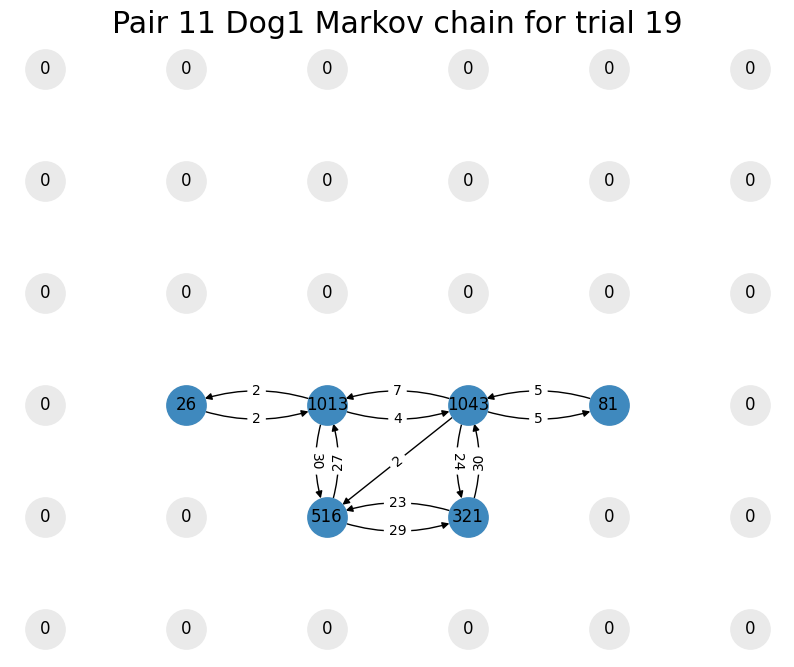

[((2, 1), (2, 1), np.float64(94.0)), ((2, 1), (2, 2), np.float64(2.0)), ((2, 1), (3, 1), np.float64(1.0)), ((3, 1), (2, 1), np.float64(1.0)), ((3, 1), (3, 1), np.float64(11.0)), ((0, 2), (0, 2), np.float64(14.0)), ((0, 2), (1, 2), np.float64(1.0)), ((1, 2), (0, 2), np.float64(1.0)), ((1, 2), (1, 2), np.float64(45.0)), ((1, 2), (1, 3), np.float64(1.0)), ((1, 2), (2, 2), np.float64(1.0)), ((2, 2), (1, 2), np.float64(1.0)), ((2, 2), (2, 1), np.float64(1.0)), ((2, 2), (2, 2), np.float64(1172.0)), ((2, 2), (2, 3), np.float64(5.0)), ((2, 2), (3, 2), np.float64(12.0)), ((3, 2), (2, 2), np.float64(12.0)), ((3, 2), (3, 2), np.float64(881.0)), ((3, 2), (3, 3), np.float64(7.0)), ((3, 2), (4, 2), np.float64(1.0)), ((4, 2), (3, 2), np.float64(1.0)), ((4, 2), (4, 2), np.float64(31.0)), ((1, 3), (1, 2), np.float64(1.0)), ((1, 3), (1, 3), np.float64(125.0)), ((1, 3), (2, 3), np.float64(2.0)), ((2, 3), (1, 3), np.float64(2.0)), ((2, 3), (2, 2), np.float64(5.0)), ((2, 3), (2, 3), np.float64(216.0)), ((3

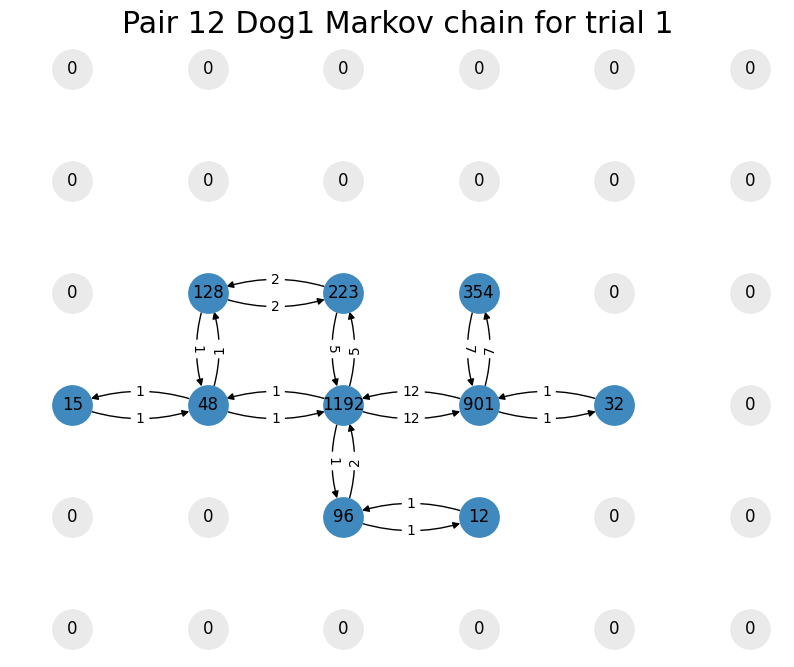

[((2, 1), (2, 1), np.float64(29.0)), ((2, 1), (2, 2), np.float64(1.0)), ((2, 2), (2, 2), np.float64(1443.0)), ((2, 2), (3, 2), np.float64(64.0)), ((3, 2), (2, 2), np.float64(63.0)), ((3, 2), (3, 2), np.float64(1364.0)), ((3, 2), (3, 3), np.float64(2.0)), ((3, 3), (3, 2), np.float64(2.0)), ((3, 3), (3, 3), np.float64(32.0))]
# of non-zero transition probabilities for trial last: 9
# of states visited for trial last: 4
Average non-zero transition probability: 333.33333
{(3, 2): np.float64(1430.0), (3, 3): np.float64(34.0), (2, 1): np.float64(29.0), (2, 2): np.float64(1507.0)}


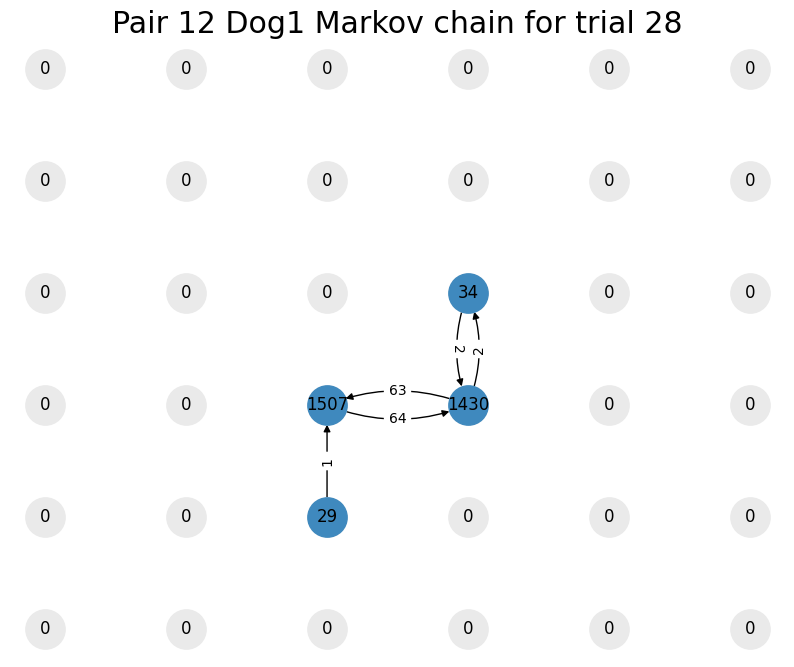

[((2, 1), (2, 1), np.float64(102.0)), ((2, 1), (2, 2), np.float64(4.0)), ((2, 1), (3, 1), np.float64(2.0)), ((3, 1), (2, 1), np.float64(1.0)), ((3, 1), (3, 1), np.float64(42.0)), ((3, 1), (3, 2), np.float64(2.0)), ((1, 2), (1, 2), np.float64(128.0)), ((1, 2), (1, 3), np.float64(3.0)), ((1, 2), (2, 2), np.float64(2.0)), ((2, 2), (1, 2), np.float64(4.0)), ((2, 2), (2, 1), np.float64(4.0)), ((2, 2), (2, 2), np.float64(1276.0)), ((2, 2), (2, 3), np.float64(1.0)), ((2, 2), (3, 1), np.float64(1.0)), ((2, 2), (3, 2), np.float64(11.0)), ((3, 2), (2, 2), np.float64(12.0)), ((3, 2), (3, 2), np.float64(1070.0)), ((3, 2), (3, 3), np.float64(1.0)), ((3, 2), (4, 2), np.float64(1.0)), ((4, 2), (3, 2), np.float64(1.0)), ((4, 2), (4, 2), np.float64(16.0)), ((4, 2), (4, 3), np.float64(1.0)), ((1, 3), (1, 2), np.float64(1.0)), ((1, 3), (1, 3), np.float64(103.0)), ((1, 3), (2, 3), np.float64(2.0)), ((2, 3), (2, 2), np.float64(3.0)), ((2, 3), (2, 3), np.float64(163.0)), ((3, 3), (3, 2), np.float64(1.0)), (

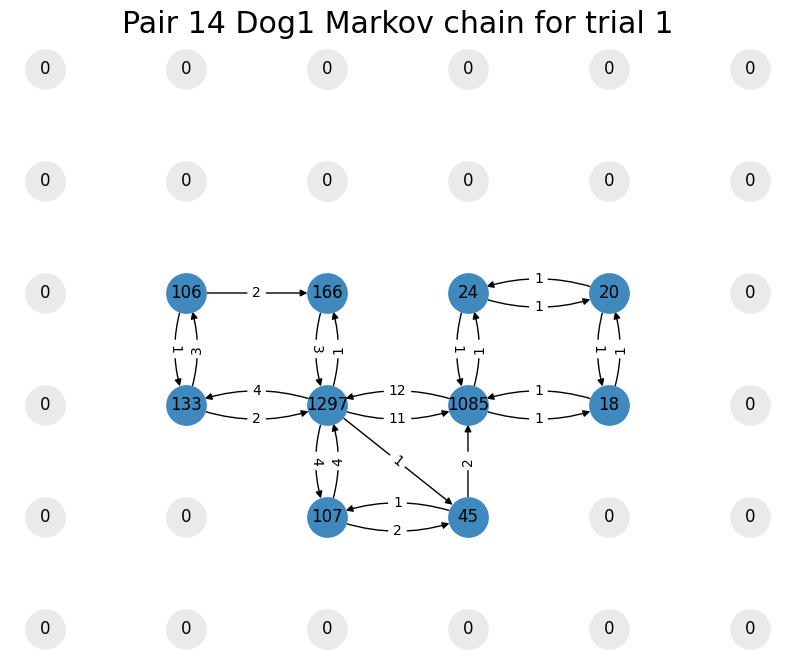

[((2, 1), (2, 1), np.float64(47.0)), ((2, 1), (2, 2), np.float64(1.0)), ((1, 2), (1, 2), np.float64(27.0)), ((1, 2), (2, 2), np.float64(1.0)), ((2, 2), (1, 2), np.float64(1.0)), ((2, 2), (2, 2), np.float64(1365.0)), ((2, 2), (2, 3), np.float64(2.0)), ((2, 2), (3, 2), np.float64(32.0)), ((3, 2), (2, 2), np.float64(31.0)), ((3, 2), (3, 2), np.float64(1252.0)), ((3, 2), (3, 3), np.float64(13.0)), ((2, 3), (2, 2), np.float64(2.0)), ((2, 3), (2, 3), np.float64(22.0)), ((3, 3), (3, 2), np.float64(13.0)), ((3, 3), (3, 3), np.float64(192.0))]
# of non-zero transition probabilities for trial last: 15
# of states visited for trial last: 6
Average non-zero transition probability: 200.06667
{(1, 2): np.float64(28.0), (2, 1): np.float64(47.0), (2, 3): np.float64(24.0), (3, 3): np.float64(205.0), (2, 2): np.float64(1400.0), (3, 2): np.float64(1297.0)}


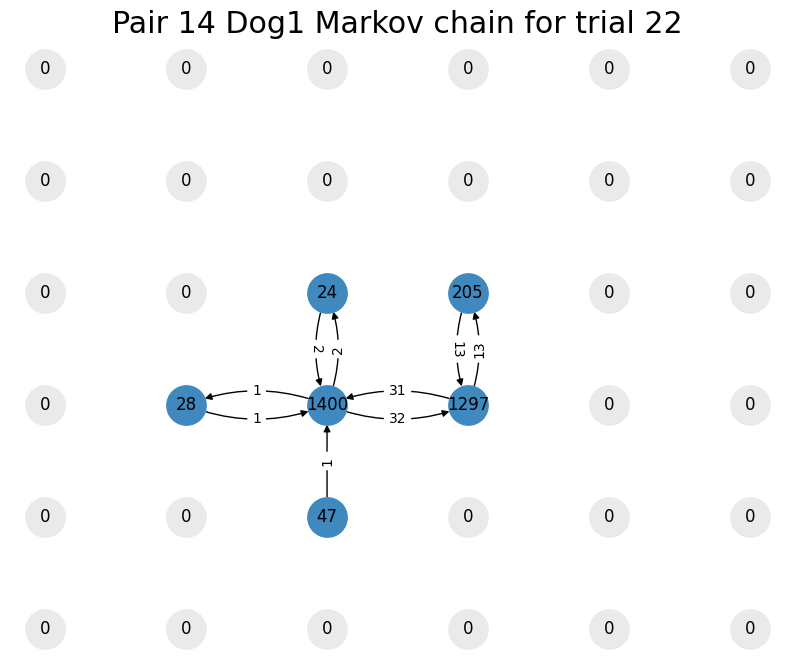

[((1, 1), (1, 1), np.float64(79.0)), ((1, 1), (2, 1), np.float64(2.0)), ((2, 1), (1, 1), np.float64(2.0)), ((2, 1), (2, 1), np.float64(299.0)), ((2, 1), (2, 2), np.float64(5.0)), ((2, 1), (3, 1), np.float64(2.0)), ((3, 1), (2, 1), np.float64(4.0)), ((3, 1), (3, 1), np.float64(53.0)), ((3, 1), (4, 2), np.float64(1.0)), ((1, 2), (1, 2), np.float64(340.0)), ((1, 2), (2, 2), np.float64(6.0)), ((2, 2), (1, 2), np.float64(6.0)), ((2, 2), (2, 1), np.float64(2.0)), ((2, 2), (2, 2), np.float64(569.0)), ((2, 2), (3, 2), np.float64(10.0)), ((3, 2), (2, 2), np.float64(7.0)), ((3, 2), (3, 1), np.float64(3.0)), ((3, 2), (3, 2), np.float64(795.0)), ((3, 2), (4, 2), np.float64(8.0)), ((4, 2), (3, 2), np.float64(9.0)), ((4, 2), (4, 2), np.float64(470.0)), ((4, 2), (4, 3), np.float64(7.0)), ((3, 3), (3, 3), np.float64(8.0)), ((3, 3), (3, 4), np.float64(1.0)), ((3, 3), (4, 3), np.float64(1.0)), ((4, 3), (3, 3), np.float64(1.0)), ((4, 3), (4, 2), np.float64(7.0)), ((4, 3), (4, 3), np.float64(287.0)), ((3,

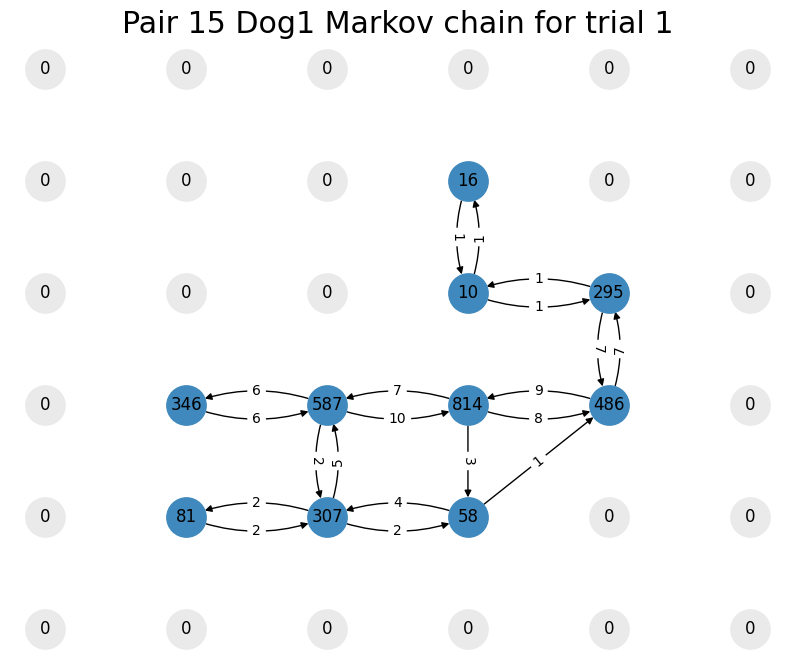

[((2, 1), (2, 1), np.float64(26.0)), ((2, 1), (3, 1), np.float64(1.0)), ((3, 1), (3, 1), np.float64(1.0)), ((3, 1), (3, 2), np.float64(1.0)), ((2, 2), (2, 2), np.float64(1485.0)), ((2, 2), (2, 3), np.float64(13.0)), ((2, 2), (3, 2), np.float64(72.0)), ((3, 2), (2, 2), np.float64(72.0)), ((3, 2), (3, 2), np.float64(1157.0)), ((3, 2), (3, 3), np.float64(6.0)), ((3, 2), (4, 2), np.float64(1.0)), ((4, 2), (3, 2), np.float64(1.0)), ((4, 2), (4, 2), np.float64(9.0)), ((4, 2), (4, 3), np.float64(1.0)), ((2, 3), (2, 2), np.float64(13.0)), ((2, 3), (2, 3), np.float64(62.0)), ((3, 3), (3, 2), np.float64(6.0)), ((3, 3), (3, 3), np.float64(32.0)), ((4, 3), (4, 2), np.float64(1.0)), ((4, 3), (4, 3), np.float64(40.0))]
# of non-zero transition probabilities for trial last: 20
# of states visited for trial last: 8
Average non-zero transition probability: 150.00000
{(2, 1): np.float64(26.0), (4, 3): np.float64(41.0), (3, 1): np.float64(2.0), (4, 2): np.float64(11.0), (2, 3): np.float64(75.0), (3, 3): 

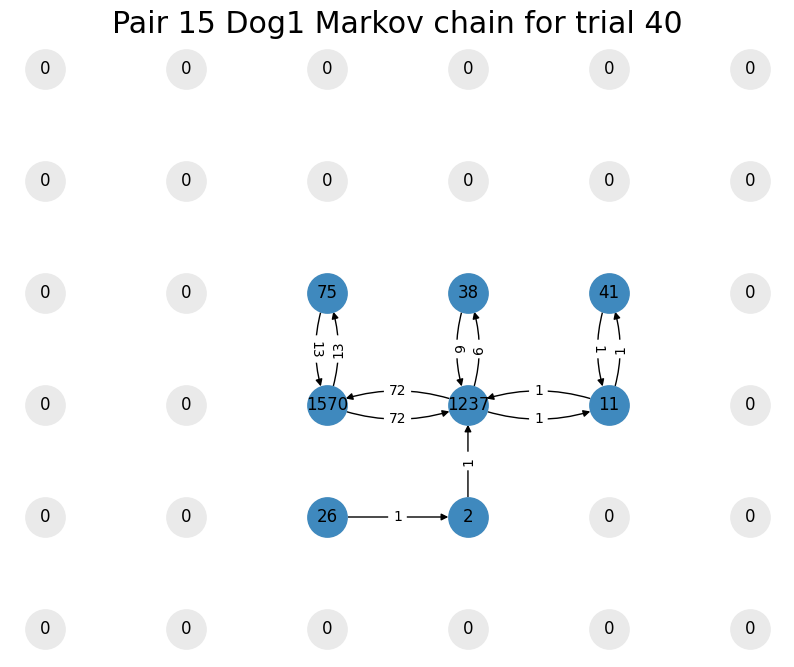

[((2, 1), (2, 1), np.float64(230.0)), ((2, 1), (2, 2), np.float64(2.0)), ((3, 1), (3, 1), np.float64(143.0)), ((3, 1), (3, 2), np.float64(4.0)), ((2, 2), (2, 2), np.float64(945.0)), ((2, 2), (2, 3), np.float64(8.0)), ((2, 2), (3, 2), np.float64(14.0)), ((3, 2), (2, 1), np.float64(2.0)), ((3, 2), (2, 2), np.float64(12.0)), ((3, 2), (3, 1), np.float64(4.0)), ((3, 2), (3, 2), np.float64(1060.0)), ((3, 2), (3, 3), np.float64(7.0)), ((3, 2), (4, 2), np.float64(3.0)), ((4, 2), (3, 2), np.float64(2.0)), ((4, 2), (4, 2), np.float64(99.0)), ((4, 2), (4, 3), np.float64(1.0)), ((2, 3), (2, 2), np.float64(8.0)), ((2, 3), (2, 3), np.float64(259.0)), ((2, 3), (3, 3), np.float64(1.0)), ((3, 3), (2, 3), np.float64(1.0)), ((3, 3), (3, 2), np.float64(8.0)), ((3, 3), (3, 3), np.float64(329.0)), ((3, 3), (4, 3), np.float64(3.0)), ((4, 3), (3, 3), np.float64(4.0)), ((4, 3), (4, 3), np.float64(21.0))]
# of non-zero transition probabilities for trial first: 25
# of states visited for trial first: 8
Average n

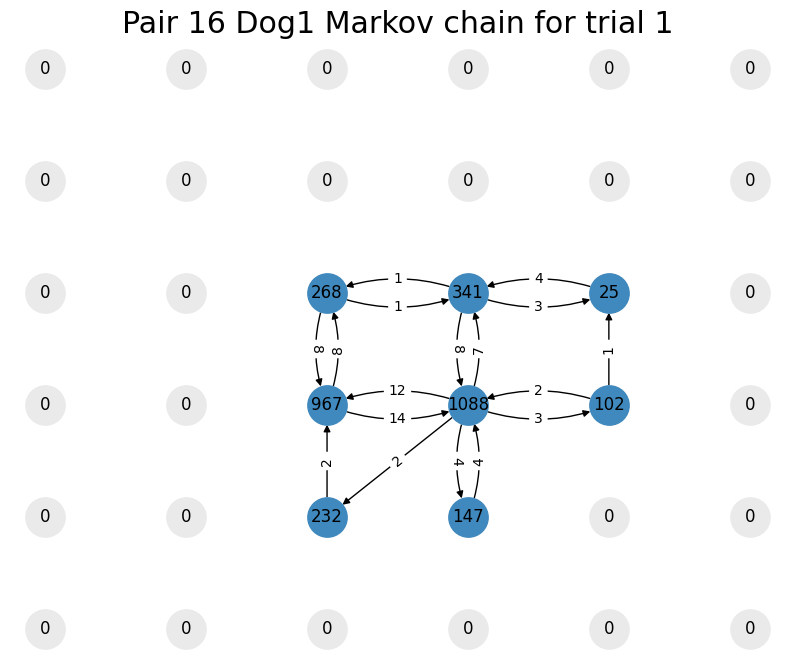

[((2, 1), (2, 1), np.float64(99.0)), ((2, 1), (3, 1), np.float64(1.0)), ((3, 1), (3, 1), np.float64(6.0)), ((3, 1), (3, 2), np.float64(1.0)), ((1, 2), (1, 2), np.float64(14.0)), ((1, 2), (1, 3), np.float64(1.0)), ((2, 2), (1, 2), np.float64(1.0)), ((2, 2), (2, 2), np.float64(1478.0)), ((2, 2), (2, 3), np.float64(5.0)), ((2, 2), (3, 2), np.float64(12.0)), ((3, 2), (2, 2), np.float64(13.0)), ((3, 2), (3, 2), np.float64(969.0)), ((3, 2), (3, 3), np.float64(1.0)), ((3, 2), (4, 2), np.float64(1.0)), ((4, 2), (4, 2), np.float64(1.0)), ((4, 2), (4, 3), np.float64(1.0)), ((1, 3), (1, 3), np.float64(40.0)), ((1, 3), (2, 3), np.float64(1.0)), ((2, 3), (2, 2), np.float64(5.0)), ((2, 3), (2, 3), np.float64(241.0)), ((3, 3), (3, 2), np.float64(1.0)), ((3, 3), (3, 3), np.float64(18.0)), ((3, 3), (4, 3), np.float64(1.0)), ((4, 3), (3, 2), np.float64(1.0)), ((4, 3), (3, 3), np.float64(1.0)), ((4, 3), (4, 3), np.float64(88.0))]
# of non-zero transition probabilities for trial last: 26
# of states visit

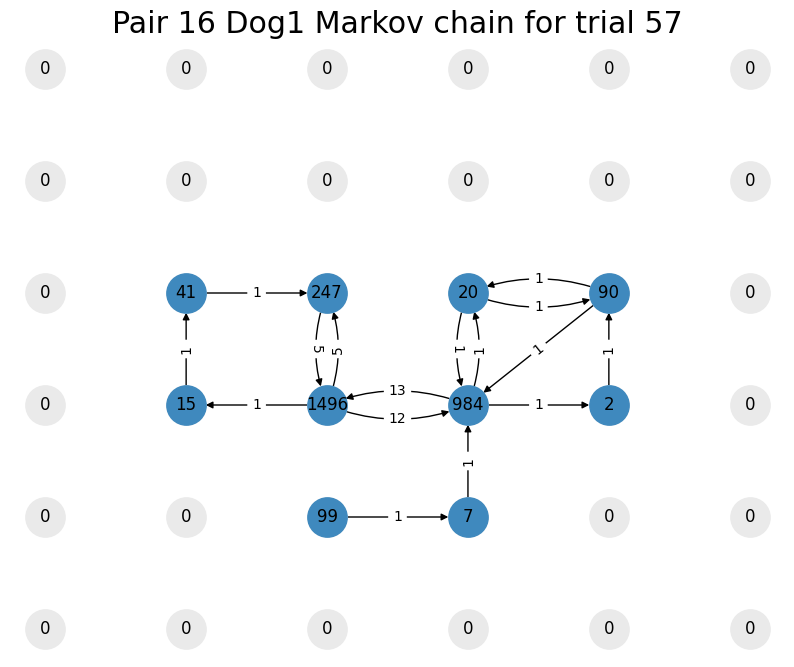

[((1, 1), (1, 1), np.float64(25.0)), ((1, 1), (2, 1), np.float64(2.0)), ((2, 1), (1, 1), np.float64(2.0)), ((2, 1), (2, 1), np.float64(192.0)), ((2, 1), (2, 2), np.float64(14.0)), ((2, 1), (3, 1), np.float64(6.0)), ((2, 1), (3, 2), np.float64(1.0)), ((3, 1), (2, 1), np.float64(8.0)), ((3, 1), (3, 1), np.float64(338.0)), ((3, 1), (3, 2), np.float64(14.0)), ((3, 1), (4, 1), np.float64(5.0)), ((4, 1), (3, 1), np.float64(4.0)), ((4, 1), (4, 1), np.float64(31.0)), ((4, 1), (4, 2), np.float64(2.0)), ((1, 2), (1, 2), np.float64(241.0)), ((1, 2), (1, 3), np.float64(3.0)), ((1, 2), (2, 2), np.float64(8.0)), ((2, 2), (1, 2), np.float64(9.0)), ((2, 2), (2, 1), np.float64(11.0)), ((2, 2), (2, 2), np.float64(747.0)), ((2, 2), (2, 3), np.float64(2.0)), ((2, 2), (3, 1), np.float64(1.0)), ((2, 2), (3, 2), np.float64(21.0)), ((3, 2), (2, 1), np.float64(1.0)), ((3, 2), (2, 2), np.float64(19.0)), ((3, 2), (3, 1), np.float64(16.0)), ((3, 2), (3, 2), np.float64(866.0)), ((3, 2), (3, 3), np.float64(2.0)), (

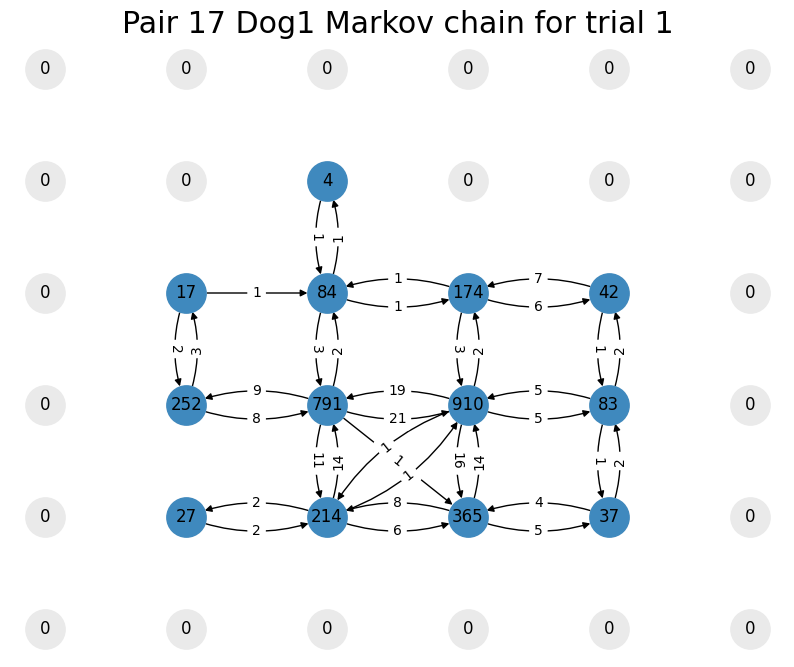

[((2, 1), (2, 1), np.float64(54.0)), ((2, 1), (2, 2), np.float64(3.0)), ((3, 1), (3, 1), np.float64(4.0)), ((3, 1), (3, 2), np.float64(1.0)), ((1, 2), (1, 2), np.float64(4.0)), ((1, 2), (1, 3), np.float64(1.0)), ((1, 2), (2, 2), np.float64(1.0)), ((2, 2), (1, 2), np.float64(2.0)), ((2, 2), (2, 1), np.float64(1.0)), ((2, 2), (2, 2), np.float64(1132.0)), ((2, 2), (2, 3), np.float64(9.0)), ((2, 2), (3, 2), np.float64(24.0)), ((3, 2), (2, 1), np.float64(1.0)), ((3, 2), (2, 2), np.float64(23.0)), ((3, 2), (3, 1), np.float64(1.0)), ((3, 2), (3, 2), np.float64(1160.0)), ((3, 2), (3, 3), np.float64(15.0)), ((3, 2), (4, 2), np.float64(2.0)), ((4, 2), (3, 2), np.float64(2.0)), ((4, 2), (4, 2), np.float64(28.0)), ((1, 3), (1, 3), np.float64(44.0)), ((1, 3), (2, 3), np.float64(3.0)), ((2, 3), (1, 3), np.float64(2.0)), ((2, 3), (2, 2), np.float64(10.0)), ((2, 3), (2, 3), np.float64(101.0)), ((3, 3), (3, 2), np.float64(15.0)), ((3, 3), (3, 3), np.float64(357.0))]
# of non-zero transition probabiliti

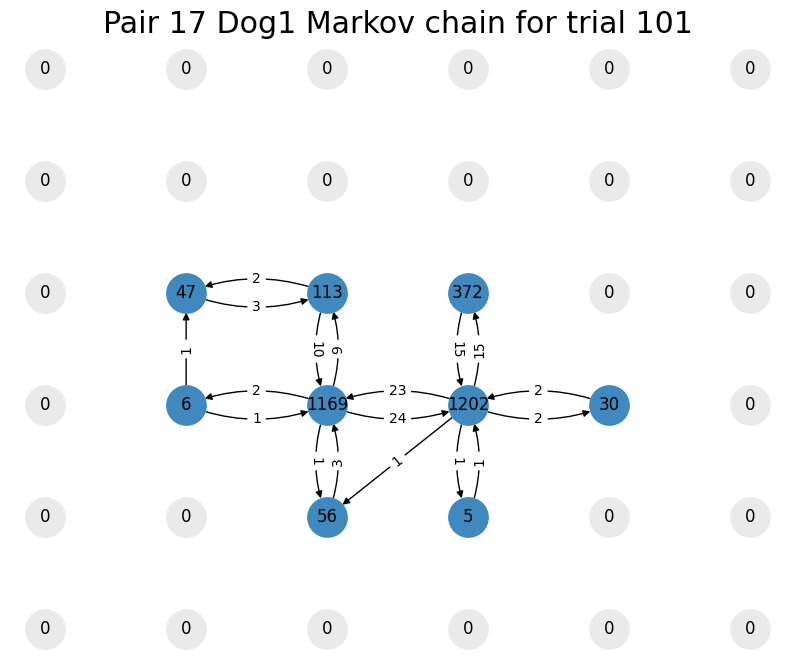

In [60]:
agent = 'Dog1'
# probs_mat_loaded = np.load(f'/content/gdrive/MyDrive/Grad School/fourth year/shepherd_game_analysis/data/gridsize{grid_width}_normalized_probs_mat_{agent}.npy')
# subj_num = [(i, pair) for (i, pair) in enumerate(cartesian_df['pair_num'].unique())]
subj_num = [(i, pair) for (i, pair) in enumerate(chosen_pairs)]
pair_nums = chosen_pairs_df['pair_num'].unique()
# Names each grid square / state as coordinates ((0,0) is top left corner)
states = [(j,i) for i in range(grid_res) for j in range(grid_res)]

wt_add_c = 0
wt_mult_c = 1
wt_power_c = 1
wt_add_w = 0
wt_mult_w = 1
wt_power_w = 1
node_size = 800

# Returns df of average transition probabilities
# add argument to not plot, just make df
pair_avg_probs = plot_markov_chains(subj_num=subj_num,
                                    adj_mat=transitions_mat,
                                    transitions_mat=transitions_mat,
                                    # adj_mat=probs_mat_loaded,
                                    grid_width=grid_res, states=states,
                                    pair_nums=pair_nums, agent=agent, data_path=data_path,
                                    wt_add_color=wt_add_c, wt_mult_color=wt_mult_c,
                                    wt_power_color=wt_power_c, wt_add_width=wt_add_w,
                                    wt_mult_width=wt_mult_w, wt_power_width=wt_power_w, wt_alpha=0.8,
                                    cmap=None, label_pos=0.5, label_alpha=1, node_size=node_size,
                                    wt_labels=True, show_node_labels=True,
                                    df=cartesian_df, bg_color='white', unused_nodes_color='#eaeaea',
                                    path_nodes_color='#3f89be',
                                    # path_nodes_color='#1f77b4',
                                    # path_nodes_color='#d2e4f0',
                                    arrow_size=2, scale_wt_width=False, arc_rad_adj=0.2,
                                    figsize=(10,8))